### Data Poisoining - GAN vs Noise

In [91]:
# Data Overview - Load, PV, Prosumption (metric) across FL and all Scales (Noise or GAN)

import os
import numpy as np
import pandas as pd

def summarize_data_poisoning_results(
    results_dir="results3",
    energy_map={"Load": 91, "PV": 92, "Prosumption": 93},
    noise_scales=(0.0, 0.3, 0.6, 0.9),
    architectures=("MLP", "SoftDenseMoE"),
    include_ll=False,                 # ignored (LL not included)
    ll_patterns_per_energy=None,      # ignored
    attack_source="noise",            # "noise" | "gan"
    label_prefix=None,                # default: "N" for noise, "G" for gan
    metric="mse"                      # <-- NEW: "mse" | "rmse" | "mae"
):
    """
    Build summary tables for Data Poisoning experiments (Noise or GAN).

    Returns
    -------
    dict
        {"Load": df_load, "PV": df_pv, "Prosumption": df_pros}
        Rows: ["FL", "<P>0.3", "<P>0.6", "<P>0.9"] with <P> = "N" (noise) or "G" (gan)
        Columns (8):
            - Unpoisoned: Mean <METRIC>
            - Unpoisoned: <METRIC> MLP
            - Unpoisoned: <METRIC> SoftDenseMoE
            - Poisoned:   Mean <METRIC>
            - Poisoned:   <METRIC> MLP
            - Poisoned:   <METRIC> SoftDenseMoE
            - Δ% vs FL (Unpoisoned)
            - Δ% vs FL (Poisoned)
    """

    # --- Validation & setup ---
    attack_source = str(attack_source).lower().strip()
    if attack_source not in {"noise", "gan"}:
        raise ValueError("attack_source must be 'noise' or 'gan'")

    metric = str(metric).lower().strip()
    if metric not in {"mse", "rmse", "mae"}:
        raise ValueError("metric must be one of: 'mse', 'rmse', 'mae'")

    METRIC_U = metric.upper()
    row_prefix = label_prefix if label_prefix is not None else ("N" if attack_source == "noise" else "G")

    def scale_to_token(x: float) -> str:
        # 0.3 -> "0p3"
        s = f"{x:.1f}"
        return s.replace(".", "p")

    def make_attack_path(energy_name: str, energy_id: int, scale: float) -> str:
        token = scale_to_token(scale)
        mid = "NoiseScale" if attack_source == "noise" else "GanScale"
        fname = f"{energy_id}{energy_name}_Poison_{mid}_{token}_Attack_all_results.csv"
        return os.path.join(results_dir, fname)

    def _normalize_arch(col: pd.Series) -> pd.Series:
        s = col.astype(str).str.strip().str.lower()
        return np.where(s.str.contains("soft"), "SoftDenseMoE", "MLP")

    def _poison_mask(df: pd.DataFrame) -> pd.Series:
        """
        If 'user_key' exists, treat user1 as poisoned (others unpoisoned).
        Otherwise, fall back to (building, poisoned_building[,_user]) matching.
        """
        if "user_key" in df.columns:
            return df["user_key"].astype(str).str.strip().str.lower() == "user1"

        b = df.get("building")
        p_b = df.get("poisoned_building")
        if b is None or p_b is None:
            return pd.Series(False, index=df.index)

        p_u_col = None
        for cand in ["poisoned_user_key", "poisoned_user"]:
            if cand in df.columns:
                p_u_col = cand
                break

        if p_u_col and ("user_key" in df.columns):
            lhs = b.astype(str).str.strip() + "||" + df["user_key"].astype(str).str.strip()
            rhs = df["poisoned_building"].astype(str).str.strip() + "||" + df[p_u_col].astype(str).str.strip()
            return lhs == rhs

        return b.astype(str).str.strip() == p_b.astype(str).str.strip()

    def _read_if_exists(path: str) -> pd.DataFrame | None:
        return pd.read_csv(path) if os.path.exists(path) else None

    def _aggregate_for_mask(df: pd.DataFrame, mask: pd.Series) -> dict:
        """
        Compute:
          - Mean <METRIC> (equal weight per (building, arch))
          - Per-arch means (equal weight per building)
        """
        cols = [
            f"Unpoisoned: Mean {METRIC_U}",
            f"Unpoisoned: {METRIC_U} MLP",
            f"Unpoisoned: {METRIC_U} SoftDenseMoE",
            f"Poisoned: Mean {METRIC_U}",
            f"Poisoned: {METRIC_U} MLP",
            f"Poisoned: {METRIC_U} SoftDenseMoE",
        ]
        if df is None or df.empty or mask is None or (mask.sum() == 0 and (~mask).sum() == 0):
            return {k: np.nan for k in cols}

        tmp = df.copy()
        tmp["arch_norm"] = _normalize_arch(tmp["architecture"])
        tmp["building"] = tmp["building"].astype(str).str.strip()

        res = {}
        for label, m in [("Unpoisoned", ~mask), ("Poisoned", mask)]:
            sub = tmp.loc[m]
            if sub.empty:
                res[f"{label}: Mean {METRIC_U}"] = np.nan
                res[f"{label}: {METRIC_U} MLP"] = np.nan
                res[f"{label}: {METRIC_U} SoftDenseMoE"] = np.nan
                continue

            # Per (building, arch) mean of chosen metric
            gba = (sub.groupby(["building", "arch_norm"])[metric]
                        .mean()
                        .reset_index(name="m_mean"))

            overall = gba["m_mean"].mean() if not gba.empty else np.nan
            arch_means = (gba.groupby("arch_norm")["m_mean"]
                            .mean()
                            .reindex(["MLP", "SoftDenseMoE"]))

            res[f"{label}: Mean {METRIC_U}"] = overall
            res[f"{label}: {METRIC_U} MLP"] = arch_means.get("MLP", np.nan)
            res[f"{label}: {METRIC_U} SoftDenseMoE"] = arch_means.get("SoftDenseMoE", np.nan)

        return res

    def _one_table_for_energy(energy_name: str, energy_id: int) -> pd.DataFrame:
        # Rows: FL (scale 0.0), then remaining scales
        row_labels = ["FL"] + [f"{row_prefix}{s:.1f}" for s in noise_scales if s != 0.0]
        cols = [
            f"Unpoisoned: Mean {METRIC_U}",
            f"Unpoisoned: {METRIC_U} MLP",
            f"Unpoisoned: {METRIC_U} SoftDenseMoE",
            f"Poisoned: Mean {METRIC_U}",
            f"Poisoned: {METRIC_U} MLP",
            f"Poisoned: {METRIC_U} SoftDenseMoE",
            "Δ% vs FL (Unpoisoned)",
            "Δ% vs FL (Poisoned)",
        ]
        out = pd.DataFrame(index=row_labels, columns=cols, dtype=float)

        # Fill rows for each scale; 0.0 → FL
        for scale in noise_scales:
            path = make_attack_path(energy_name, energy_id, scale)
            df = _read_if_exists(path)
            block = _aggregate_for_mask(df, _poison_mask(df)) if df is not None else {k: np.nan for k in cols[:6]}
            row_name = "FL" if scale == 0.0 else f"{row_prefix}{scale:.1f}"
            out.loc[row_name, cols[:6]] = [block.get(c, np.nan) for c in cols[:6]]

        # Deltas vs FL
        base_un = out.loc["FL", f"Unpoisoned: Mean {METRIC_U}"] if "FL" in out.index else np.nan
        base_po = out.loc["FL", f"Poisoned: Mean {METRIC_U}"] if "FL" in out.index else np.nan

        def pct_diff(val, base):
            if pd.isna(val) or pd.isna(base) or base == 0:
                return np.nan
            return (val - base) / base * 100.0

        for row in out.index:
            out.loc[row, "Δ% vs FL (Unpoisoned)"] = pct_diff(out.loc[row, f"Unpoisoned: Mean {METRIC_U}"], base_un)
            out.loc[row, "Δ% vs FL (Poisoned)"]   = pct_diff(out.loc[row, f"Poisoned: Mean {METRIC_U}"],   base_po)

        return out

    return {en: _one_table_for_energy(en, eid) for en, eid in energy_map.items()}


# --- Examples ---
# Noise-based summary with MSE (default)
noise_mse = summarize_data_poisoning_results(attack_source="noise", metric="rmse", label_prefix="N")
display(noise_mse["PV"])

# GAN-based summary with RMSE
gan_rmse = summarize_data_poisoning_results(attack_source="gan", metric="rmse", label_prefix="N")
display(gan_rmse["PV"])


,Unpoisoned: Mean RMSE,Unpoisoned: RMSE MLP,Unpoisoned: RMSE SoftDenseMoE,Poisoned: Mean RMSE,Poisoned: RMSE MLP,Poisoned: RMSE SoftDenseMoE,Δ% vs FL (Unpoisoned),Δ% vs FL (Poisoned)
FL,0.067310,0.066768,0.067852,0.068865,0.068091,0.069640,0.000000,0.000000
N0.3,0.074290,0.074251,0.074329,0.074483,0.074004,0.074961,10.369841,8.156764
N0.6,0.084529,0.085974,0.083085,0.084083,0.084630,0.083535,25.582097,22.096780
N0.9,0.095208,0.097082,0.093334,0.095416,0.096254,0.094578,41.446919,38.554324


,Unpoisoned: Mean RMSE,Unpoisoned: RMSE MLP,Unpoisoned: RMSE SoftDenseMoE,Poisoned: Mean RMSE,Poisoned: RMSE MLP,Poisoned: RMSE SoftDenseMoE,Δ% vs FL (Unpoisoned),Δ% vs FL (Poisoned)
FL,0.067883,0.066975,0.068791,0.069208,0.068383,0.070033,0.000000,0.000000
N0.3,0.095816,0.090162,0.101470,0.097311,0.091685,0.102938,41.148725,40.606367
N0.6,0.130871,0.127159,0.134583,0.131877,0.128459,0.135296,92.788681,90.551478
N0.9,0.157068,0.169398,0.144737,0.158580,0.171244,0.145915,131.380242,129.134374


In [94]:
# TABLE 1 + 2

import os
import numpy as np
import pandas as pd

def summarize_data_poisoning_results2(
    results_dir="results3",
    energy_map={"Load": 91, "PV": 92, "Prosumption": 93},
    noise_scales=(0.0, 0.3, 0.6, 0.9),
    noise_type="Distribution",        # "Distribution" (aka "noise") or "Gan"
    metric="mse"                      # "mse" | "rmse" | "mae"
) -> pd.DataFrame:
    """
    Returns a single DataFrame with 9 columns:
      [Load Mean <METRIC>, Load STD <METRIC>, Load Diff%,
       PV Mean <METRIC>,   PV STD <METRIC>,   PV Diff%,
       Prosumption Mean <METRIC>, Prosumption STD <METRIC>, Prosumption Diff%]
    Rows: "FL" (scale=0.0) + labeled scales (e.g., N0.3/N0.6/N0.9 or G0.3/...)
    """

    # --- Validate args ---
    m = str(metric).lower().strip()
    if m not in {"mse", "rmse", "mae"}:
        raise ValueError("metric must be one of: 'mse', 'rmse', 'mae'")
    METRIC_U = m.upper()

    nt = str(noise_type).lower().strip()
    if nt in {"distribution", "noise"}:
        mid_token = "NoiseScale"
        row_prefix = "N"
    elif nt == "gan":
        mid_token = "GanScale"
        row_prefix = "G"
    else:
        raise ValueError("noise_type must be 'Distribution' (or 'noise') or 'Gan'")

    def scale_to_token(x: float) -> str:
        s = f"{x:.1f}"
        return s.replace(".", "p")

    def make_attack_path(energy_name: str, energy_id: int, scale: float) -> str:
        token = scale_to_token(scale)
        fname = f"{energy_id}{energy_name}_Poison_{mid_token}_{token}_Attack_all_results.csv"
        return os.path.join(results_dir, fname)

    def _read_if_exists(path: str) -> pd.DataFrame | None:
        return pd.read_csv(path) if os.path.exists(path) else None

    def _normalize_arch(col: pd.Series) -> pd.Series:
        s = col.astype(str).str.strip().str.lower()
        return np.where(s.str.contains("soft"), "SoftDenseMoE", "MLP")

    def _poison_mask(df: pd.DataFrame) -> pd.Series:
        # user1 is poisoned, others unpoisoned
        if "user_key" in df.columns:
            return df["user_key"].astype(str).str.strip().str.lower() == "user1"

        # Fallback: use poisoned_* columns if present
        b = df.get("building")
        p_b = df.get("poisoned_building")
        if b is None or p_b is None:
            return pd.Series(False, index=df.index)

        p_u_col = None
        for cand in ["poisoned_user_key", "poisoned_user"]:
            if cand in df.columns:
                p_u_col = cand
                break

        if p_u_col and ("user_key" in df.columns):
            lhs = b.astype(str).str.strip() + "||" + df["user_key"].astype(str).str.strip()
            rhs = df["poisoned_building"].astype(str).str.strip() + "||" + df[p_u_col].astype(str).str.strip()
            return lhs == rhs

        return b.astype(str).str.strip() == p_b.astype(str).str.strip()

    def _unpoisoned_building_stats(df: pd.DataFrame) -> tuple[float, float]:
        """
        Returns (mean_across_buildings, std_across_buildings)
        where each building's value is the average of the chosen metric across architectures.
        STD is computed across buildings (ddof=0 to avoid NaN for single-building cases).
        """
        if df is None or df.empty:
            return (np.nan, np.nan)

        mask = _poison_mask(df)
        sub = df.loc[~mask].copy()  # unpoisoned only
        if sub.empty:
            return (np.nan, np.nan)

        sub["arch_norm"] = _normalize_arch(sub["architecture"])
        sub["building"] = sub["building"].astype(str).str.strip()

        # mean metric per (building, arch)
        gba = (sub.groupby(["building", "arch_norm"])[m]
                     .mean()
                     .reset_index(name="m_mean"))

        if gba.empty:
            return (np.nan, np.nan)

        # average across architectures per building
        per_building = (gba.groupby("building")["m_mean"].mean())

        mean_val = per_building.mean() if len(per_building) else np.nan
        std_val  = per_building.std(ddof=0) if len(per_building) else np.nan  # population std
        return (mean_val, std_val)

    # ---- Build row labels (FL + other scales) ----
    row_labels = ["FL"] + [f"{row_prefix}{s:.1f}" for s in noise_scales if s != 0.0]

    # prepare the final 9 columns
    def col_triplets(energy_name: str) -> list[str]:
        return [
            f"{energy_name} Mean {METRIC_U}",
            f"{energy_name} STD {METRIC_U}",
            f"{energy_name} Diff%",
        ]

    all_cols = col_triplets("Load") + col_triplets("PV") + col_triplets("Prosumption")
    out_num = pd.DataFrame(index=row_labels, columns=all_cols, dtype=float)

    # ---- Compute per-energy, per-row stats ----
    # We’ll also keep track of the FL (baseline) mean for each energy to compute Diff%.
    baseline_means = {en: np.nan for en in energy_map.keys()}

    for energy_name, energy_id in energy_map.items():
        # First pass: compute all means/stds and capture FL baseline
        per_row_vals = {}
        for scale in noise_scales:
            path = make_attack_path(energy_name, energy_id, scale)
            df = _read_if_exists(path)
            mean_val, std_val = _unpoisoned_building_stats(df)
            label = "FL" if scale == 0.0 else f"{row_prefix}{scale:.1f}"
            per_row_vals[label] = (mean_val, std_val)

        baseline_means[energy_name] = per_row_vals.get("FL", (np.nan, np.nan))[0]

        # Fill into out_num for this energy (Diff% will be added next)
        for label, (mean_val, std_val) in per_row_vals.items():
            out_num.loc[label, f"{energy_name} Mean {METRIC_U}"] = mean_val
            out_num.loc[label, f"{energy_name} STD {METRIC_U}"]  = std_val

        # Diff% vs FL
        base = baseline_means[energy_name]
        for label in row_labels:
            val = out_num.loc[label, f"{energy_name} Mean {METRIC_U}"]
            if pd.isna(val) or pd.isna(base) or base == 0:
                diff = np.nan
            else:
                diff = (val - base) / base * 100.0
            out_num.loc[label, f"{energy_name} Diff%"] = diff

    # ---- Format to 4 decimals (strings) ----
    def _fmt4(x):
        return "-" if pd.isna(x) else f"{float(x):.4f}"

    out_str = out_num.copy().astype(object)
    for r in out_str.index:
        for c in out_str.columns:
            out_str.loc[r, c] = _fmt4(out_num.loc[r, c])

    return out_str


# ----------------- Examples -----------------
# Noise from a distribution, MSE
df_noise_mse = summarize_data_poisoning_results2(
    results_dir="results3",
    noise_type="Distribution",
    metric="rmse"
)
display(df_noise_mse)

# GAN, RMSE
df_gan_rmse = summarize_data_poisoning_results2(
    results_dir="results3",
    noise_type="Gan",
    metric="rmse"
)
display(df_gan_rmse)




,Load Mean RMSE,Load STD RMSE,Load Diff%,PV Mean RMSE,PV STD RMSE,PV Diff%,Prosumption Mean RMSE,Prosumption STD RMSE,Prosumption Diff%
FL,0.1154,0.0314,0.0000,0.0673,0.0087,0.0000,0.1030,0.0289,0.0000
N0.3,0.1205,0.0293,4.3780,0.0743,0.0091,10.3698,0.1101,0.0277,6.9298
N0.6,0.1312,0.0283,13.6634,0.0845,0.0105,25.5821,0.1261,0.0369,22.4332
N0.9,0.1386,0.0283,20.1331,0.0952,0.0121,41.4469,0.1308,0.0382,27.0558


,Load Mean RMSE,Load STD RMSE,Load Diff%,PV Mean RMSE,PV STD RMSE,PV Diff%,Prosumption Mean RMSE,Prosumption STD RMSE,Prosumption Diff%
FL,0.1157,0.0316,0.0000,0.0679,0.0086,0.0000,0.1034,0.0298,0.0000
G0.3,0.1383,0.0224,19.5581,0.0958,0.0119,41.1487,0.1297,0.0234,25.3888
G0.6,0.1456,0.0287,25.8503,0.1309,0.0198,92.7887,0.1543,0.0351,49.1587
G0.9,0.1685,0.0296,45.6964,0.1571,0.0128,131.3802,0.1312,0.0367,26.8283


In [132]:
def summarize_parity_metrics(
    results_dir="results3",
    metric="rmse",                 # {"mse","rmse","mae"}
    noise_type="Distribution",     # {"Distribution","Gan"}
    energy_map=None,               # defaults to {"Load":91,"PV":92,"Prosumption":93}
    scale_low=0.0,
    scale_high=0.9,
    save_dir="figures2",
    save_csv=True,
):
    """
    Standalone summary of key parity numbers, per energy and overall:
      - n_buildings used
      - mean metric at low/high scale (equal weight per building, after equal weight over architectures)
      - mean absolute change and mean/median relative change (%)
      - fraction of buildings with degradation (m_high > m_low)
      - Pearson correlation between low and high
      - Linear y(x) fit: slope, intercept, R^2

    Saves CSV in figures2/ and returns the DataFrame.
    """
    # --- imports (kept inside for standalone use)
    import os
    import numpy as np
    import pandas as pd

    # --- internal helpers (duplicated so the function is self-contained)
    if energy_map is None:
        energy_map = {"Load": 91, "PV": 92, "Prosumption": 93}

    def _scale_token(x: float) -> str:
        return f"{x:.1f}".replace(".", "p")

    def _mid_for(source: str) -> str:
        return "NoiseScale" if source == "noise" else "GanScale"

    def _poison_path(results_dir: str, eid: int, energy: str, source: str, scale: float) -> str:
        return os.path.join(
            results_dir,
            f"{eid}{energy}_Poison_{_mid_for(source)}_{_scale_token(scale)}_Attack_all_results.csv"
        )

    def _normalize_arch(col: pd.Series) -> pd.Series:
        s = col.astype(str).str.strip().str.lower()
        return np.where(s.str.contains("soft"), "SoftDenseMoE", "MLP")

    def _read_df(results_dir: str, energy: str, eid: int, source: str, scale: float, metric: str):
        path = _poison_path(results_dir, eid, energy, source, scale)
        if not os.path.exists(path):
            return None
        df = pd.read_csv(path)
        if metric not in df.columns:
            return None
        df["arch_norm"] = _normalize_arch(df["architecture"]) if "architecture" in df.columns else "MLP"
        if "building" not in df.columns:
            return None
        df["building"] = df["building"].astype(str).str.strip()
        return df

    def _per_building_arch_mean(df: pd.DataFrame, metric: str) -> pd.DataFrame:
        if df is None or df.empty:
            return pd.DataFrame(columns=["building", "arch_norm", "m"])
        g = (df.groupby(["building", "arch_norm"], as_index=False)[metric]
               .mean()
               .rename(columns={metric: "m"}))
        return g

    def _per_building_mean_over_arch(g: pd.DataFrame) -> pd.DataFrame:
        if g is None or g.empty:
            return pd.DataFrame(columns=["building", "m_building"])
        b = (g.groupby("building", as_index=False)["m"].mean()
               .rename(columns={"m": "m_building"}))
        return b

    def _assemble_pairs_for_energy(energy, eid, source, metric):
        df_lo = _read_df(results_dir, energy, eid, source, scale_low, metric)
        df_hi = _read_df(results_dir, energy, eid, source, scale_high, metric)
        if df_lo is None or df_hi is None or df_lo.empty or df_hi.empty:
            return pd.DataFrame(columns=["building","m_low","m_high","energy"])
        g0 = _per_building_mean_over_arch(_per_building_arch_mean(df_lo, metric)).rename(columns={"m_building": "m_low"})
        g1 = _per_building_mean_over_arch(_per_building_arch_mean(df_hi, metric)).rename(columns={"m_building": "m_high"})
        m = pd.merge(g0, g1, on="building", how="inner")
        if m.empty:
            return pd.DataFrame(columns=["building","m_low","m_high","energy"])
        m["energy"] = energy
        return m

    # --- arg checks and source selection
    metric = metric.lower().strip()
    if metric not in {"mse", "rmse", "mae"}:
        raise ValueError("metric must be one of {'mse','rmse','mae'}")

    nt = str(noise_type).strip().lower()
    if nt in {"distribution", "dist", "noise"}:
        source = "noise"
        src_title = "Noise Distribution"
    elif nt in {"gan"}:
        source = "gan"
        src_title = "GAN"
    else:
        raise ValueError("noise_type must be 'Distribution' or 'Gan'")

    # --- collect pairs across energies
    pairs = []
    for energy, eid in energy_map.items():
        pairs.append(_assemble_pairs_for_energy(energy, eid, source, metric))
    df_pairs = pd.concat([p for p in pairs if not p.empty], ignore_index=True)
    if df_pairs.empty:
        raise RuntimeError("No parity pairs assembled; check files and metric column.")

    # --- summary per energy
    rows = []
    for energy in sorted(df_pairs["energy"].unique().tolist()):
        sub = df_pairs[df_pairs.energy==energy]
        n = len(sub)
        m0 = float(np.nanmean(sub["m_low"]))
        m1 = float(np.nanmean(sub["m_high"]))
        abs_change = float(np.nanmean(sub["m_high"] - sub["m_low"]))
        # relative change per building (exclude zero baseline)
        base = sub["m_low"].to_numpy(dtype=float)
        rel = (sub["m_high"].to_numpy(dtype=float) - base) / np.where(base != 0, base, np.nan) * 100.0
        rel = rel[np.isfinite(rel)]
        mean_rel = float(np.nanmean(rel)) if rel.size else np.nan
        median_rel = float(np.nanmedian(rel)) if rel.size else np.nan
        frac_deg = float(np.nanmean((sub["m_high"] > sub["m_low"]).to_numpy(dtype=float)))

        # correlation and linear fit
        x = sub["m_low"].to_numpy(dtype=float)
        y = sub["m_high"].to_numpy(dtype=float)
        ok = np.isfinite(x) & np.isfinite(y)
        if ok.sum() >= 2:
            r = float(np.corrcoef(x[ok], y[ok])[0,1])
            A = np.vstack([x[ok], np.ones(ok.sum())]).T
            slope, intercept = np.linalg.lstsq(A, y[ok], rcond=None)[0]
            yhat = slope * x[ok] + intercept
            ss_res = float(np.sum((y[ok] - yhat)**2))
            ss_tot = float(np.sum((y[ok] - np.mean(y[ok]))**2))
            r2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan
        else:
            r = np.nan; slope = np.nan; intercept = np.nan; r2 = np.nan

        rows.append({
            "source": src_title,
            "metric": metric.upper(),
            "energy": energy,
            "scale_low": scale_low,
            "scale_high": scale_high,
            "n_buildings": n,
            f"mean_{_scale_token(scale_low)}": m0,
            f"mean_{_scale_token(scale_high)}": m1,
            "mean_abs_change": abs_change,
            "mean_rel_change_pct": mean_rel,
            "median_rel_change_pct": median_rel,
            "fraction_degraded": frac_deg,
            "pearson_r": r,
            "lin_slope": float(slope),
            "lin_intercept": float(intercept),
            "r_squared": float(r2),
        })

    # --- overall row (pooled)
    energy = "All"
    sub = df_pairs
    n = len(sub)
    m0 = float(np.nanmean(sub["m_low"]))
    m1 = float(np.nanmean(sub["m_high"]))
    abs_change = float(np.nanmean(sub["m_high"] - sub["m_low"]))
    base = sub["m_low"].to_numpy(dtype=float)
    rel = (sub["m_high"].to_numpy(dtype=float) - base) / np.where(base != 0, base, np.nan) * 100.0
    rel = rel[np.isfinite(rel)]
    mean_rel = float(np.nanmean(rel)) if rel.size else np.nan
    median_rel = float(np.nanmedian(rel)) if rel.size else np.nan
    frac_deg = float(np.nanmean((sub["m_high"] > sub["m_low"]).to_numpy(dtype=float)))
    x = sub["m_low"].to_numpy(dtype=float)
    y = sub["m_high"].to_numpy(dtype=float)
    ok = np.isfinite(x) & np.isfinite(y)
    if ok.sum() >= 2:
        r = float(np.corrcoef(x[ok], y[ok])[0,1])
        A = np.vstack([x[ok], np.ones(ok.sum())]).T
        slope, intercept = np.linalg.lstsq(A, y[ok], rcond=None)[0]
        yhat = slope * x[ok] + intercept
        ss_res = float(np.sum((y[ok] - yhat)**2))
        ss_tot = float(np.sum((y[ok] - np.mean(y[ok]))**2))
        r2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan
    else:
        r = np.nan; slope = np.nan; intercept = np.nan; r2 = np.nan

    rows.append({
        "source": src_title,
        "metric": metric.upper(),
        "energy": energy,
        "scale_low": scale_low,
        "scale_high": scale_high,
        "n_buildings": n,
        f"mean_{_scale_token(scale_low)}": m0,
        f"mean_{_scale_token(scale_high)}": m1,
        "mean_abs_change": abs_change,
        "mean_rel_change_pct": mean_rel,
        "median_rel_change_pct": median_rel,
        "fraction_degraded": frac_deg,
        "pearson_r": r,
        "lin_slope": float(slope),
        "lin_intercept": float(intercept),
        "r_squared": float(r2),
    })

    df_summary = pd.DataFrame(rows)

    # save
    if save_csv:
        os.makedirs(save_dir, exist_ok=True)
        out_csv = os.path.join(
            save_dir,
            f"ParitySummary_{src_title.replace(' ','')}_{metric.upper()}_{_scale_token(scale_low)}_vs_{_scale_token(scale_high)}.csv"
        )
        df_summary.to_csv(out_csv, index=False)

    return df_summary


In [133]:
def plot_parity_by_noise(
    results_dir="results3",
    metric="rmse",                 # {"mse","rmse","mae"}
    noise_type="Distribution",     # {"Distribution","Gan"}
    energy_map=None,               # defaults to {"Load":91,"PV":92,"Prosumption":93}
    scale_low=0.0,
    scale_high=0.9,
    save_dir="figures2",
):
    """
    Standalone parity plot:
      - Compares metric at scale_high (y) vs scale_low (x) per building.
      - One figure for the selected noise_type.
      - Colors indicate energy type. Points are averaged equally across architectures within a building.

    Saves: figures2/Parity_<NoiseType>_<METRIC>.pdf
    Returns: the (optional) concatenated pairs DataFrame used for plotting.
    """
    # --- imports (kept inside for standalone use)
    import os
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    # --- defaults & styling
    if energy_map is None:
        energy_map = {"Load": 91, "PV": 92, "Prosumption": 93}

    ENERGY_COLORS = {"Load": "#E4D554", "PV": "#294586", "Prosumption": "#903045"}
    ENERGY_MARKERS = {"Load": "o", "PV": "s", "Prosumption": "^"}

    def _apply_journal_style(ax):
        ax.grid(True, axis="y", linewidth=1.0, alpha=0.35)
        for spine in ax.spines.values():
            spine.set_linewidth(1.6)
        ax.tick_params(axis='both', which='both', labelsize=16, width=1.6)
        for lbl in ax.get_xticklabels() + ax.get_yticklabels():
            lbl.set_fontweight('bold')

    # --- helpers
    def _scale_token(x: float) -> str:
        return f"{x:.1f}".replace(".", "p")

    def _mid_for(source: str) -> str:
        return "NoiseScale" if source == "noise" else "GanScale"

    def _poison_path(results_dir: str, eid: int, energy: str, source: str, scale: float) -> str:
        return os.path.join(
            results_dir,
            f"{eid}{energy}_Poison_{_mid_for(source)}_{_scale_token(scale)}_Attack_all_results.csv"
        )

    def _normalize_arch(col: pd.Series) -> pd.Series:
        s = col.astype(str).str.strip().str.lower()
        return np.where(s.str.contains("soft"), "SoftDenseMoE", "MLP")

    def _read_df(results_dir: str, energy: str, eid: int, source: str, scale: float, metric: str):
        path = _poison_path(results_dir, eid, energy, source, scale)
        if not os.path.exists(path):
            return None
        df = pd.read_csv(path)
        if metric not in df.columns:
            return None
        df["arch_norm"] = _normalize_arch(df["architecture"]) if "architecture" in df.columns else "MLP"
        if "building" not in df.columns:
            return None
        df["building"] = df["building"].astype(str).str.strip()
        return df

    def _per_building_arch_mean(df: pd.DataFrame, metric: str) -> pd.DataFrame:
        if df is None or df.empty:
            return pd.DataFrame(columns=["building", "arch_norm", "m"])
        g = (df.groupby(["building", "arch_norm"], as_index=False)[metric]
               .mean()
               .rename(columns={metric: "m"}))
        return g

    def _per_building_mean_over_arch(g: pd.DataFrame) -> pd.DataFrame:
        if g is None or g.empty:
            return pd.DataFrame(columns=["building", "m_building"])
        b = (g.groupby("building", as_index=False)["m"].mean()
               .rename(columns={"m": "m_building"}))
        return b

    # --- arg checks and source selection
    metric = metric.lower().strip()
    if metric not in {"mse", "rmse", "mae"}:
        raise ValueError("metric must be one of {'mse','rmse','mae'}")

    nt = str(noise_type).strip().lower()
    if nt in {"distribution", "dist", "noise"}:
        source = "noise"
        src_title = "Noise Distribution"
    elif nt in {"gan"}:
        source = "gan"
        src_title = "GAN"
    else:
        raise ValueError("noise_type must be 'Distribution' or 'Gan'")

    # --- build the parity pairs
    pairs_all = []
    for energy, eid in energy_map.items():
        df_lo = _read_df(results_dir, energy, eid, source, scale_low, metric)
        df_hi = _read_df(results_dir, energy, eid, source, scale_high, metric)
        if df_lo is None or df_hi is None or df_lo.empty or df_hi.empty:
            continue

        g0 = _per_building_mean_over_arch(_per_building_arch_mean(df_lo, metric)).rename(columns={"m_building": "m_low"})
        g1 = _per_building_mean_over_arch(_per_building_arch_mean(df_hi, metric)).rename(columns={"m_building": "m_high"})
        m = pd.merge(g0, g1, on="building", how="inner")
        if m.empty:
            continue
        m["energy"] = energy
        pairs_all.append(m)

    if not pairs_all:
        raise RuntimeError("No parity data could be assembled (check files and metric column).")

    df_pairs = pd.concat(pairs_all, ignore_index=True)

    # --- plot
    fig, ax = plt.subplots(figsize=(10, 8))

    for energy in energy_map.keys():
        sub = df_pairs[df_pairs["energy"] == energy]
        if sub.empty:
            continue
        ax.scatter(
            sub["m_low"], sub["m_high"],
            s=110,
            marker=ENERGY_MARKERS.get(energy, "o"),
            color=ENERGY_COLORS.get(energy, "#666666"),
            edgecolor="black",
            linewidths=1.2,
            alpha=0.9,
            label=energy
        )

    mmax = float(np.nanmax(np.r_[df_pairs["m_low"].values, df_pairs["m_high"].values]))
    ax.plot([0, mmax], [0, mmax], linestyle="--", linewidth=2.0, color="gray", alpha=0.7)
    ax.set_xlim(0, mmax * 1.05)
    ax.set_ylim(0, mmax * 1.05)

    ax.set_title(f"Parity — {src_title} ({metric.upper()} at {scale_high:.1f} vs {scale_low:.1f})",
                 fontsize=20, fontweight="bold")
    ax.set_xlabel(f"{metric.upper()} at {scale_low:.1f}", fontsize=18, fontweight="bold")
    ax.set_ylabel(f"{metric.upper()} at {scale_high:.1f}", fontsize=18, fontweight="bold")

    _apply_journal_style(ax)
    leg = ax.legend(title="Energy", loc="best", fontsize=15, frameon=True)
    if leg and leg.get_title():
        leg.get_title().set_fontsize(16)
        leg.get_title().set_fontweight("bold")

    # --- save
    os.makedirs(save_dir, exist_ok=True)
    fname = f"Parity_{src_title.replace(' ','')}_{metric.upper()}_{_scale_token(scale_low)}_vs_{_scale_token(scale_high)}.pdf"
    fig.savefig(os.path.join(save_dir, fname), format="pdf", bbox_inches="tight")
    plt.close(fig)

    return df_pairs


In [214]:
# 1) Make the figure and get the pairs used for plotting
pairs_noise = plot_parity_by_noise(metric="rmse", noise_type="Distribution")

# 2) Summarize key numbers for later analysis (also writes CSV)
summary_noise = summarize_parity_metrics(metric="rmse", noise_type="Distribution")

# Repeat for GAN
pairs_gan = plot_parity_by_noise(metric="rmse", noise_type="Gan")
summary_gan = summarize_parity_metrics(metric="rmse", noise_type="Gan")

display(summary_noise)
display(summary_gan)

,source,metric,energy,scale_low,scale_high,n_buildings,mean_0p0,mean_0p9,mean_abs_change,mean_rel_change_pct,median_rel_change_pct,fraction_degraded,pearson_r,lin_slope,lin_intercept,r_squared
0,Noise Distribution,RMSE,Load,0.0,0.9,20,0.103029,0.123242,0.020213,23.711820,17.783452,0.900000,0.880582,0.826106,0.038129,0.775424
1,Noise Distribution,RMSE,PV,0.0,0.9,20,0.068088,0.095312,0.027224,40.512197,40.435131,1.000000,0.869123,1.037911,0.024643,0.755374
2,Noise Distribution,RMSE,Prosumption,0.0,0.9,20,0.093987,0.116440,0.022453,27.119110,20.416111,0.900000,0.869830,1.029311,0.019698,0.756604
3,Noise Distribution,RMSE,All,0.0,0.9,60,0.088368,0.111665,0.023297,30.447709,33.973473,0.933333,0.888810,0.894919,0.032582,0.789984


,source,metric,energy,scale_low,scale_high,n_buildings,mean_0p0,mean_0p9,mean_abs_change,mean_rel_change_pct,median_rel_change_pct,fraction_degraded,pearson_r,lin_slope,lin_intercept,r_squared
0,GAN,RMSE,Load,0.0,0.9,20,0.103234,0.154511,0.051277,60.616464,37.997333,1.000000,0.618379,0.645547,0.087869,0.382392
1,GAN,RMSE,PV,0.0,0.9,20,0.068546,0.157824,0.089278,132.290039,133.447999,1.000000,0.493581,0.759858,0.105739,0.243622
2,GAN,RMSE,Prosumption,0.0,0.9,20,0.093435,0.126316,0.032881,41.340384,31.937742,0.950000,0.760289,0.838126,0.048006,0.578039
3,GAN,RMSE,All,0.0,0.9,60,0.088405,0.146217,0.057812,78.082296,72.858715,0.983333,0.463391,0.492792,0.102652,0.214731


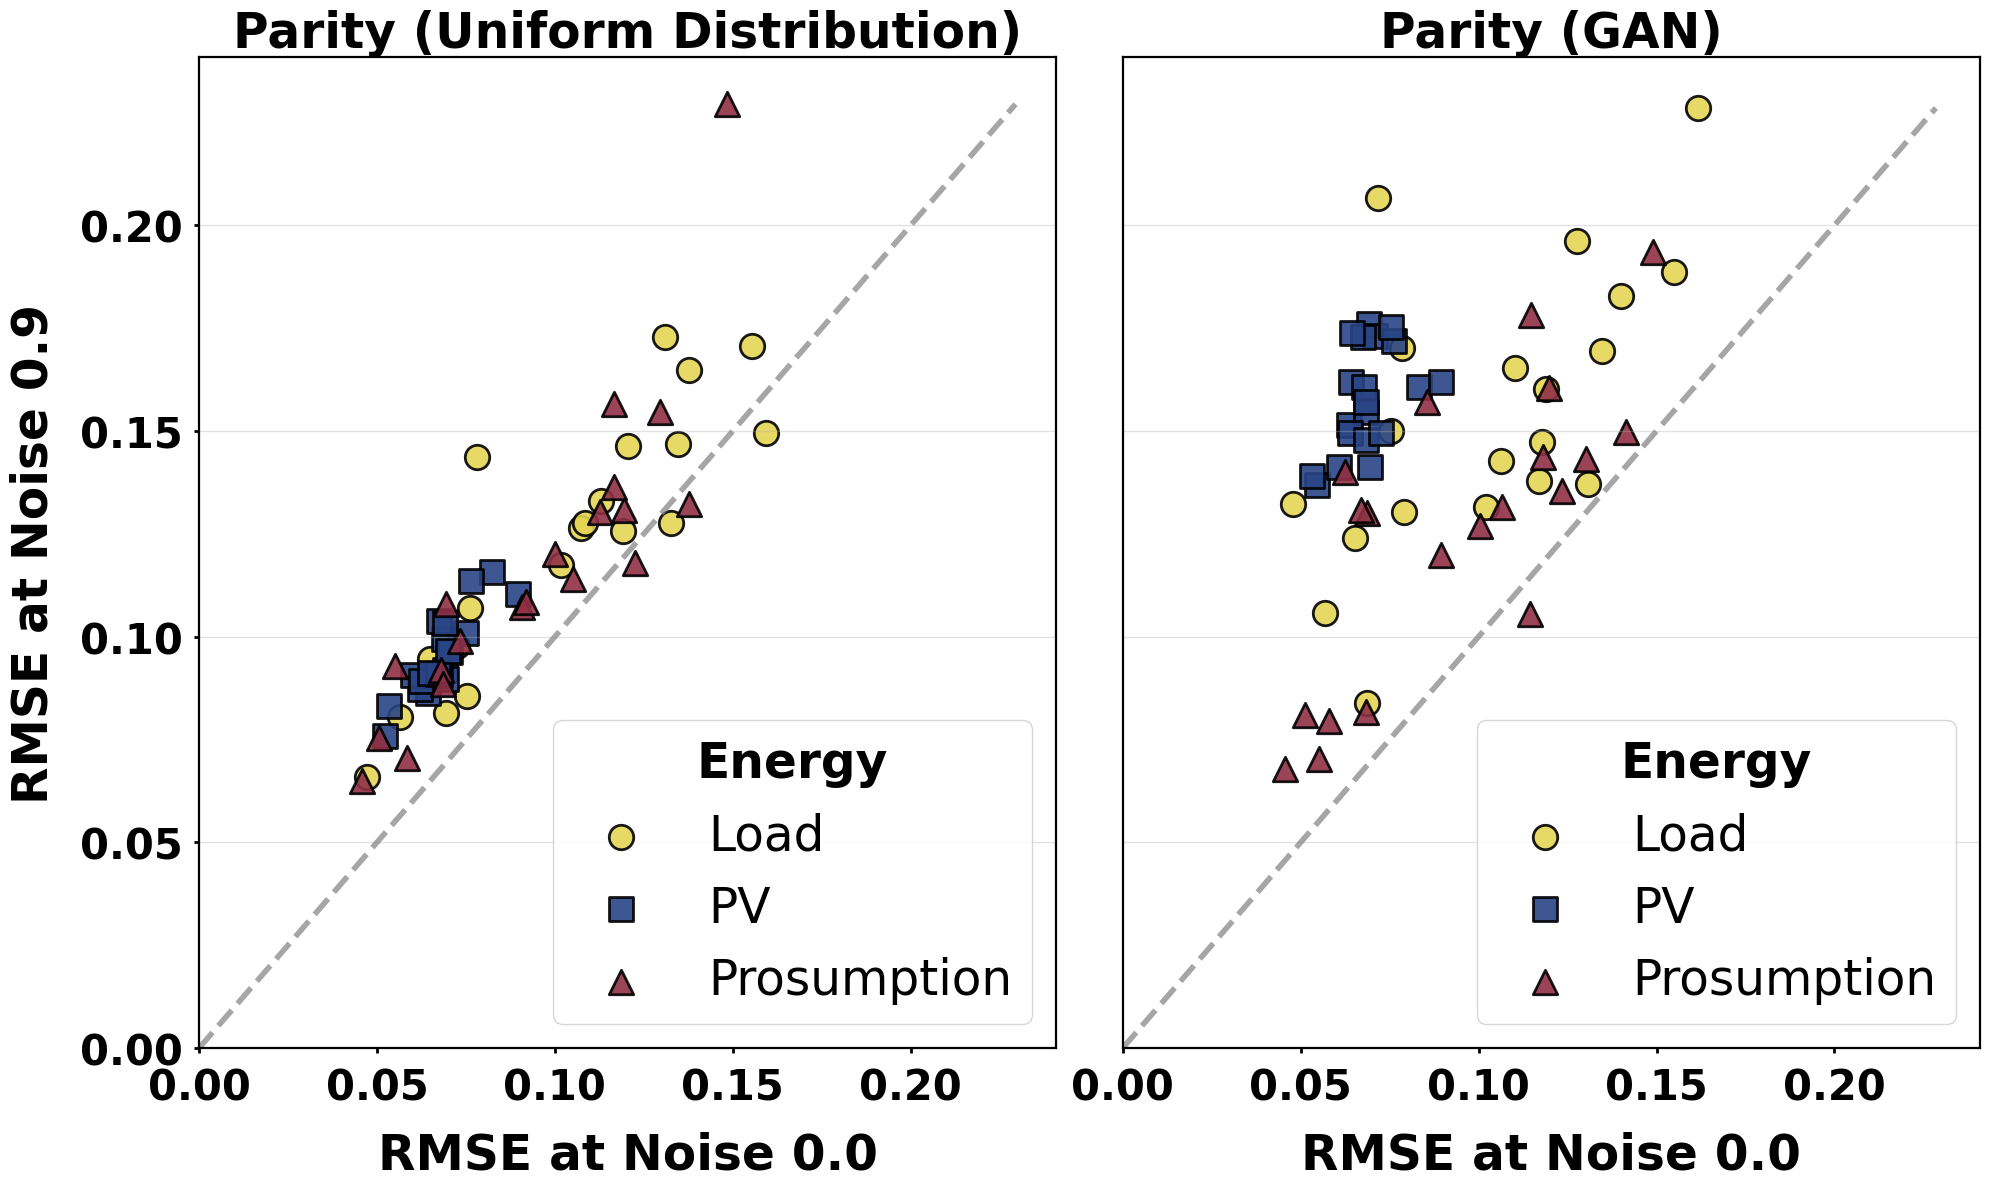

In [ ]:
import os
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# -----------------------------
# Common configuration & helpers
# -----------------------------

ENERGY_MAP_DEFAULT = {"Load": 91, "PV": 92, "Prosumption": 93}
# Consistent colors across all figures
ENERGY_COLORS = {"Load": "#E4D554", "PV": "#294586", "Prosumption": "#903045"}
ENERGY_MARKERS = {"Load": "o", "PV": "s", "Prosumption": "^"}

def _scale_token(x: float) -> str:
    return f"{x:.1f}".replace(".", "p")

def _mid_for(source: str) -> str:
    return "NoiseScale" if source == "noise" else "GanScale"

def _poison_path(results_dir: str, eid: int, energy: str, source: str, scale: float) -> str:
    # Attack baseline (no security measures)
    return os.path.join(
        results_dir,
        f"{eid}{energy}_Poison_{_mid_for(source)}_{_scale_token(scale)}_Attack_all_results.csv"
    )

def _normalize_arch(col: pd.Series) -> pd.Series:
    s = col.astype(str).str.strip().str.lower()
    return np.where(s.str.contains("soft"), "SoftDenseMoE", "MLP")

def _poison_mask(df: pd.DataFrame) -> pd.Series:
    """Identify poisoned users robustly using building (+ user_key if available)."""
    b = df.get("building")
    p_b = df.get("poisoned_building")
    if b is None or p_b is None:
        return pd.Series(False, index=df.index)
    p_u_col = next((c for c in ["poisoned_user_key", "poisoned_user"] if c in df.columns), None)
    if p_u_col and ("user_key" in df.columns):
        lhs = b.astype(str).str.strip() + "||" + df["user_key"].astype(str).str.strip()
        rhs = df["poisoned_building"].astype(str).str.strip() + "||" + df[p_u_col].astype(str).str.strip()
        return lhs == rhs
    return b.astype(str).str.strip() == p_b.astype(str).str.strip()

def _read_poison_df(results_dir: str, energy: str, eid: int, source: str, scale: float, metric: str):
    path = _poison_path(results_dir, eid, energy, source, scale)
    if not os.path.exists(path):
        return None
    df = pd.read_csv(path)
    if metric not in df.columns:
        return None
    df["arch_norm"] = _normalize_arch(df["architecture"]) if "architecture" in df.columns else "MLP"
    df["building"] = df["building"].astype(str).str.strip()
    df["is_poisoned"] = _poison_mask(df)
    return df

def _per_building_arch_mean(df: pd.DataFrame, metric: str) -> pd.DataFrame:
    """Mean metric per (building, arch)."""
    if df is None or df.empty:
        return pd.DataFrame(columns=["building", "arch_norm", "m"])
    g = (df.groupby(["building", "arch_norm"], as_index=False)[metric]
           .mean()
           .rename(columns={metric: "m"}))
    return g

def _per_building_mean_over_arch(g: pd.DataFrame) -> pd.DataFrame:
    """Mean across architectures for each building (equal weight per arch)."""
    if g is None or g.empty:
        return pd.DataFrame(columns=["building", "m_building"])
    b = (g.groupby("building", as_index=False)["m"].mean()
           .rename(columns={"m": "m_building"}))
    return b

def _overall_mean_equal_building_arch(df: pd.DataFrame, metric: str, mask: np.ndarray) -> float:
    """Overall mean with equal weight per (building, arch) for a given mask (poisoned/unpoisoned)."""
    if df is None or df.empty:
        return np.nan
    sub = df.loc[mask]
    if sub.empty:
        return np.nan
    g = _per_building_arch_mean(sub, metric)
    return float(g["m"].mean()) if not g.empty else np.nan

def _apply_journal_style(ax):
    ax.grid(True, axis="y", linewidth=1.0, alpha=0.35)
    for spine in ax.spines.values():
        spine.set_linewidth(1.6)
    ax.tick_params(axis='both', which='both', labelsize=30, width=2)
    for lbl in ax.get_xticklabels() + ax.get_yticklabels():
        lbl.set_fontweight('bold')

# ==================================================
# 1) Parity plot: metric at 0.9 vs 0.0 (Noise | GAN)
# ==================================================
def plot_dp_parity(
    results_dir="results3",
    energy_map=ENERGY_MAP_DEFAULT,
    metric="rmse",
):
    """
    Parity plot of metric at 0.9 vs 0.0 for each building.
    Two subplots: [Uniform Distribution | GAN].
    Colors = energy; markers = energy shapes.
    Shared y-axis. Saves to figures2/.
    """
    import os
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    # ---- validate metric
    metric = str(metric).lower().strip()
    if metric not in {"mse", "rmse", "mae"}:
        raise ValueError("metric must be 'mse', 'rmse', or 'mae'")

    # ---- sources: (internal_key_for_files, pretty_label_for_title)
    sources = [("noise", "Uniform Distribution"), ("gan", "GAN")]

    fig, axes = plt.subplots(1, 2, figsize=(20, 12), sharex=False, sharey=True)
    global_mmax = 0.0

    for i, (ax, (source_key, src_label)) in enumerate(zip(axes, sources)):
        # gather per-building pairs for all energies
        pairs = []
        for energy, eid in energy_map.items():
            df0 = _read_poison_df(results_dir, energy, eid, source_key, 0.0, metric)
            df9 = _read_poison_df(results_dir, energy, eid, source_key, 0.9, metric)
            if df0 is None or df9 is None or df0.empty or df9.empty:
                continue
            g0 = _per_building_mean_over_arch(_per_building_arch_mean(df0, metric)).rename(columns={"m_building": "m0"})
            g9 = _per_building_mean_over_arch(_per_building_arch_mean(df9, metric)).rename(columns={"m_building": "m9"})
            m = pd.merge(g0, g9, on="building", how="inner")
            if m.empty:
                continue
            m["energy"] = energy
            pairs.append(m)

        if pairs:
            pairs_df = pd.concat(pairs, ignore_index=True)

            # plot per energy with color+marker
            for energy in energy_map.keys():
                sub = pairs_df[pairs_df["energy"] == energy]
                if sub.empty:
                    continue
                ax.scatter(
                    sub["m0"], sub["m9"],
                    s=310,
                    marker=ENERGY_MARKERS[energy],
                    color=ENERGY_COLORS[energy],
                    edgecolor="black",
                    linewidths=2,
                    alpha=0.9,
                    label=energy
                )

            # parity line + track global max
            local_max = float(np.nanmax(np.r_[pairs_df["m0"].values, pairs_df["m9"].values]))
            global_mmax = max(global_mmax, local_max)
            ax.plot([0, local_max], [0, local_max], linestyle="--", linewidth=4.0, color="gray", alpha=0.7)

        # titles and labels
        ax.set_title(f"Parity ({src_label})", fontsize=35, fontweight="bold")
        ax.set_xlabel(f"{metric.upper()} at Noise 0.0", fontsize=35, fontweight="bold", labelpad=16)
        if i == 0:
            ax.set_ylabel(f"{metric.upper()} at Noise 0.9", fontsize=35, fontweight="bold", labelpad=16)
            ax.tick_params(axis="y", which="major", pad=8)
        else:
            ax.set_ylabel("")
            ax.tick_params(left=False, labelleft=False)

        ax.tick_params(axis="x", which="major", pad=10)

        _apply_journal_style(ax)
        leg = ax.legend(title="Energy", loc="lower right", fontsize=35, frameon=True)
        if leg and leg.get_title():
            leg.get_title().set_fontsize(35)
            leg.get_title().set_fontweight("bold")

    # ---- set common limits after both panels have been processed
    if global_mmax > 0:
        for ax in axes:
            ax.set_xlim(0, global_mmax * 1.05)
            ax.set_ylim(0, global_mmax * 1.05)

    plt.tight_layout()

    # ---- save
    os.makedirs("figures2", exist_ok=True)
    out_name = f"Parity_Poison.pdf"
    plt.savefig(os.path.join("figures2", out_name), format="pdf", bbox_inches="tight")
    plt.show()

# 1) Parity (default metric = RMSE)
plot_dp_parity(metric="rmse")        # or "mse" / "mae"


In [273]:
# ===========================================================
# 2) Lines: Mean metric vs noise scale (Poisoned & Unpoisoned)
# ===========================================================
def plot_dp_noise_curves(
    results_dir="results3",
    energy_map=ENERGY_MAP_DEFAULT,
    metric="mse",
    noise_scales=(0.0, 0.3, 0.6, 0.9)
):
    """
    Two subplots [Noise | GAN], each showing mean metric vs noise scale.
    For each energy: solid = Unpoisoned, dotted (alpha=.6) = Poisoned.
    Colors: Load=#E4D554, PV=#294586, Prosumption=#903045 (same color per energy).
    """
    metric = metric.lower().strip()
    if metric not in {"mse", "rmse", "mae"}:
        raise ValueError("metric must be 'mse', 'rmse', or 'mae'")

    fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
    for ax, source in zip(axes, ["noise", "gan"]):
        for energy, eid in energy_map.items():
            xs, ys_un, ys_po = [], [], []
            for s in noise_scales:
                df = _read_poison_df(results_dir, energy, eid, source, s, metric)
                if df is None or df.empty:
                    continue
                pmask = df["is_poisoned"].values
                mean_un = _overall_mean_equal_building_arch(df, metric, ~pmask)
                mean_po = _overall_mean_equal_building_arch(df, metric, pmask)
                xs.append(s); ys_un.append(mean_un); ys_po.append(mean_po)
            if xs:
                ax.plot(xs, ys_un,
                        linestyle="-", linewidth=3.8, marker=ENERGY_MARKERS[energy], markersize=9,
                        color=ENERGY_COLORS[energy], alpha=0.95, label=f"{energy} (Unpoisoned)")
                ax.plot(xs, ys_po,
                        linestyle=":", linewidth=3.8, marker=ENERGY_MARKERS[energy], markersize=9,
                        color=ENERGY_COLORS[energy], alpha=0.6, label=f"{energy} (Poisoned)")
        ax.set_xlabel("Noise scale", fontsize=18, fontweight="bold")
        ax.set_ylabel(f"Mean {metric.upper()}", fontsize=18, fontweight="bold")
        ax.set_title(f"{source.capitalize()}", fontsize=20, fontweight="bold")
        ax.set_xticks(list(noise_scales))
        _apply_journal_style(ax)
        leg = ax.legend(loc="best", fontsize=15, ncols=2, frameon=True)
        if leg and leg.get_title():
            leg.get_title().set_fontsize(16)
            leg.get_title().set_fontweight("bold")
    plt.tight_layout()
    plt.show()

# 2) Mean metric vs noise (Poisoned dotted, Unpoisoned solid)
#plot_dp_noise_curves(metric="rmse")

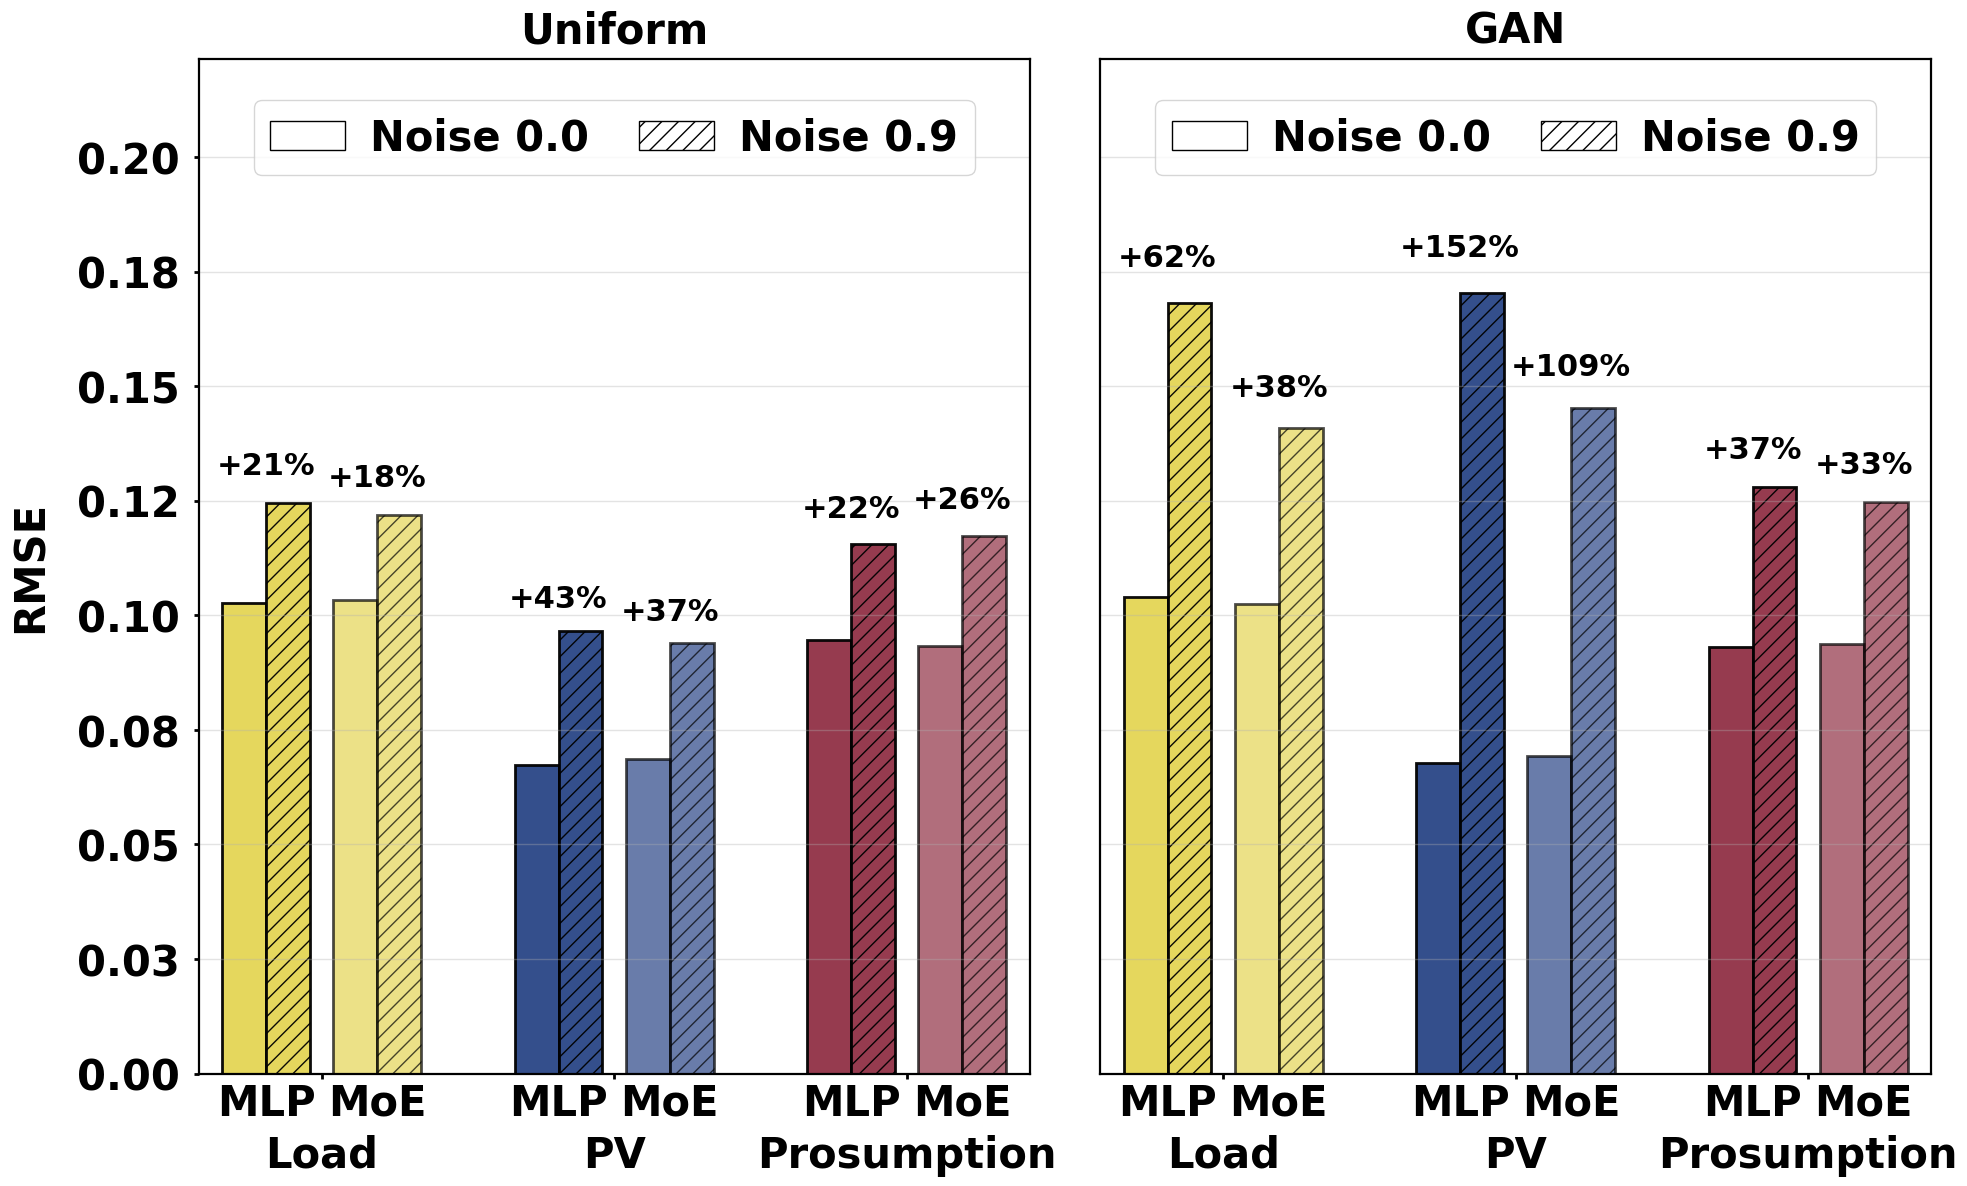

,source,energy,model,metric,value_0,value_9,abs_change,rel_change_pct,gap_at_0_moe_minus_mlp,gap_at_9_moe_minus_mlp,gap_at_9_pct_of_mlp,n_buildings_0,n_buildings_9,best_model_at_9
0,Uniform,Load,MLP,RMSE,0.102797,0.124530,0.021734,21.142510,0.000465,-0.002577,-2.069471,20,20,SoftDenseMoE
1,Uniform,Load,SoftDenseMoE,RMSE,0.103262,0.121953,0.018691,18.101066,0.000465,-0.002577,-2.069471,20,20,SoftDenseMoE
2,Uniform,PV,MLP,RMSE,0.067430,0.096668,0.029239,43.362019,0.001316,-0.002713,-2.806057,20,20,SoftDenseMoE
3,Uniform,PV,SoftDenseMoE,RMSE,0.068746,0.093956,0.025210,36.670872,0.001316,-0.002713,-2.806057,20,20,SoftDenseMoE
4,Uniform,Prosumption,MLP,RMSE,0.094693,0.115474,0.020780,21.945030,-0.001412,0.001933,1.673942,20,20,MLP
5,Uniform,Prosumption,SoftDenseMoE,RMSE,0.093281,0.117407,0.024125,25.863072,-0.001412,0.001933,1.673942,20,20,MLP
6,GAN,Load,MLP,RMSE,0.104001,0.168081,0.064080,61.614636,-0.001535,-0.027140,-16.147139,20,20,SoftDenseMoE
7,GAN,Load,SoftDenseMoE,RMSE,0.102466,0.140941,0.038474,37.548462,-0.001535,-0.027140,-16.147139,20,20,SoftDenseMoE
8,GAN,PV,MLP,RMSE,0.067679,0.170321,0.102642,151.659845,0.001733,-0.024995,-14.675295,20,20,SoftDenseMoE
9,GAN,PV,SoftDenseMoE,RMSE,0.069412,0.145326,0.075914,109.367617,0.001733,-0.024995,-14.675295,20,20,SoftDenseMoE


In [ ]:
def plot_dp_arch_bars_0_vs_9(
    results_dir="results3",
    energy_map=ENERGY_MAP_DEFAULT,
    metric="mse"
):
    """
    Two subplots [Uniform (noise) | GAN]. Groups = energy types.
    Each group: MLP vs SoftDenseMoE; each model has bars at Noise 0.0 (plain) and Noise 0.9 (hatched).
    Shared y-axis, large fonts, extra headroom. Returns a summary DataFrame for analysis.
    """
    metric = metric.lower().strip()
    if metric not in {"mse", "rmse", "mae"}:
        raise ValueError("metric must be 'mse', 'rmse', or 'mae'")

    import os
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from matplotlib.patches import Patch
    from matplotlib.ticker import FormatStrFormatter

    def per_arch_mean(df):
        # equal weight per (building, arch)
        g = _per_building_arch_mean(df, metric)
        return g.groupby("arch_norm")["m"].mean()

    fig, axes = plt.subplots(1, 2, figsize=(20, 12), sharey=True)
    archs = ["MLP", "SoftDenseMoE"]
    x_groups = np.arange(len(energy_map))      # group centers (per energy)
    width_cluster = 0.38                       # spacing between MLP and Soft inside a group
    bar_width = 0.15                           # width of each bar (0.0 and 0.9)

    # Model alphas: MLP more opaque, MoE more transparent
    ALPHA_MLP = 0.95
    ALPHA_MOE = 0.70

    global_ymax = 0.0
    summary_rows = []

    for i, (ax, source) in enumerate(zip(axes, ["noise", "gan"])):
        minor_pos, minor_labels = [], []
        source_label = "Uniform" if source == "noise" else "GAN"

        for gi, (energy, eid) in enumerate(energy_map.items()):
            d0 = _read_poison_df(results_dir, energy, eid, source, 0.0, metric)
            d9 = _read_poison_df(results_dir, energy, eid, source, 0.9, metric)
            if d0 is None or d9 is None or d0.empty or d9.empty:
                continue

            m0 = per_arch_mean(d0)
            m9 = per_arch_mean(d9)

            # values per model
            y0_mlp = float(m0.get("MLP", np.nan))
            y9_mlp = float(m9.get("MLP", np.nan))
            y0_moe = float(m0.get("SoftDenseMoE", np.nan))
            y9_moe = float(m9.get("SoftDenseMoE", np.nan))

            # model gaps (MoE - MLP)
            gap0 = (y0_moe - y0_mlp) if np.isfinite(y0_mlp) and np.isfinite(y0_moe) else np.nan
            gap9 = (y9_moe - y9_mlp) if np.isfinite(y9_mlp) and np.isfinite(y9_moe) else np.nan
            gap9_pct_of_mlp = (gap9 / y9_mlp * 100.0) if np.isfinite(gap9) and y9_mlp > 0 else np.nan

            n_b0 = int(d0["building"].nunique()) if "building" in d0.columns else np.nan
            n_b9 = int(d9["building"].nunique()) if "building" in d9.columns else np.nan

            # rows for MLP and MoE
            for model, y0, y9 in [("MLP", y0_mlp, y9_mlp), ("SoftDenseMoE", y0_moe, y9_moe)]:
                abs_change = (y9 - y0) if np.isfinite(y0) and np.isfinite(y9) else np.nan
                rel_change = (abs_change / y0 * 100.0) if np.isfinite(abs_change) and y0 > 0 else np.nan
                summary_rows.append({
                    "source": source_label,
                    "energy": energy,
                    "model": model,
                    "metric": metric.upper(),
                    "value_0": y0,
                    "value_9": y9,
                    "abs_change": abs_change,
                    "rel_change_pct": rel_change,
                    "gap_at_0_moe_minus_mlp": gap0,
                    "gap_at_9_moe_minus_mlp": gap9,
                    "gap_at_9_pct_of_mlp": gap9_pct_of_mlp,
                    "n_buildings_0": n_b0,
                    "n_buildings_9": n_b9,
                    "best_model_at_9": ("MLP" if y9_mlp < y9_moe else "SoftDenseMoE") if np.isfinite(y9_mlp) and np.isfinite(y9_moe) else None,
                })

            # --- plotting
            for ai, arch in enumerate(archs):
                x_center = x_groups[gi] + (ai - 0.5) * width_cluster
                y0 = float(m0.get(arch, np.nan))
                y9 = float(m9.get(arch, np.nan))
                alpha_use = ALPHA_MLP if arch == "MLP" else ALPHA_MOE

                if np.isfinite(y0):
                    ax.bar(x_center - bar_width/2, y0, width=bar_width,
                           color=ENERGY_COLORS[energy], edgecolor="black", linewidth=2.0,
                           alpha=alpha_use)
                    global_ymax = max(global_ymax, y0)
                if np.isfinite(y9):
                    ax.bar(x_center + bar_width/2, y9, width=bar_width,
                           color=ENERGY_COLORS[energy], edgecolor="black", linewidth=2.0,
                           hatch="//", alpha=alpha_use)
                    global_ymax = max(global_ymax, y9)

                if np.isfinite(y0) and y0 != 0 and np.isfinite(y9):
                    pct = (y9 - y0) / y0 * 100.0
                    ax.text(x_center, max(y0, y9) * 1.04, f"{pct:+.0f}%", ha="center",
                            va="bottom", fontsize=22, fontweight="bold")

                minor_pos.append(x_center)
                minor_labels.append("MLP" if arch == "MLP" else "MoE")

        # X ticks (energy groups)
        ax.set_xticks(x_groups)
        ax.set_xticklabels(list(energy_map.keys()), fontsize=30, fontweight="bold")
        ax.tick_params(axis='x', which='major', pad=40, labelsize=26)

        if minor_pos:
            ax.set_xticks(minor_pos, minor=True)
            ax.set_xticklabels(minor_labels, minor=True, fontsize=22, fontweight="bold")
            ax.tick_params(axis='x', which='minor', pad=6, length=0)

        if i == 0:
            ax.set_ylabel(metric.upper(), fontsize=30, fontweight="bold", labelpad=18)
            ax.tick_params(axis='y', which='major', pad=10, labelsize=26)
        else:
            ax.set_ylabel("")
            ax.tick_params(left=False, labelleft=False)

        ax.set_title("Uniform" if source == "noise" else "GAN",
                     fontsize=30, fontweight="bold", pad=12)

        _apply_journal_style(ax)
        ax.margins(x=0.03, y=0.03)

        scale_handles = [
            Patch(facecolor="white", edgecolor="black", label="Noise 0.0"),
            Patch(facecolor="white", edgecolor="black", hatch="//", label="Noise 0.9"),
        ]
        leg = ax.legend(handles=scale_handles, loc="upper center",
                        bbox_to_anchor=(0.5, 0.98), ncol=2, frameon=True, fontsize=30,
                        handlelength=1.8, handletextpad=0.6, columnspacing=1.2)
        if leg:
            for txt in leg.get_texts():
                txt.set_fontweight('bold')

        if metric == "rmse":
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    if global_ymax > 0:
        upper = global_ymax * 1.30
        for ax in axes:
            ax.set_ylim(0, upper)

    plt.tight_layout(pad=1.2)
    os.makedirs("figures2", exist_ok=True)
    out_name = "MLP_v_MOE_Bars_Poison.pdf"
    plt.savefig(os.path.join("figures2", out_name), format="pdf", bbox_inches="tight")
    plt.show()

    # --- return summary for analysis
    return pd.DataFrame(summary_rows)

summary_df = plot_dp_arch_bars_0_vs_9(metric="rmse")
display(summary_df)

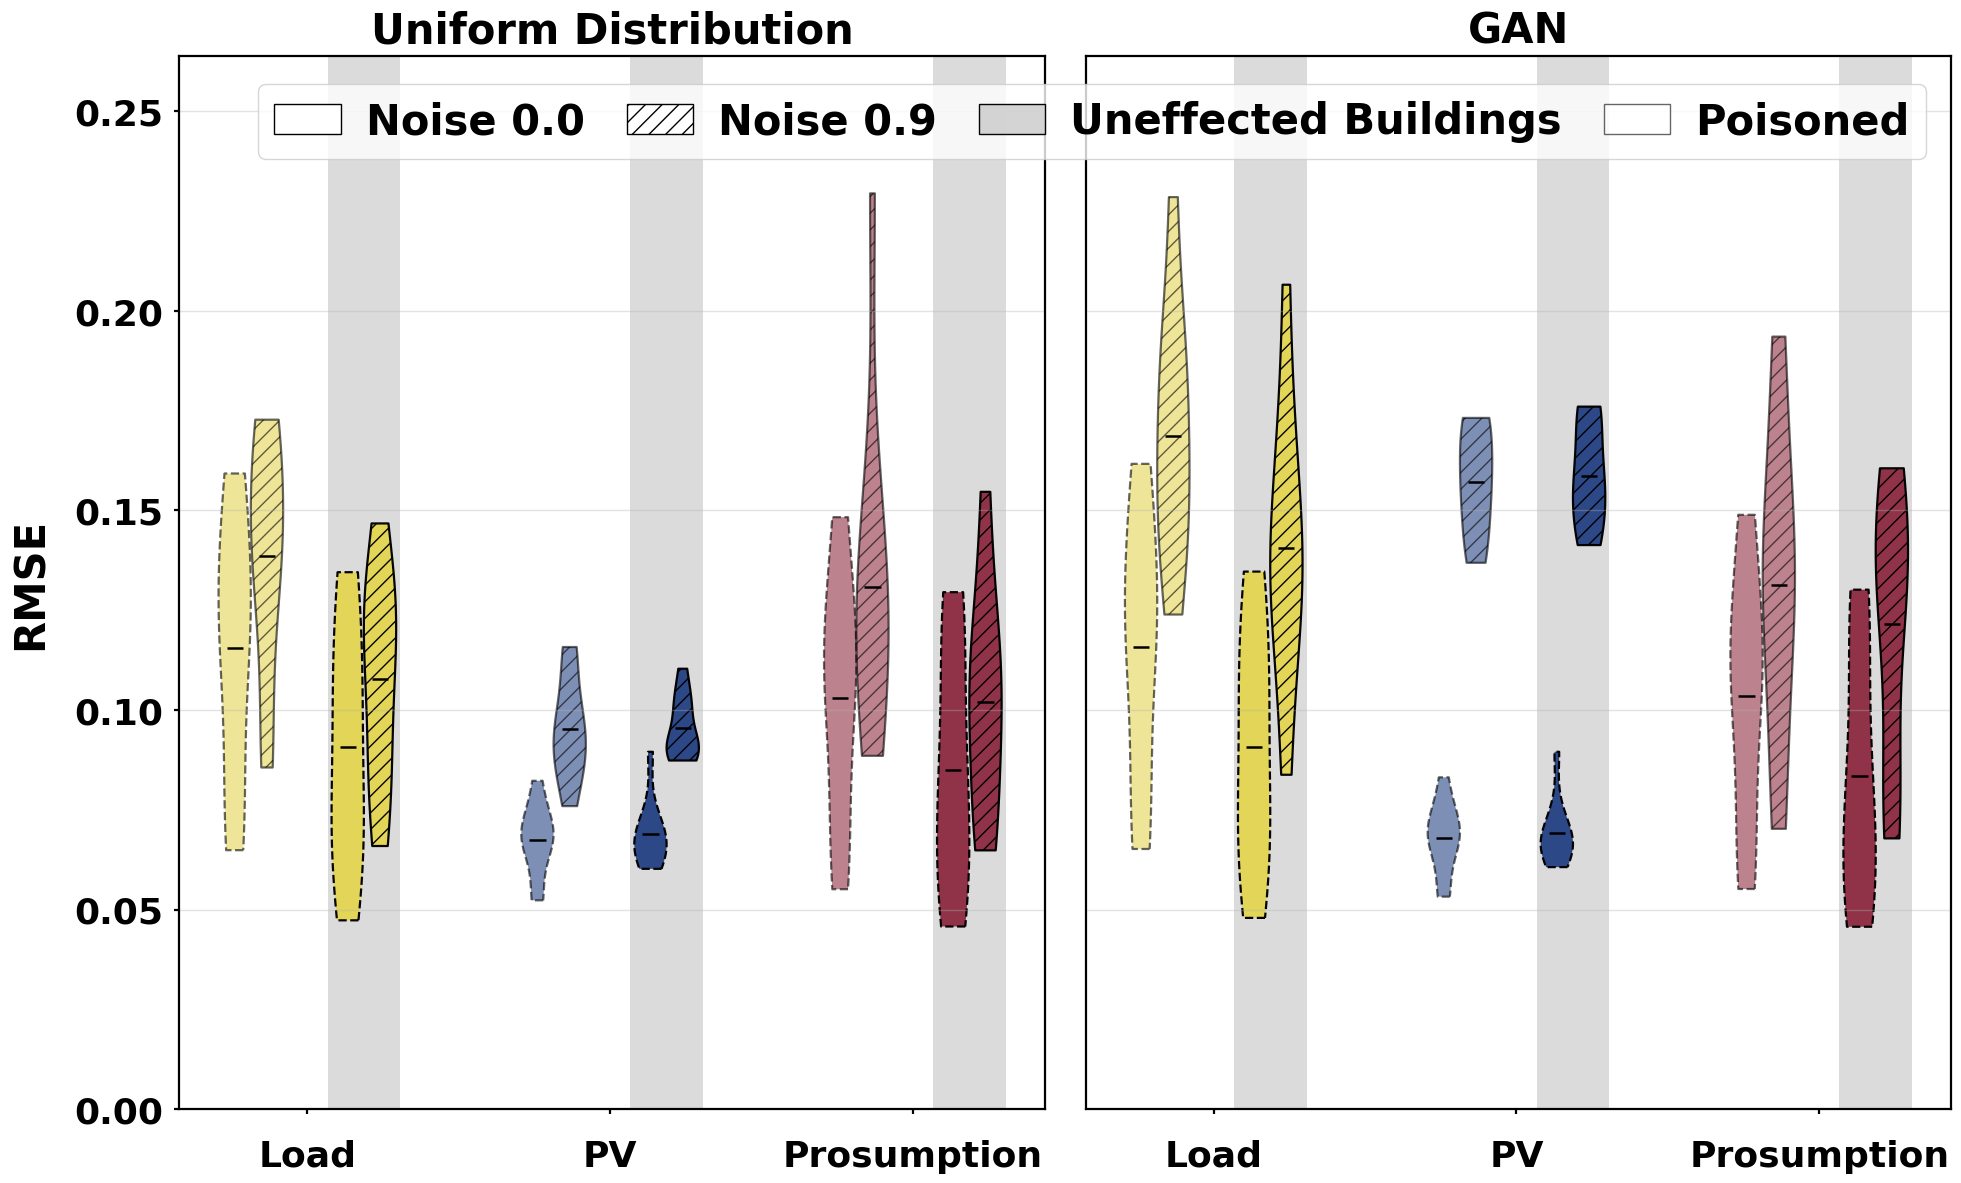

,source,energy,status,metric,scale_low,scale_high,n_buildings_low,n_buildings_high,n_buildings_paired,mean_low,...,median_low,median_high,mean_abs_change,mean_rel_change_pct,median_rel_change_pct,fraction_degraded,pearson_r,lin_slope,lin_intercept,r_squared
0,Uniform Distribution,Load,Unpoisoned,RMSE,0.0,0.9,10,10,10,0.115407,...,0.119836,0.145025,0.023235,24.334686,18.894391,0.9,0.790243,0.713630,0.056284,0.624484
1,Uniform Distribution,Load,Poisoned,RMSE,0.0,0.9,10,10,10,0.090652,...,0.088857,0.112227,0.017190,23.088954,17.603729,0.9,0.953951,0.805658,0.034808,0.910023
2,Uniform Distribution,PV,Unpoisoned,RMSE,0.0,0.9,10,10,10,0.067310,...,0.068369,0.093580,0.027898,41.718229,39.178614,1.0,0.930564,1.301485,0.007605,0.865949
3,Uniform Distribution,PV,Poisoned,RMSE,0.0,0.9,10,10,10,0.068865,...,0.068118,0.091423,0.026551,39.306166,40.435131,1.0,0.818184,0.746766,0.043990,0.669424
4,Uniform Distribution,Prosumption,Unpoisoned,RMSE,0.0,0.9,10,10,10,0.102971,...,0.108888,0.125253,0.027859,29.954748,24.577868,0.9,0.815307,1.078351,0.019792,0.664725
5,Uniform Distribution,Prosumption,Poisoned,RMSE,0.0,0.9,10,10,10,0.085004,...,0.082035,0.103145,0.017046,24.283471,20.002634,0.9,0.953814,0.872503,0.027884,0.909760
6,GAN,Load,Unpoisoned,RMSE,0.0,0.9,10,10,10,0.115677,...,0.118362,0.165210,0.052860,53.087353,37.997333,1.0,0.755671,0.709200,0.086499,0.571038
7,GAN,Load,Poisoned,RMSE,0.0,0.9,10,10,10,0.090790,...,0.090538,0.134688,0.049694,68.145576,42.167393,1.0,0.343753,0.388013,0.105257,0.118166
8,GAN,PV,Unpoisoned,RMSE,0.0,0.9,10,10,10,0.067883,...,0.068322,0.158779,0.089185,133.594822,137.224912,1.0,0.626574,0.933667,0.093688,0.392595
9,GAN,PV,Poisoned,RMSE,0.0,0.9,10,10,10,0.069208,...,0.068005,0.157701,0.089372,130.985256,133.447999,1.0,0.340193,0.544905,0.120868,0.115731


In [ ]:
def plot_violin_scales_by_poison(
    results_dir="results3",
    energy_map=None,               # defaults to {"Load":91,"PV":92,"Prosumption":93}
    metric="rmse",                 # one of {"mse","rmse","mae"}
    scales=(0.0, 0.9),             # compare these two scales
    figsize=(20, 12),
    save_path=None,                # e.g., "figures2/Violin_ScalesByPoison_RMSE.pdf"
):
    """
    Violin plots comparing N0.0 vs N0.9 for both Unpoisoned and Poisoned users, grouped by energy.
    Left subplot: Uniform Distribution (noise), Right subplot: GAN. Shared y-axis.
    Also RETURNS a summary pandas.DataFrame with per-building paired statistics.
    """
    # ---------- local imports (standalone)
    import os
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from matplotlib.patches import Patch
    from matplotlib.ticker import FormatStrFormatter

    # ---------- defaults
    if energy_map is None:
        energy_map = {"Load": 91, "PV": 92, "Prosumption": 93}

    ENERGY_COLORS = {"Load": "#E4D554", "PV": "#294586", "Prosumption": "#903045"}

    # ---------- helpers (scoped inside)
    def _scale_token(x: float) -> str:
        return f"{x:.1f}".replace(".", "p")

    def _mid_for(source: str) -> str:
        return "NoiseScale" if source == "noise" else "GanScale"

    def _poison_path(results_dir: str, eid: int, energy: str, source: str, scale: float) -> str:
        return os.path.join(
            results_dir,
            f"{eid}{energy}_Poison_{_mid_for(source)}_{_scale_token(scale)}_Attack_all_results.csv"
        )

    def _normalize_arch(col: pd.Series) -> pd.Series:
        s = col.astype(str).str.strip().str.lower()
        return np.where(s.str.contains("soft"), "SoftDenseMoE", "MLP")

    def _poison_mask(df: pd.DataFrame) -> pd.Series:
        b = df.get("building")
        p_b = df.get("poisoned_building")
        if b is None or p_b is None:
            return pd.Series(False, index=df.index)
        p_u_col = next((c for c in ["poisoned_user_key", "poisoned_user"] if c in df.columns), None)
        if p_u_col and ("user_key" in df.columns):
            lhs = b.astype(str).str.strip() + "||" + df["user_key"].astype(str).str.strip()
            rhs = df["poisoned_building"].astype(str).str.strip() + "||" + df[p_u_col].astype(str).str.strip()
            return lhs == rhs
        return b.astype(str).str.strip() == p_b.astype(str).str.strip()

    def _read_df(results_dir: str, energy: str, eid: int, source: str, scale: float, metric: str):
        path = _poison_path(results_dir, eid, energy, source, scale)
        if not os.path.exists(path):
            return None
        df = pd.read_csv(path)
        if metric not in df.columns:
            return None
        df["arch_norm"] = _normalize_arch(df["architecture"]) if "architecture" in df.columns else "MLP"
        if "building" not in df.columns:
            return None
        df["building"] = df["building"].astype(str).str.strip()
        df["is_poisoned"] = _poison_mask(df)
        return df

    def _per_building_arch_mean(df: pd.DataFrame, metric: str) -> pd.DataFrame:
        if df is None or df.empty:
            return pd.DataFrame(columns=["building", "arch_norm", "m"])
        g = (df.groupby(["building", "arch_norm"], as_index=False)[metric]
               .mean()
               .rename(columns={metric: "m"}))
        return g

    def _per_building_mean_over_arch(g: pd.DataFrame) -> pd.DataFrame:
        if g is None or g.empty:
            return pd.DataFrame(columns=["building", "m_building"])
        b = (g.groupby("building", as_index=False)["m"].mean()
               .rename(columns={"m": "m_building"}))
        return b

    def _paired_stats(df0, df1, mask_val, energy, source_label):
        """Compute paired per-building stats between s0 and s1 for a given cohort."""
        if df0 is None or df1 is None or df0.empty or df1.empty:
            return None

        def vals(df, mask):
            sub = df.loc[mask]
            if sub.empty: 
                return pd.DataFrame(columns=["building","m"])
            g = _per_building_arch_mean(sub, metric)
            b = _per_building_mean_over_arch(g)
            return b.rename(columns={"m_building":"m"})

        b0 = vals(df0, df0["is_poisoned"] == mask_val).rename(columns={"m":"m0"})
        b1 = vals(df1, df1["is_poisoned"] == mask_val).rename(columns={"m":"m1"})
        mrg = pd.merge(b0, b1, on="building", how="inner")

        row = {
            "source": source_label,
            "energy": energy,
            "status": "Poisoned" if mask_val else "Unpoisoned",
            "metric": metric.upper(),
            "scale_low": float(scales[0]),
            "scale_high": float(scales[1]),
            "n_buildings_low": int(len(b0)),
            "n_buildings_high": int(len(b1)),
            "n_buildings_paired": int(len(mrg)),
            "mean_low": float(b0["m0"].mean()) if len(b0) else np.nan,
            "mean_high": float(b1["m1"].mean()) if len(b1) else np.nan,
            "std_low": float(b0["m0"].std(ddof=1)) if len(b0) > 1 else np.nan,
            "std_high": float(b1["m1"].std(ddof=1)) if len(b1) > 1 else np.nan,
            "median_low": float(b0["m0"].median()) if len(b0) else np.nan,
            "median_high": float(b1["m1"].median()) if len(b1) else np.nan,
            "mean_abs_change": np.nan,
            "mean_rel_change_pct": np.nan,
            "median_rel_change_pct": np.nan,
            "fraction_degraded": np.nan,
            "pearson_r": np.nan,
            "lin_slope": np.nan,
            "lin_intercept": np.nan,
            "r_squared": np.nan,
        }

        if len(mrg) >= 1:
            x = mrg["m0"].to_numpy(dtype=float)
            y = mrg["m1"].to_numpy(dtype=float)
            row["mean_abs_change"] = float(np.nanmean(y - x))
            row["mean_rel_change_pct"] = float(np.nanmean(((y - x) / x) * 100.0))
            row["median_rel_change_pct"] = float(np.nanmedian(((y - x) / x) * 100.0))
            row["fraction_degraded"] = float(np.mean(y > x))
            if len(mrg) >= 2 and np.all(np.isfinite(x)) and np.all(np.isfinite(y)):
                r = np.corrcoef(x, y)[0, 1]
                row["pearson_r"] = float(r)
                slope, intercept = np.polyfit(x, y, 1)
                row["lin_slope"] = float(slope)
                row["lin_intercept"] = float(intercept)
                row["r_squared"] = float(r ** 2)
        return row

    def _apply_journal_style(ax):
        ax.grid(True, axis="y", linewidth=1.0, alpha=0.35)
        for spine in ax.spines.values():
            spine.set_linewidth(1.6)
        ax.tick_params(axis='both', which='both', labelsize=26, width=1.6)
        for lbl in ax.get_xticklabels() + ax.get_yticklabels():
            lbl.set_fontweight('bold')

    # ---------- args
    metric = str(metric).lower().strip()
    if metric not in {"mse", "rmse", "mae"}:
        raise ValueError("metric must be one of {'mse','rmse','mae'}")
    s0, s1 = (float(scales[0]), float(scales[1]))

    sources = [("noise", "Uniform Distribution"), ("gan", "GAN")]

    # --- figure
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)
    energies = list(energy_map.keys())

    group_gap = 1.50
    positions = np.arange(1, len(energies) + 1) * group_gap

    main_off, sub_off = 0.28, 0.08
    width = 0.16
    pad_span = 0.02

    alpha_un, alpha_po = 0.60, 0.98

    global_max = None
    summary_rows = []

    for i, (ax, (source_key, src_label)) in enumerate(zip(axes, sources)):
        data = {e: {"un_s0": np.array([]), "un_s1": np.array([]),
                    "po_s0": np.array([]), "po_s1": np.array([])} for e in energies}

        for energy, eid in energy_map.items():
            df0 = _read_df(results_dir, energy, eid, source_key, s0, metric)
            df1 = _read_df(results_dir, energy, eid, source_key, s1, metric)

            # --- summary rows (paired per-building stats) for both cohorts
            for mask_val in (False, True):  # False=Unpoisoned, True=Poisoned
                row = _paired_stats(df0, df1, mask_val, energy, src_label)
                if row is not None:
                    summary_rows.append(row)

            # helper to get per-building arrays for violins
            def vals_for(df, mask):
                if df is None or df.empty:
                    return np.array([])
                sub = df.loc[mask]
                if sub.empty:
                    return np.array([])
                g = _per_building_arch_mean(sub, metric)
                b = _per_building_mean_over_arch(g)
                vals = pd.to_numeric(b["m_building"], errors="coerce").to_numpy()
                vals = vals[np.isfinite(vals)]
                return vals

            if df0 is not None:
                data[energy]["un_s0"] = vals_for(df0, df0["is_poisoned"] == False)
                data[energy]["po_s0"] = vals_for(df0, df0["is_poisoned"] == True)
            if df1 is not None:
                data[energy]["un_s1"] = vals_for(df1, df1["is_poisoned"] == False)
                data[energy]["po_s1"] = vals_for(df1, df1["is_poisoned"] == True)

            for k in ("un_s0","un_s1","po_s0","po_s1"):
                if data[energy][k].size:
                    vmax_local = float(np.nanmax(data[energy][k]))
                    global_max = vmax_local if global_max is None else max(global_max, vmax_local)

        # background shading: Poisoned region
        for p in positions:
            left_po  = (p + main_off - sub_off) - (width / 2) - pad_span
            right_po = (p + main_off + sub_off) + (width / 2) + pad_span
            ax.axvspan(left_po, right_po, facecolor="lightgrey", alpha=0.8, zorder=0)

        # draw violins
        for idx, energy in enumerate(energies):
            p = positions[idx]
            color = ENERGY_COLORS[energy]

            pos_un_s0 = p - main_off - sub_off
            pos_un_s1 = p - main_off + sub_off
            pos_po_s0 = p + main_off - sub_off
            pos_po_s1 = p + main_off + sub_off

            def draw_violin(vals, pos, alpha, hatch=False, dashed=False):
                if vals.size == 0:
                    return
                parts = ax.violinplot([vals], positions=[pos], widths=width,
                                      showmeans=True, showextrema=False, showmedians=False)
                for body in parts['bodies']:
                    body.set_facecolor(color)
                    body.set_edgecolor("black")
                    body.set_linewidth(1.6)
                    body.set_alpha(alpha)
                    if hatch:
                        try:
                            body.set_hatch("//")
                            body.set_alpha(alpha)
                        except Exception:
                            pass
                    if dashed:
                        body.set_linestyle("--")
                parts['cmeans'].set_color("black")
                parts['cmeans'].set_linewidth(1.8)

            draw_violin(data[energy]["un_s0"], pos_un_s0, alpha_un, hatch=False, dashed=True)
            draw_violin(data[energy]["un_s1"], pos_un_s1, alpha_un, hatch=True,  dashed=False)
            draw_violin(data[energy]["po_s0"], pos_po_s0, alpha_po, hatch=False, dashed=True)
            draw_violin(data[energy]["po_s1"], pos_po_s1, alpha_po, hatch=True,  dashed=False)

        ax.set_xticks(positions)
        ax.set_xticklabels(energies, fontsize=30, fontweight="bold")
        ax.tick_params(axis='x', which='major', pad=18, labelsize=26)

        ax.set_title(src_label, fontsize=30, fontweight="bold", pad=10)
        if i == 0:
            ax.set_ylabel(metric.upper(), fontsize=30, fontweight="bold", labelpad=16)
            ax.tick_params(axis='y', which='major', pad=8, labelsize=26)
            if metric == "rmse":
                ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        else:
            ax.set_ylabel("")
            ax.tick_params(left=False, labelleft=False)

        _apply_journal_style(ax)
        ax.margins(x=0.05, y=0.05)

    if global_max is not None and np.isfinite(global_max):
        upper = global_max * 1.15
        for ax in axes:
            ax.set_ylim(0, upper)

    # Legend (kept as in your current figure)
    scale_handles = [
        Patch(facecolor="white", edgecolor="black", hatch="",   label=f"Noise {s0:.1f}"),
        Patch(facecolor="white", edgecolor="black", hatch="//", label=f"Noise {s1:.1f}"),
    ]
    status_handles = [
        Patch(facecolor="lightgrey", edgecolor="black", alpha=0.98, label="Uneffected Buildings"),
        Patch(facecolor="white", edgecolor="black", alpha=0.60, label="Poisoned"),
    ]
    handles = scale_handles + status_handles
    leg = fig.legend(handles=handles, loc="upper center", bbox_to_anchor=(0.55, 0.94),
                     ncol=4, frameon=True, fontsize=30, handlelength=1.6,
                     handletextpad=0.6, columnspacing=1.0)
    if leg:
        for t in leg.get_texts():
            t.set_fontweight("bold")

    plt.tight_layout(pad=1.3)
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, format=os.path.splitext(save_path)[1][1:] or "pdf",
                    bbox_inches="tight")
    plt.show()

    # ---- return tidy summary
    return pd.DataFrame(summary_rows)

summary_df = plot_violin_scales_by_poison(metric="rmse",save_path="figures2/Violin_ScalesByPoison_RMSE_0p0_vs_0p9.pdf")
display(summary_df)

# Data Backdoor - GAN vs Noise

In [337]:
import os
import re
import numpy as np
import pandas as pd

def summarize_backdoor_unaffected_poisoned_times(
    results_dir="results3",
    energy_map={"Load": 91, "PV": 92, "Prosumption": 93},
    scales=(0.0, 0.3, 0.6, 0.9),
    attack_source="noise",          # "noise" | "gan"
    metric="rmse",                  # "mse" | "rmse" | "mae"
    label_prefix="N",               # keep "N" prefix for both sources
    poisoned_user_value="1",        # fallback name/key if file lacks explicit mask
    backdoor_start="10:30",
    backdoor_end="12:30",
):
    """
    Backdoor summary restricted to *poisoned time slots of UNAFFECTED entities*.

    Fixes applied:
      • Robust poisoned-user detection (is_poisoned, poisoned_user(_key), poisoned_building,
        fallback to 'poisoned_user_value' on user/user_key).
      • Robust unique entity id (building, or cluster_id||user, or user_key, or user).
      • Safe hour filtering on nullable Int64 ('isin').

    Aggregation (fair):
      (id,arch,hour)->mean  -> per (id,arch) mean across attacked hours
      -> per-id mean across architectures (equal weight)
      -> mean/std across ids; Diff% vs FL.
    """
    # ---- argument checks
    metric = str(metric).lower().strip()
    if metric not in {"mse", "rmse", "mae"}:
        raise ValueError("metric must be one of {'mse','rmse','mae'}")

    attack_source = str(attack_source).lower().strip()
    if attack_source not in {"noise", "gan"}:
        raise ValueError("attack_source must be 'noise' or 'gan'")

    MET = metric.upper()
    mid = "NoiseScale" if attack_source == "noise" else "GanScale"

    # ---- paths
    def _scale_token(x: float) -> str:
        return f"{x:.1f}".replace(".", "p")

    def _path(energy: str, eid: int, scale: float) -> str:
        return os.path.join(
            results_dir,
            f"{eid}{energy}_Backdoor_{mid}_{_scale_token(scale)}_Attack_per_hour_results.csv"
        )

    # ---- poisoned window: "10:30"–"12:30" -> hours {10, 11, 12}
    def _parse_hhmm(hhmm: str) -> int:
        m = re.match(r"^\s*(\d{1,2})(?::(\d{1,2}))?\s*$", str(hhmm))
        h = int(m.group(1)) if m else 0
        return max(0, min(23, h))

    start_h = _parse_hhmm(backdoor_start)
    end_h   = _parse_hhmm(backdoor_end)
    if end_h < start_h:
        POISONED_HOURS = set(list(range(start_h, 24)) + list(range(0, end_h + 1)))
    else:
        POISONED_HOURS = set(range(start_h, end_h + 1))

    # ---- helpers
    def _normalize_arch(col: pd.Series) -> pd.Series:
        s = col.astype(str).str.strip().str.lower()
        return np.where(s.str.contains("soft"), "SoftDenseMoE", "MLP")

    def _make_entity_id(df: pd.DataFrame) -> str:
        if "building" in df.columns:
            df["_entity_id"] = df["building"].astype(str).str.strip()
        elif "cluster_id" in df.columns and "user" in df.columns:
            df["_entity_id"] = df["cluster_id"].astype(str).str.strip() + "||" + df["user"].astype(str).str.strip()
        elif "cluster_index" in df.columns and "user" in df.columns:
            df["_entity_id"] = df["cluster_index"].astype(str).str.strip() + "||" + df["user"].astype(str).str.strip()
        elif "user_key" in df.columns:
            df["_entity_id"] = df["user_key"].astype(str).str.strip()
        elif "user" in df.columns:
            df["_entity_id"] = df["user"].astype(str).str.strip()
        else:
            df["_entity_id"] = "ALL"
        return "_entity_id"

    def _infer_poison_mask(df: pd.DataFrame) -> pd.Series:
        # explicit boolean
        if "is_poisoned" in df.columns:
            return df["is_poisoned"].astype(bool)

        # explicit id fields
        if "poisoned_user" in df.columns and "user" in df.columns:
            return df["user"].astype(str).str.strip().eq(df["poisoned_user"].astype(str).str.strip())
        if "poisoned_user_key" in df.columns and "user_key" in df.columns:
            return df["user_key"].astype(str).str.strip().eq(df["poisoned_user_key"].astype(str).str.strip())
        if "poisoned_building" in df.columns and "building" in df.columns:
            return df["building"].astype(str).str.strip().eq(df["poisoned_building"].astype(str).str.strip())

        # fallback to provided value on user/user_key
        val = str(poisoned_user_value).strip().lower()
        if "user_key" in df.columns:
            return df["user_key"].astype(str).str.strip().str.lower().eq(val)
        if "user" in df.columns:
            return df["user"].astype(str).str.strip().str.lower().eq(val)

        # last resort: no poison signal -> False
        return pd.Series(False, index=df.index)

    def _read(scale_path: str) -> pd.DataFrame | None:
        if not os.path.exists(scale_path):
            return None
        df = pd.read_csv(scale_path)
        if metric not in df.columns or "hour" not in df.columns:
            return None

        df = df.copy()
        df["hour"] = pd.to_numeric(df["hour"], errors="coerce").astype("Int64")
        df["arch_norm"] = _normalize_arch(df["architecture"]) if "architecture" in df.columns else "MLP"
        id_col = _make_entity_id(df)
        df[id_col] = df[id_col].astype(str).str.strip()
        df["_id_col"] = id_col
        df["is_poisoned"] = _infer_poison_mask(df)
        return df

    def _subset_unaffected_poisoned_hours(df: pd.DataFrame) -> pd.DataFrame:
        """Keep only UNPOISONED entities and hours inside the poisoned window."""
        if df is None or df.empty:
            return pd.DataFrame(columns=["_id", "arch_norm", "hour", metric])
        id_col = df["_id_col"].iloc[0]
        mask_unaffected = ~df["is_poisoned"].fillna(False)
        mask_hours = df["hour"].isin(POISONED_HOURS)
        sub = df.loc[mask_unaffected & mask_hours, [id_col, "arch_norm", "hour", metric]].copy()
        sub = sub.rename(columns={id_col: "_id"})
        return sub

    def _aggregate_one(df: pd.DataFrame) -> tuple[float, float]:
        """(id,arch,hour)->mean -> per (id,arch) -> per id -> population stats"""
        if df is None or df.empty:
            return (np.nan, np.nan)
        step1 = (df.groupby(["_id", "arch_norm", "hour"], as_index=False)[metric]
                   .mean().rename(columns={metric: "m_hour"}))
        if step1.empty: return (np.nan, np.nan)
        step2 = (step1.groupby(["_id", "arch_norm"], as_index=False)["m_hour"]
                       .mean().rename(columns={"m_hour": "m_id_arch"}))
        if step2.empty: return (np.nan, np.nan)
        per_id = (step2.groupby("_id", as_index=False)["m_id_arch"]
                        .mean().rename(columns={"m_id_arch": "m_id"}))
        vals = pd.to_numeric(per_id["m_id"], errors="coerce").to_numpy(dtype=float)
        vals = vals[np.isfinite(vals)]
        if vals.size == 0: return (np.nan, np.nan)
        mean_val = float(np.mean(vals))
        std_val  = float(np.std(vals, ddof=1)) if vals.size > 1 else np.nan
        return (mean_val, std_val)

    def _one_energy(energy: str, eid: int) -> pd.DataFrame:
        row_labels = ["FL"] + [f"{label_prefix}{s:.1f}" for s in scales if s != 0.0]
        out = pd.DataFrame(index=row_labels, columns=["RMSE", "STD", "Diff%"], dtype=float)

        rmse_by_row = {}
        for s in scales:
            path = _path(energy, eid, s)
            df   = _read(path)
            sub  = _subset_unaffected_poisoned_hours(df)
            mean_val, std_val = _aggregate_one(sub)
            row = "FL" if s == 0.0 else f"{label_prefix}{s:.1f}"
            out.loc[row, "RMSE"] = mean_val
            out.loc[row, "STD"]  = std_val
            rmse_by_row[row] = mean_val

        base = rmse_by_row.get("FL", np.nan)
        def _pct(val, base):
            return np.nan if (pd.isna(base) or base == 0 or pd.isna(val)) else (val - base) / base * 100.0
        for r in out.index:
            out.loc[r, "Diff%"] = _pct(out.loc[r, "RMSE"], base)

        out = out.astype(float)
        out["RMSE"]  = out["RMSE"].round(4)
        out["STD"]   = out["STD"].round(2)
        out["Diff%"] = out["Diff%"].round(2)
        return out

    return {energy: _one_energy(energy, eid) for energy, eid in energy_map.items()}

# ------------------ Example usage ------------------
# Uniform Distribution (Noise) backdoor summary:
bd_uniform = summarize_backdoor_unaffected_poisoned_times(
    attack_source="noise", metric="rmse",
    poisoned_user_value="1", backdoor_start="10:30", backdoor_end="12:30"
)
# GAN backdoor summary:
bd_gan = summarize_backdoor_unaffected_poisoned_times(
    attack_source="gan", metric="rmse",
    poisoned_user_value="1", backdoor_start="10:30", backdoor_end="12:30"
)

# Inspect, e.g.:
print(bd_uniform); print(bd_gan["PV"])


{'Load':         RMSE   STD  Diff%
FL    0.0689  0.03   0.00
N0.3  0.0757  0.03   9.80
N0.6  0.0785  0.03  13.82
N0.9  0.0787  0.03  14.22, 'PV':         RMSE   STD  Diff%
FL    0.1171  0.02   0.00
N0.3  0.1242  0.02   6.02
N0.6  0.1328  0.02  13.40
N0.9  0.1355  0.02  15.67, 'Prosumption':         RMSE   STD  Diff%
FL    0.0663  0.02   0.00
N0.3  0.0765  0.03  15.32
N0.6  0.0783  0.03  18.02
N0.9  0.0805  0.02  21.47}
        RMSE   STD  Diff%
FL    0.1169  0.02   0.00
N0.3  0.1411  0.02  20.66
N0.6  0.1635  0.03  39.78
N0.9  0.1738  0.03  48.60


C:\Users\rs1044\AppData\Local\Temp\ipykernel_14988\3363993811.py:270: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.02, 0.02, 0.98, 0.98])


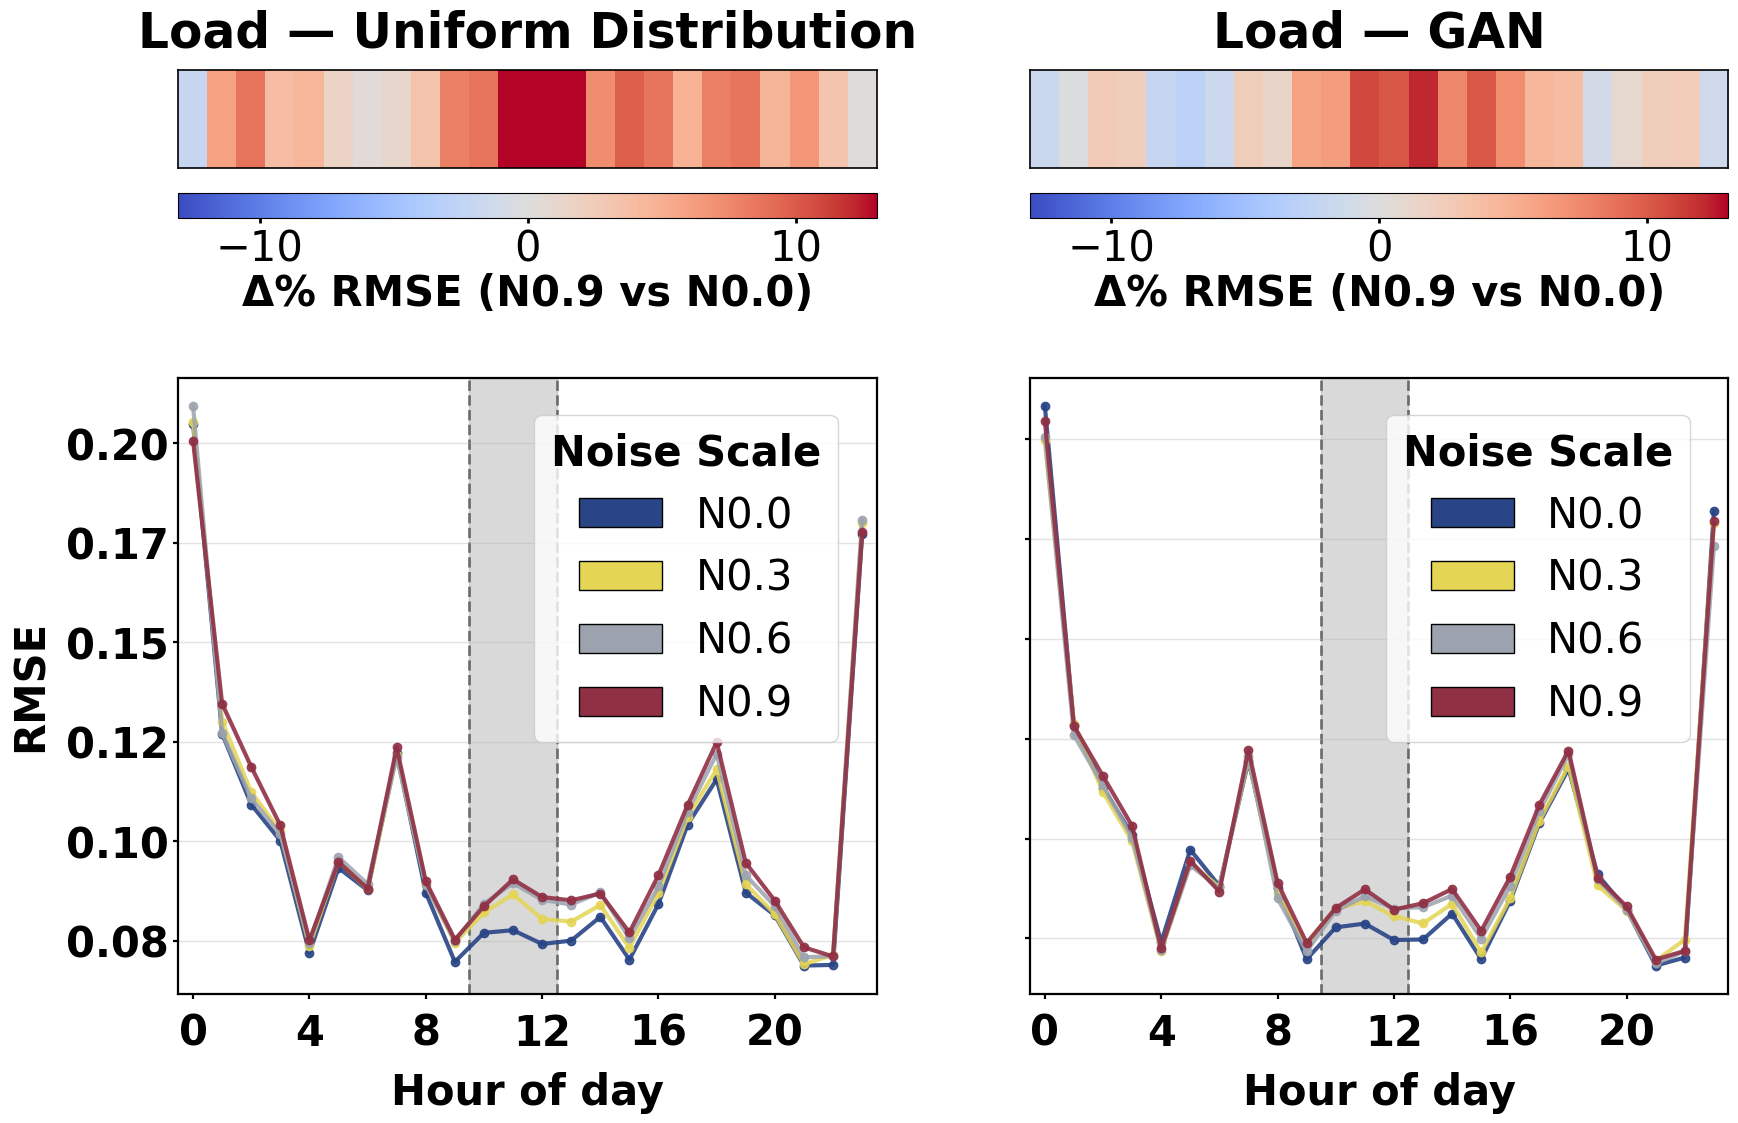

                 source  n_hours    mean_0    mean_9  mean_delta_overall  \
0  Uniform Distribution       24  0.096455  0.101678            6.304037   
1                   GAN       24  0.097623  0.100228            3.402982   

   mean_delta_poisoned  mean_delta_unpoisoned  frac_degraded_overall  \
0            13.664493               5.252543               0.958333   
1             9.118992               2.586409               0.708333   

   frac_degraded_poisoned  frac_degraded_unpoisoned  pearson_r  lin_slope  \
0                     1.0                  0.952381   0.994244   0.939952   
1                     1.0                  0.666667   0.995461   0.942672   

   lin_intercept  r_squared  
0       0.011015   0.988521  
1       0.008202   0.990943  


C:\Users\rs1044\AppData\Local\Temp\ipykernel_14988\3363993811.py:270: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.02, 0.02, 0.98, 0.98])


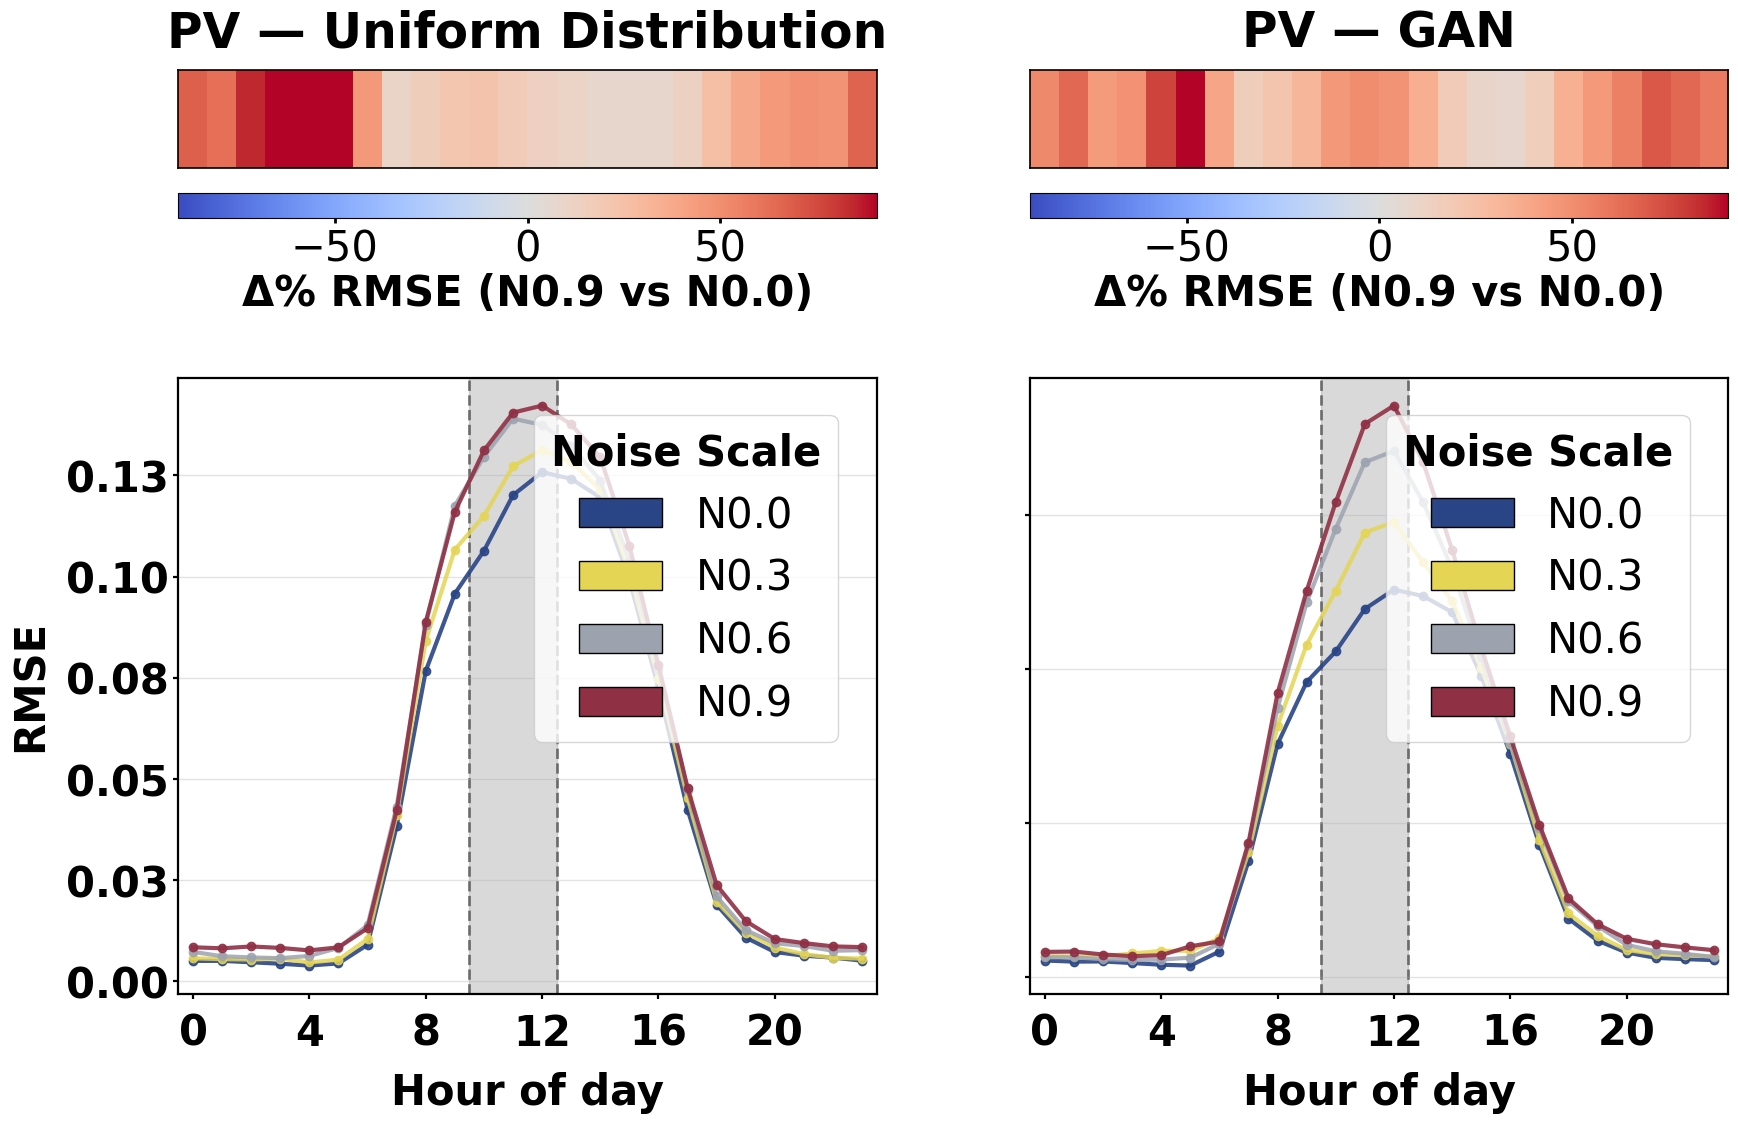

                 source  n_hours    mean_0    mean_9  mean_delta_overall  \
0  Uniform Distribution       24  0.046296  0.054133           39.896758   
1                   GAN       24  0.046201  0.061039           46.411530   

   mean_delta_poisoned  mean_delta_unpoisoned  frac_degraded_overall  \
0            17.787798              43.055181                    1.0   
1            47.850569              46.205953                    1.0   

   frac_degraded_poisoned  frac_degraded_unpoisoned  pearson_r  lin_slope  \
0                     1.0                       1.0   0.997852   1.113447   
1                     1.0                       1.0   0.987435   1.327014   

   lin_intercept  r_squared  
0       0.002585   0.995709  
1      -0.000270   0.975027  


C:\Users\rs1044\AppData\Local\Temp\ipykernel_14988\3363993811.py:270: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.02, 0.02, 0.98, 0.98])


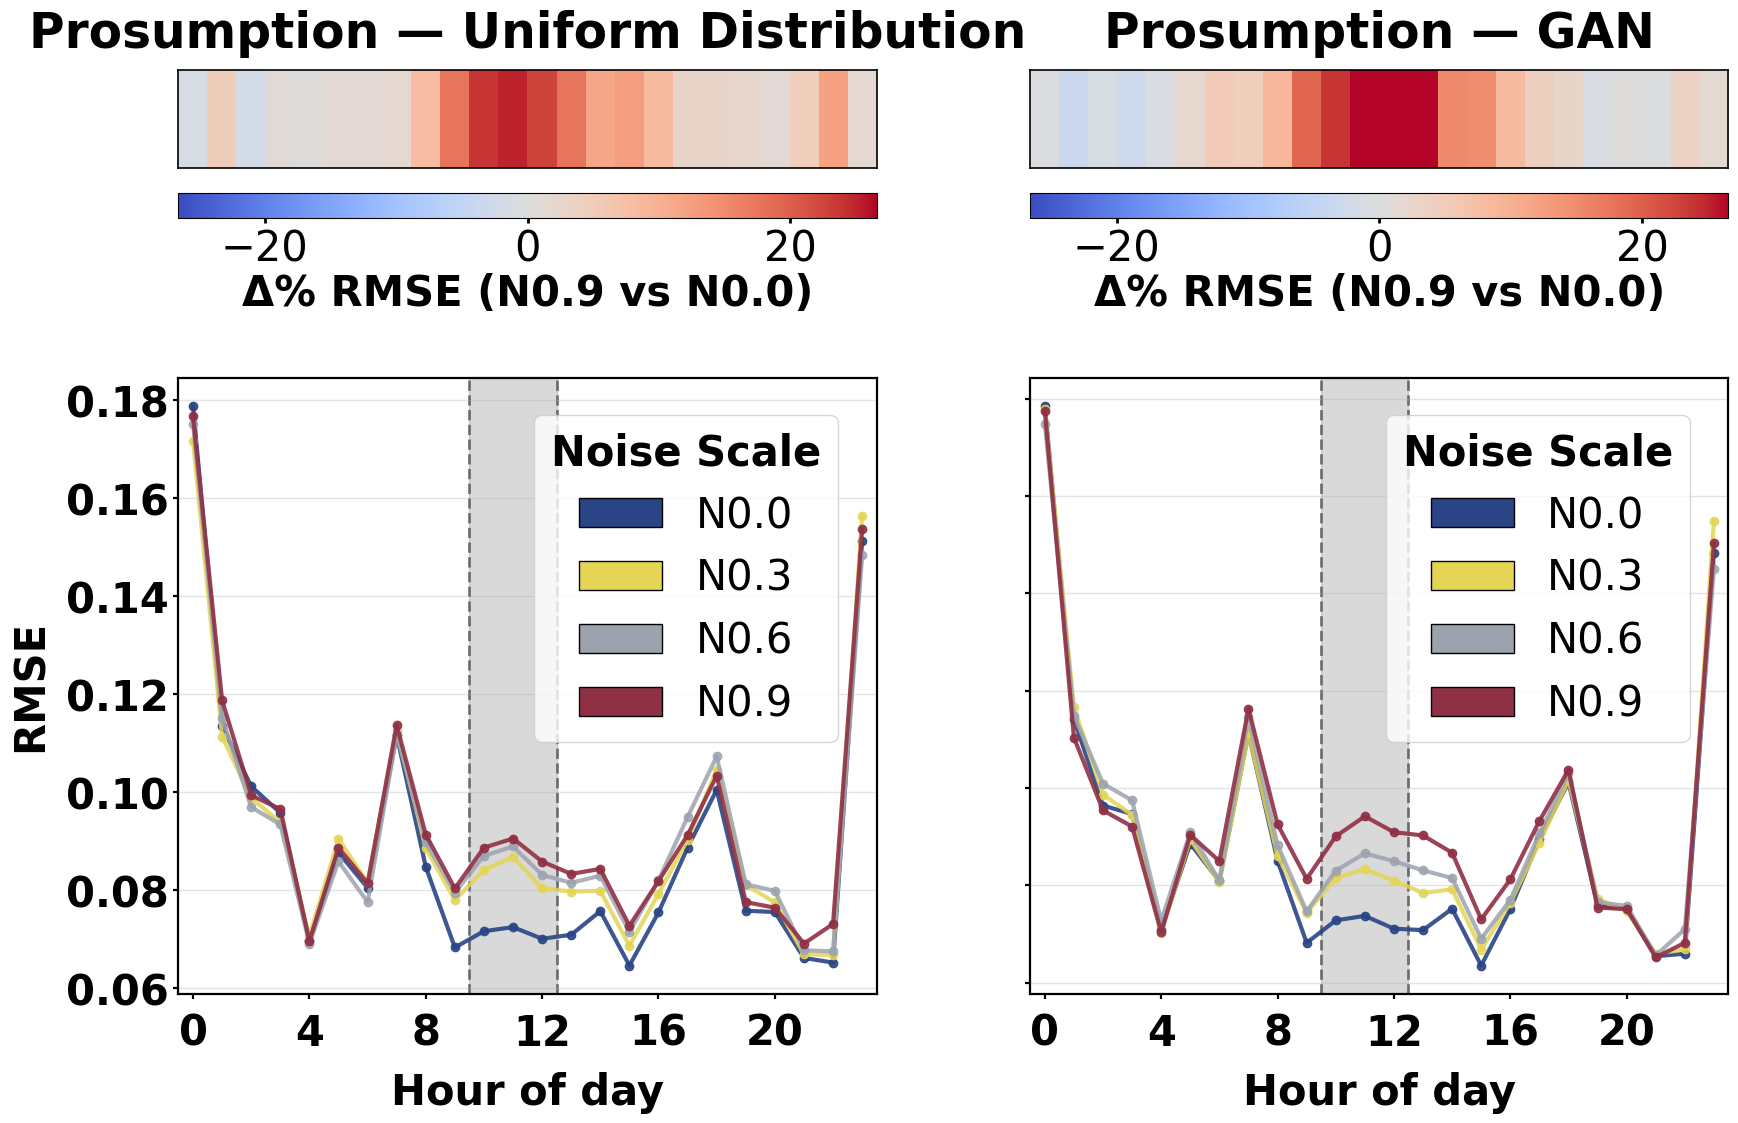

                 source  n_hours    mean_0    mean_9  mean_delta_overall  \
0  Uniform Distribution       24  0.088191  0.093710            7.521377   
1                   GAN       24  0.088034  0.093721            7.783770   

   mean_delta_poisoned  mean_delta_unpoisoned  frac_degraded_overall  \
0            23.740295               5.204388               0.916667   
1            26.437908               5.118893               0.708333   

   frac_degraded_poisoned  frac_degraded_unpoisoned  pearson_r  lin_slope  \
0                     1.0                  0.904762   0.979614   0.897320   
1                     1.0                  0.666667   0.962772   0.886519   

   lin_intercept  r_squared  
0       0.014574   0.959644  
1       0.015677   0.926930  


In [322]:
def plot_energy_hourly_lines_plus_delta(
    energy="Load",
    metric="rmse",
    results_dir="results3",
    energy_map=None,
    scales=(0.0, 0.3, 0.6, 0.9),
    figsize=(20, 12),
    cmap_name="coolwarm",
    robust_percentile=95,
    save_path=None,
    backdoor_start_time="10:30",
    backdoor_num_steps=3,   # 10:30–12:30 -> 3 hours (10, 11, 12)
    cohort="unaffected",    # "unaffected" or "poisoned"
    poisoned_user_name="user1",  # fallback when only `user` exists
):
    import os, re
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from matplotlib.patches import Patch
    import matplotlib.colors as mcolors
    from matplotlib.gridspec import GridSpec
    from matplotlib.ticker import FormatStrFormatter

    if energy_map is None:
        energy_map = {"Load": 91, "PV": 92, "Prosumption": 93}

    SCALE_COLORS = {0.0:"#294586", 0.3:"#E4D554", 0.6:"#9CA3AF", 0.9:"#903045"}
    SCALE_LABEL = lambda s: f"N{s:.1f}"

    energy = str(energy)
    if energy not in energy_map:
        raise ValueError(f"Unknown energy '{energy}'. Use one of {list(energy_map.keys())}.")
    metric = str(metric).lower().strip()
    if metric not in {"mse", "rmse", "mae"}:
        raise ValueError("metric must be one of {'mse','rmse','mae'}")
    if cohort not in {"unaffected", "poisoned"}:
        raise ValueError("cohort must be 'unaffected' or 'poisoned'")
    eid = energy_map[energy]

    def _parse_hhmm_to_hour_start(hhmm: str) -> int:
        m = re.match(r"^\s*(\d{1,2})(?::(\d{1,2}))?\s*$", str(hhmm))
        if not m: return 10
        return max(0, min(23, int(m.group(1))))

    def _poisoned_hours(start_time="10:30", steps=3) -> list[int]:
        h0 = _parse_hhmm_to_hour_start(start_time)
        return [(h0 + k) % 24 for k in range(int(steps))]

    def _segments_from_hours(hours_set: set[int]) -> list[tuple[int,int]]:
        if not hours_set: return []
        hrs = sorted({int(h) % 24 for h in hours_set})
        segs, start, prev = [], hrs[0], hrs[0]
        for h in hrs[1:]:
            if (prev + 1) % 24 == h: prev = h
            else: segs.append((start, prev)); start = prev = h
        segs.append((start, prev))
        if len(segs) > 1 and (segs[-1][1] + 1) % 24 == segs[0][0]:
            a = segs.pop(0); b = segs.pop(); segs.append((b[0], a[1]))
        return segs

    def _shade_poisoned(ax, poisoned_hours: set[int], facecolor="#444444", alpha=0.2, line_w=2.0):
        for a, b in _segments_from_hours(poisoned_hours):
            ax.axvspan(a - 0.5, b + 0.5, color=facecolor, alpha=alpha, zorder=0)
            ax.axvline(a - 0.5, color=facecolor, linewidth=line_w, alpha=0.7, linestyle="--", zorder=1)
            ax.axvline(b + 0.5, color=facecolor, linewidth=line_w, alpha=0.7, linestyle="--", zorder=1)

    def _scale_token(x: float) -> str: return f"{x:.1f}".replace(".", "p")
    def _mid_for(source: str) -> str: return "NoiseScale" if source == "noise" else "GanScale"
    def _path(source: str, scale: float) -> str:
        return os.path.join(results_dir, f"{eid}{energy}_Backdoor_{_mid_for(source)}_{_scale_token(scale)}_Attack_per_hour_results.csv")

    def _normalize_arch(col: pd.Series) -> pd.Series:
        s = col.astype(str).str.strip().str.lower()
        return np.where(s.str.contains("soft"), "SoftDenseMoE", "MLP")

    def _pick_id_col(df: pd.DataFrame) -> str:
        for cand in ["building", "user_key", "user", "cluster_id"]:
            if cand in df.columns: return cand
        df["_single_id"] = "ALL"; return "_single_id"

    def _compute_is_poisoned(df: pd.DataFrame) -> pd.Series:
        if "poisoned_user_key" in df.columns and "user_key" in df.columns:
            return df["user_key"].astype(str).str.strip() == df["poisoned_user_key"].astype(str).str.strip()
        if "poisoned_user" in df.columns and "user" in df.columns:
            return df["user"].astype(str).str.strip() == df["poisoned_user"].astype(str).str.strip()
        if "user" in df.columns:
            return df["user"].astype(str).str.strip().eq(str(poisoned_user_name))
        if "building" in df.columns and "poisoned_building" in df.columns:
            return df["building"].astype(str).str.strip() == df["poisoned_building"].astype(str).str.strip()
        return pd.Series(False, index=df.index)

    def _apply_journal_style(ax):
        ax.grid(True, axis="y", linewidth=1.0, alpha=0.35)
        for s in ax.spines.values(): s.set_linewidth(1.6)
        ax.tick_params(axis='both', which='both', labelsize=30, width=1.6)
        for lbl in ax.get_xticklabels() + ax.get_yticklabels(): lbl.set_fontweight('bold')

    # ---------- read + filter by cohort ----------
    def _read_hourly(source: str, scale: float) -> pd.DataFrame | None:
        p = _path(source, scale)
        if not os.path.exists(p): return None
        df = pd.read_csv(p)
        if "hour" not in df.columns or metric not in df.columns: return None
        df["hour"] = pd.to_numeric(df["hour"], errors="coerce")
        df["arch_norm"] = _normalize_arch(df["architecture"]) if "architecture" in df.columns else "MLP"
        id_col = _pick_id_col(df)
        df[id_col] = df[id_col].astype(str).str.strip()
        df["_id_col"] = id_col
        df["is_poisoned"] = _compute_is_poisoned(df)
        keep_mask = ~df["is_poisoned"] if cohort == "unaffected" else df["is_poisoned"]
        df = df.loc[keep_mask].copy()
        if df.empty: return None
        return df

    def _per_hour_equal_weight(df: pd.DataFrame) -> pd.DataFrame:
        if df is None or df.empty:
            return pd.DataFrame(columns=["hour", "mean_metric"])
        id_col = df["_id_col"].iloc[0]
        step1 = (df.groupby([id_col, "arch_norm", "hour"], as_index=False)[metric]
                   .mean().rename(columns={metric: "m_hour"}))
        step2 = (step1.groupby("hour", as_index=False)["m_hour"]
                       .mean().rename(columns={"m_hour": "mean_metric"}))
        return step2.sort_values("hour")

    def _delta_row(source: str) -> np.ndarray:
        d0 = _per_hour_equal_weight(_read_hourly(source, 0.0))
        d9 = _per_hour_equal_weight(_read_hourly(source, 0.9))
        if d0 is None or d9 is None or d0.empty or d9.empty:
            return np.full(24, np.nan)
        m = pd.merge(d0, d9, on="hour", how="inner", suffixes=("_0", "_9"))
        full = pd.DataFrame({"hour": np.arange(24)}).merge(m, on="hour", how="left")
        base = full["mean_metric_0"].to_numpy(dtype=float)
        val9 = full["mean_metric_9"].to_numpy(dtype=float)
        with np.errstate(divide="ignore", invalid="ignore"):
            delta = (val9 - base) / base * 100.0
        return delta

    # >>> MISSING BEFORE: add the helper used in the summary <<<
    def _summarize_hourly_series(d0: pd.DataFrame, d9: pd.DataFrame, poisoned_set: set[int]) -> dict:
        if d0 is None or d9 is None or d0.empty or d9.empty:
            return dict(
                n_hours=0, mean_0=np.nan, mean_9=np.nan,
                mean_delta_overall=np.nan, mean_delta_poisoned=np.nan, mean_delta_unpoisoned=np.nan,
                frac_degraded_overall=np.nan, frac_degraded_poisoned=np.nan, frac_degraded_unpoisoned=np.nan,
                pearson_r=np.nan, lin_slope=np.nan, lin_intercept=np.nan, r_squared=np.nan
            )
        m = pd.merge(d0, d9, on="hour", how="inner", suffixes=("_0", "_9")).sort_values("hour")
        base = m["mean_metric_0"].to_numpy(dtype=float)
        val9 = m["mean_metric_9"].to_numpy(dtype=float)
        hours = m["hour"].to_numpy(dtype=int)
        with np.errstate(divide="ignore", invalid="ignore"):
            delta = (val9 - base) / base * 100.0

        mask_ok = np.isfinite(delta)
        hours_ok = hours[mask_ok]
        delta_ok, base_ok, val9_ok = delta[mask_ok], base[mask_ok], val9[mask_ok]
        is_poisoned = np.isin(hours_ok, list(poisoned_set))
        is_clean = ~is_poisoned
        _mean = lambda x: float(np.nanmean(x)) if x.size else np.nan
        _frac_pos = lambda x: float(np.mean(x > 0)) if x.size else np.nan

        out = dict(
            n_hours=int(hours_ok.size),
            mean_0=_mean(base_ok),
            mean_9=_mean(val9_ok),
            mean_delta_overall=_mean(delta_ok),
            mean_delta_poisoned=_mean(delta_ok[is_poisoned]),
            mean_delta_unpoisoned=_mean(delta_ok[is_clean]),
            frac_degraded_overall=_frac_pos(delta_ok),
            frac_degraded_poisoned=_frac_pos(delta_ok[is_poisoned]),
            frac_degraded_unpoisoned=_frac_pos(delta_ok[is_clean]),
        )

        if base_ok.size >= 2 and np.all(np.isfinite(base_ok)) and np.all(np.isfinite(val9_ok)):
            try:
                r = np.corrcoef(base_ok, val9_ok)[0, 1]
                slope, intercept = np.polyfit(base_ok, val9_ok, 1)
                pred = slope * base_ok + intercept
                ss_res = np.sum((val9_ok - pred) ** 2)
                ss_tot = np.sum((val9_ok - np.mean(val9_ok)) ** 2)
                r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan
            except Exception:
                r, slope, intercept, r2 = np.nan, np.nan, np.nan, np.nan
        else:
            r, slope, intercept, r2 = np.nan, np.nan, np.nan, np.nan

        out.update(dict(pearson_r=float(r), lin_slope=float(slope),
                        lin_intercept=float(intercept), r_squared=float(r2)))
        return out
    # <<< end helper >>>

    # ---------- compute curves & deltas ----------
    sources = [("noise", "Uniform Distribution"), ("gan", "GAN")]
    curves = {src: {} for src, _ in sources}
    deltas = {}
    all_delta_vals = []
    POISONED = set(_poisoned_hours(backdoor_start_time, backdoor_num_steps))

    for src, _ in sources:
        for s in scales:
            curves[src][s] = _per_hour_equal_weight(_read_hourly(src, s))
        row = _delta_row(src)
        deltas[src] = row
        all_delta_vals.extend(row[np.isfinite(row)])

    if len(all_delta_vals) == 0:
        vmax_abs = 50.0
    else:
        q = np.nanpercentile(np.abs(all_delta_vals), robust_percentile)
        vmax_abs = q if np.isfinite(q) and q > 0 else 50.0
    vmin, vmax = -vmax_abs, vmax_abs
    cmap = plt.get_cmap(cmap_name)
    norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

    # ---------- figure ----------
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(nrows=2, ncols=2, height_ratios=[1, 2], wspace=0.22, hspace=0)

    legend_handles = [Patch(facecolor=SCALE_COLORS[s], edgecolor="black", label=SCALE_LABEL(s)) for s in scales]
    summaries = []

    for j, (src, title_txt) in enumerate(sources):
        ax_hm = fig.add_subplot(gs[0, j])
        arr = deltas[src].reshape(1, -1)
        im = ax_hm.imshow(arr, aspect="auto", cmap=cmap, norm=norm)
        ax_hm.set_xlim(-0.5, 23.5)
        ax_hm.set_yticks([])
        ax_hm.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
        cbar = fig.colorbar(im, ax=ax_hm, orientation="horizontal", pad=0.08, fraction=0.60, aspect=28)
        cbar.ax.tick_params(labelsize=30, width=2)
        cbar.ax.xaxis.set_ticks_position('bottom')
        cbar.ax.xaxis.set_label_position('bottom')
        cbar.set_label(f"Δ% {metric.upper()} (N0.9 vs N0.0)", fontsize=30, fontweight="bold", labelpad=2)
        ax_hm.set_title(f"{energy} — {title_txt}", fontsize=35, fontweight="bold", pad=16)
        for s in ax_hm.spines.values(): s.set_linewidth(1.2)

        ax_ln = fig.add_subplot(gs[1, j], sharex=ax_hm)
        drew = False
        for s in scales:
            ph = curves[src].get(s)
            if ph is None or ph.empty: continue
            drew = True
            ax_ln.plot(ph["hour"].values, ph["mean_metric"].values,
                       label=SCALE_LABEL(s), color=SCALE_COLORS[s],
                       linewidth=3.0, marker="o", markersize=6, alpha=0.90 if s in (0.0, 0.9) else 0.85)
        ax_ln.set_xlim(-0.5, 23.5)
        _shade_poisoned(ax_ln, POISONED)
        ax_ln.set_xticks(range(0, 24, 4))
        ax_ln.set_xlabel("Hour of day", fontsize=30, fontweight="bold", labelpad=12)
        if j == 0:
            ax_ln.set_ylabel(metric.upper(), fontsize=30, fontweight="bold", labelpad=10)
            if metric == "rmse":
                ax_ln.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        else:
            ax_ln.set_ylabel(""); ax_ln.tick_params(labelleft=False)
        _apply_journal_style(ax_ln)
        ax_ln.tick_params(axis='x', which='major', pad=10)

        if drew:
            leg = ax_ln.legend(handles=legend_handles, loc="upper right", bbox_to_anchor=(0.98, 0.98),
                               fontsize=30, frameon=True, title="Noise Scale", borderaxespad=0.6)
            if leg and leg.get_title():
                leg.get_title().set_fontsize(30); leg.get_title().set_fontweight("bold")

        d0 = _per_hour_equal_weight(_read_hourly(src, 0.0))
        d9 = _per_hour_equal_weight(_read_hourly(src, 0.9))
        summaries.append({"source": title_txt, **_summarize_hourly_series(d0, d9, set(POISONED))})

    plt.tight_layout(rect=[0.02, 0.02, 0.98, 0.98])

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        ext = os.path.splitext(save_path)[1][1:] or "pdf"
        plt.savefig(save_path, format=ext, bbox_inches="tight")
    plt.show()

    summary_df = pd.DataFrame(summaries, columns=[
        "source", "n_hours", "mean_0", "mean_9",
        "mean_delta_overall", "mean_delta_poisoned", "mean_delta_unpoisoned",
        "frac_degraded_overall", "frac_degraded_poisoned", "frac_degraded_unpoisoned",
        "pearson_r", "lin_slope", "lin_intercept", "r_squared"
    ])
    return {"curves": curves, "deltas": deltas, "vlim": (vmin, vmax), "summary": summary_df}

res = plot_energy_hourly_lines_plus_delta(
    energy="Load", metric="rmse",
    save_path="figures2/Hourly_LinesPlusDelta_Load_RMSE.pdf",
    backdoor_start_time="10:30", backdoor_num_steps=3
)
print(res["summary"])

res = plot_energy_hourly_lines_plus_delta(
    energy="PV", metric="rmse",
    save_path="figures2/Hourly_LinesPlusDelta_PV_RMSE.pdf",
    backdoor_start_time="10:30", backdoor_num_steps=3
)
print(res["summary"])

res = plot_energy_hourly_lines_plus_delta(
    energy="Prosumption", metric="rmse",
    save_path="figures2/Hourly_LinesPlusDelta_Prosumption_RMSE.pdf",
    backdoor_start_time="10:30", backdoor_num_steps=3
)
print(res["summary"])

C:\Users\rs1044\AppData\Local\Temp\ipykernel_14988\769463371.py:260: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.2)


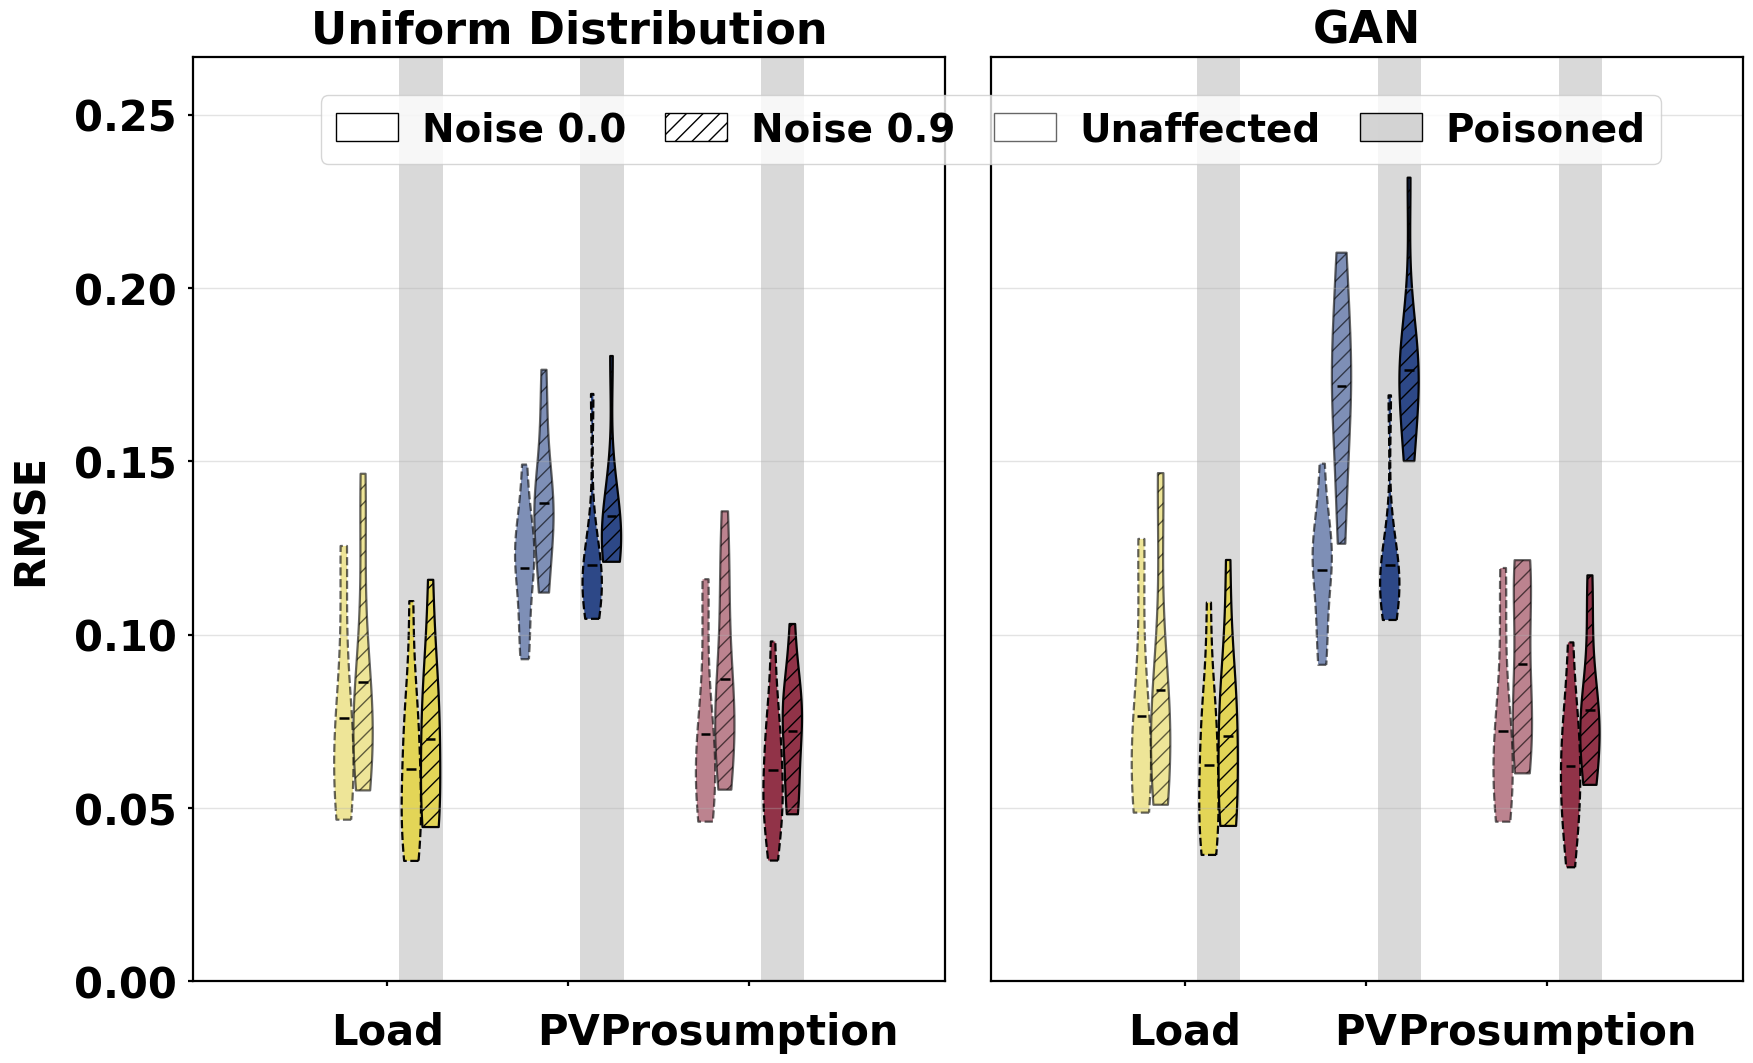

                  source       energy      status  n_ids_paired  mean_low  \
0   Uniform Distribution         Load  Unaffected            10  0.075937   
1   Uniform Distribution         Load    Poisoned            10  0.061207   
2   Uniform Distribution           PV  Unaffected            10  0.119133   
3   Uniform Distribution           PV    Poisoned            10  0.120187   
4   Uniform Distribution  Prosumption  Unaffected            10  0.071304   
5   Uniform Distribution  Prosumption    Poisoned            10  0.060948   
6                    GAN         Load  Unaffected            10  0.076439   
7                    GAN         Load    Poisoned            10  0.062333   
8                    GAN           PV  Unaffected            10  0.118686   
9                    GAN           PV    Poisoned            10  0.119969   
10                   GAN  Prosumption  Unaffected            10  0.072136   
11                   GAN  Prosumption    Poisoned            10  0.061949   

In [335]:
def plot_bd_violins_poisoned_hours(
    results_dir="results3",
    energy_map=None,
    metric="rmse",
    scales=(0.0, 0.9),
    figsize=(20, 12),
    save_path=None,
    backdoor_start_time="10:30",
    backdoor_num_steps=3,
    cohort="both",                   # "both" | "poisoned" | "unpoisoned"
    poisoned_user_name="user1"       # used if file lacks explicit poisoned user
):
    import os, re
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from matplotlib.patches import Patch
    from matplotlib.ticker import FormatStrFormatter

    if energy_map is None:
        energy_map = {"Load": 91, "PV": 92, "Prosumption": 93}

    ENERGY_COLORS = {"Load": "#E4D554", "PV": "#294586", "Prosumption": "#903045"}

    # ---------- paths & utils ----------
    def _scale_token(x: float) -> str: return f"{x:.1f}".replace(".", "p")
    def _mid_for(source: str) -> str:  return "NoiseScale" if source == "noise" else "GanScale"
    def _bd_path(results_dir: str, eid: int, energy: str, source: str, scale: float) -> str:
        return os.path.join(results_dir, f"{eid}{energy}_Backdoor_{_mid_for(source)}_{_scale_token(scale)}_Attack_per_hour_results.csv")

    def _normalize_arch(col: pd.Series) -> pd.Series:
        s = col.astype(str).str.strip().str.lower()
        return np.where(s.str.contains("soft"), "SoftDenseMoE", "MLP")

    # ---------- robust poisoned mask (prevents undercount) ----------
    def _infer_poison_mask(df: pd.DataFrame) -> pd.Series:
        if "is_poisoned" in df.columns:
            return df["is_poisoned"].astype(bool)
        if "poisoned_user" in df.columns and "user" in df.columns:
            return df["user"].astype(str).str.strip().eq(df["poisoned_user"].astype(str).str.strip())
        if "poisoned_user_key" in df.columns and "user_key" in df.columns:
            return df["user_key"].astype(str).str.strip().eq(df["poisoned_user_key"].astype(str).str.strip())
        if "building" in df.columns and "poisoned_building" in df.columns:
            return df["building"].astype(str).str.strip().eq(df["poisoned_building"].astype(str).str.strip())
        if "user" in df.columns:
            return df["user"].astype(str).str.strip().str.lower().eq(str(poisoned_user_name).lower())
        return pd.Series(False, index=df.index)

    # ---------- robust entity id (prevents collapsing multiple users) ----------
    def _make_entity_id(df: pd.DataFrame) -> str:
        if "building" in df.columns:
            df["_entity_id"] = df["building"].astype(str).str.strip()
        elif "cluster_id" in df.columns and "user" in df.columns:
            df["_entity_id"] = df["cluster_id"].astype(str).str.strip() + "||" + df["user"].astype(str).str.strip()
        elif "cluster_index" in df.columns and "user" in df.columns:
            df["_entity_id"] = df["cluster_index"].astype(str).str.strip() + "||" + df["user"].astype(str).str.strip()
        elif "user_key" in df.columns:
            df["_entity_id"] = df["user_key"].astype(str).str.strip()
        elif "user" in df.columns:
            df["_entity_id"] = df["user"].astype(str).str.strip()
        else:
            df["_entity_id"] = "ALL"
        return "_entity_id"

    def _parse_hhmm_to_hour_start(hhmm: str) -> int:
        m = re.match(r"^\s*(\d{1,2})(?::(\d{1,2}))?\s*$", str(hhmm))
        return max(0, min(23, int(m.group(1)))) if m else 10

    def _poisoned_hours(start_time="10:30", steps=3) -> set[int]:
        h0 = _parse_hhmm_to_hour_start(start_time)
        return {(h0 + k) % 24 for k in range(int(steps))}

    POISONED_HOURS = _poisoned_hours(backdoor_start_time, backdoor_num_steps)

    def _read_bd_df(results_dir: str, energy: str, eid: int, source: str, scale: float, metric: str):
        p = _bd_path(results_dir, eid, energy, source, scale)
        if not os.path.exists(p): return None
        df = pd.read_csv(p)
        if ("hour" not in df.columns) or (metric not in df.columns): return None

        df["arch_norm"] = _normalize_arch(df["architecture"]) if "architecture" in df.columns else "MLP"
        id_col = _make_entity_id(df)
        df[id_col] = df[id_col].astype(str).str.strip()
        df["_id_col"] = id_col
        df["hour"] = pd.to_numeric(df["hour"], errors="coerce").astype("Int64")
        df["is_poisoned"] = _infer_poison_mask(df)

        # keep ONLY attacked hours
        df = df[df["hour"].isin(list(POISONED_HOURS))]
        return df

    # ---------- aggregate to one value per entity: MEAN over attacked hours ----------
    def _per_id_arch_mean_over_poisoned_hours(df: pd.DataFrame, metric: str) -> pd.DataFrame:
        if df is None or df.empty:
            return pd.DataFrame(columns=["id_val", "m_entity"])
        id_col = df["_id_col"].iloc[0]
        # (id, arch, hour) -> mean, then mean across hours per (id,arch), then mean across arch per id
        step1 = (df.groupby([id_col, "arch_norm", "hour"], as_index=False)[metric]
                   .mean().rename(columns={metric: "m_hour"}))
        step2 = (step1.groupby([id_col, "arch_norm"], as_index=False)["m_hour"]
                      .mean().rename(columns={"m_hour": "m_id_arch"}))
        step3 = (step2.groupby(id_col, as_index=False)["m_id_arch"]
                      .mean().rename(columns={id_col: "id_val", "m_id_arch": "m_entity"}))
        return step3

    # ---------- paired stats for summary ----------
    def _paired_stats_backdoor(df0, df1, cohort_mask, energy, source_label):
        if df0 is None or df1 is None or df0.empty or df1.empty:
            return None

        def bvals(df, mask):
            sub = df.loc[df["is_poisoned"] == mask]
            if sub.empty: return pd.DataFrame(columns=["id_val", "m0"])
            return _per_id_arch_mean_over_poisoned_hours(sub, metric)

        b0 = bvals(df0, cohort_mask).rename(columns={"m_entity": "m0"})
        b1 = bvals(df1, cohort_mask).rename(columns={"m_entity": "m1"})
        mrg = pd.merge(b0, b1, on="id_val", how="inner")

        row = {
            "source": source_label, "energy": energy,
            "status": "Poisoned" if cohort_mask else "Unaffected",
            "metric": metric.upper(),
            "scale_low": float(scales[0]), "scale_high": float(scales[1]),
            "n_ids_low": int(len(b0)), "n_ids_high": int(len(b1)),
            "n_ids_paired": int(len(mrg)),
            "mean_low": float(b0["m0"].mean()) if len(b0) else np.nan,
            "mean_high": float(b1["m1"].mean()) if len(b1) else np.nan,
        }
        if len(mrg) >= 1:
            x = mrg["m0"].to_numpy(float); y = mrg["m1"].to_numpy(float)
            with np.errstate(divide="ignore", invalid="ignore"):
                rel = (y - x) / x * 100.0
            row.update(dict(
                mean_abs_change=float(np.nanmean(y - x)),
                mean_rel_change_pct=float(np.nanmean(rel)),
                median_rel_change_pct=float(np.nanmedian(rel)),
                fraction_degraded=float(np.mean(y > x)),
            ))
        return row

    def _apply_journal_style(ax):
        ax.grid(True, axis="y", linewidth=1.0, alpha=0.35)
        for spine in ax.spines.values(): spine.set_linewidth(1.6)
        ax.tick_params(axis='both', which='both', labelsize=30, width=1.6)  # 30 as requested
        for lbl in ax.get_xticklabels() + ax.get_yticklabels(): lbl.set_fontweight('bold')

    # ---------- validation ----------
    metric = str(metric).lower().strip()
    if metric not in {"mse", "rmse", "mae"}: raise ValueError("metric must be one of {'mse','rmse','mae'}")
    s0, s1 = (float(scales[0]), float(scales[1]))

    cohort = str(cohort).lower().strip()
    if cohort not in {"both", "poisoned", "unpoisoned"}:
        raise ValueError("cohort must be 'both', 'poisoned', or 'unpoisoned'")
    show_poisoned   = (cohort in {"both", "poisoned"})
    show_unpoisoned = (cohort in {"both", "unpoisoned"})

    sources = [("noise", "Uniform Distribution"), ("gan", "GAN")]
    energies = list(energy_map.keys())

    # ---------- figure ----------
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True,
                             gridspec_kw={'wspace': 0.06})  # tighter between panels
    group_gap = 1.50
    positions = np.arange(1, len(energies) + 1) * group_gap
    main_off, sub_off, width, pad_span = 0.28, 0.08, 0.16, 0.02
    alpha_un, alpha_po = 0.60, 0.98

    global_max = None
    summary_rows = []

    for i, (ax, (source_key, src_label)) in enumerate(zip(axes, sources)):

        # grey background behind the Poisoned pair in every energy group
        if show_poisoned:
            for p in positions:
                left_po  = (p + main_off - sub_off) - (width / 2) - pad_span
                right_po = (p + main_off + sub_off) + (width / 2) + pad_span
                ax.axvspan(left_po, right_po, facecolor="lightgrey", alpha=0.85, zorder=0)

        for idx, energy in enumerate(energies):
            eid = energy_map[energy]
            df0 = _read_bd_df(results_dir, energy, eid, source_key, s0, metric)
            df1 = _read_bd_df(results_dir, energy, eid, source_key, s1, metric)

            # summary rows for both cohorts (using attacked-hours means)
            for cohort_mask in (False, True):
                if (cohort_mask and not show_poisoned) or ((not cohort_mask) and not show_unpoisoned):
                    continue
                row = _paired_stats_backdoor(df0, df1, cohort_mask, energy, src_label)
                if row is not None: summary_rows.append(row)

            def vals_for(df, cohort_mask):
                if df is None or df.empty: return np.array([])
                if (cohort_mask and not show_poisoned) or ((not cohort_mask) and not show_unpoisoned): return np.array([])
                sub = df.loc[df["is_poisoned"] == cohort_mask]
                if sub.empty: return np.array([])
                b = _per_id_arch_mean_over_poisoned_hours(sub, metric)  # MEAN over attacked hours only
                arr = pd.to_numeric(b["m_entity"], errors="coerce").to_numpy()
                return arr[np.isfinite(arr)]

            p = positions[idx]
            pos_un_s0, pos_un_s1 = p - main_off - sub_off, p - main_off + sub_off
            pos_po_s0, pos_po_s1 = p + main_off - sub_off, p + main_off + sub_off
            color = ENERGY_COLORS[energy]

            def draw_violin(vals, pos, alpha, hatch=False, dashed=False):
                if vals.size == 0: return
                parts = ax.violinplot([vals], positions=[pos], widths=width,
                                      showmeans=True, showextrema=False, showmedians=False)
                for body in parts['bodies']:
                    body.set_facecolor(color); body.set_edgecolor("black")
                    body.set_linewidth(1.6); body.set_alpha(alpha)
                    if hatch: body.set_hatch("//")
                    if dashed: body.set_linestyle("--")
                parts['cmeans'].set_color("black"); parts['cmeans'].set_linewidth(1.8)

            if show_unpoisoned:
                draw_violin(vals_for(df0, False), pos_un_s0, alpha_un, hatch=False, dashed=True)   # Noise 0.0
                draw_violin(vals_for(df1, False), pos_un_s1, alpha_un, hatch=True,  dashed=False)  # Noise 0.9
            if show_poisoned:
                draw_violin(vals_for(df0, True),  pos_po_s0, alpha_po, hatch=False, dashed=True)
                draw_violin(vals_for(df1, True),  pos_po_s1, alpha_po, hatch=True,  dashed=False)

            # track y max for shared limit
            for arr in (vals_for(df0, False), vals_for(df1, False), vals_for(df0, True), vals_for(df1, True)):
                if arr.size: global_max = max(global_max or 0.0, float(np.nanmax(arr)))

        # cosmetics
        ax.set_xticks(positions); ax.set_xticklabels(energies, fontsize=30, fontweight="bold")
        ax.tick_params(axis='x', which='major', pad=18)
        ax.set_title(src_label, fontsize=32, fontweight="bold", pad=10)
        if i == 0:
            ax.set_ylabel(metric.upper(), fontsize=30, fontweight="bold", labelpad=16)
            ax.tick_params(axis='y', which='major', pad=8)
            if metric == "rmse": ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        else:
            ax.set_ylabel(""); ax.tick_params(left=False, labelleft=False)

        _apply_journal_style(ax); ax.margins(x=0.3, y=0.05)

    if global_max is not None and np.isfinite(global_max):
        for ax in axes: ax.set_ylim(0, global_max * 1.15)

    # legend
    handles = [
        Patch(facecolor="white", edgecolor="black", hatch="",   label=f"Noise {s0:.1f}"),
        Patch(facecolor="white", edgecolor="black", hatch="//", label=f"Noise {s1:.1f}")
    ]
    handles.append(Patch(facecolor="white",     edgecolor="black", alpha=0.60, label="Unaffected"))
    handles.append(Patch(facecolor="lightgrey", edgecolor="black", alpha=0.98, label="Poisoned"))

    leg = plt.legend(handles=handles, loc="upper center", bbox_to_anchor=(0.0, 0.98),
                     ncol=len(handles), frameon=True, fontsize=28, handlelength=1.6,
                     handletextpad=0.6, columnspacing=1.0)
    if leg:
        for t in leg.get_texts(): t.set_fontweight("bold")

    plt.tight_layout(pad=1.2)
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        ext = os.path.splitext(save_path)[1][1:] or "pdf"
        plt.savefig(save_path, format=ext, bbox_inches="tight")
    plt.show()

    return pd.DataFrame(summary_rows)

summary_both = plot_bd_violins_poisoned_hours(
    metric="rmse",
    backdoor_start_time="10:30",
    backdoor_num_steps=4,           # e.g., 10–13 inclusive if 4 steps
    cohort="both",                  # show BOTH cohorts
    poisoned_user_name="user1",
    save_path="figures2/Violin_Backdoor_PoisonedHours_RMSE_both.pdf"
)
print(summary_both[["source","energy","status","n_ids_paired","mean_low","mean_high"]])


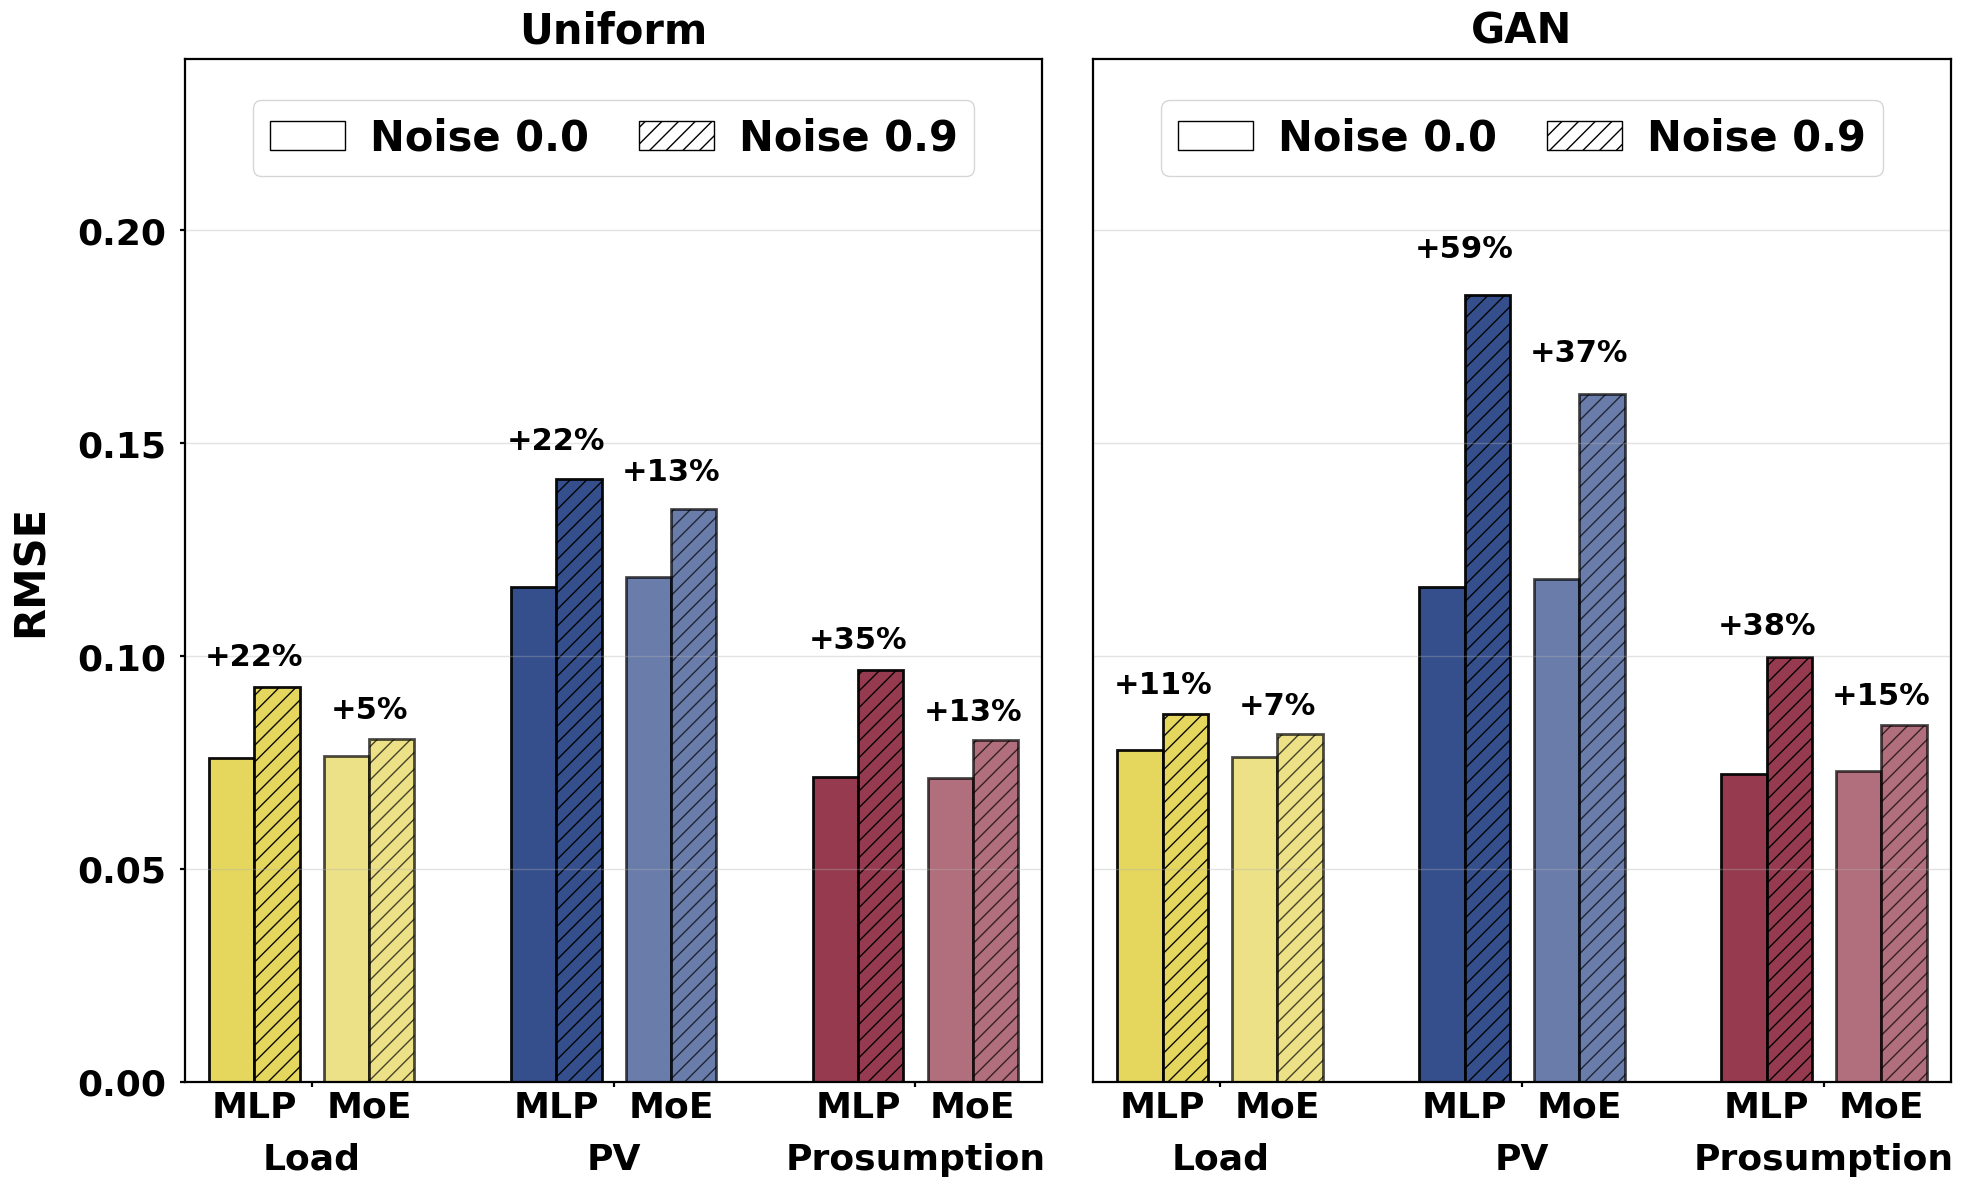

,source,energy,model,cohort,metric,value_0,value_9,abs_change,rel_change_pct,gap_at_0_moe_minus_mlp,gap_at_9_moe_minus_mlp,gap_at_9_pct_of_mlp,n_ids_0,n_ids_9,best_model_at_9
0,Uniform,Load,MLP,unaffected,RMSE,0.076100,0.092730,0.016630,21.852977,0.000298,-0.012154,-13.106623,1,1,SoftDenseMoE
1,Uniform,Load,SoftDenseMoE,unaffected,RMSE,0.076398,0.080576,0.004178,5.469370,0.000298,-0.012154,-13.106623,1,1,SoftDenseMoE
2,Uniform,PV,MLP,unaffected,RMSE,0.116273,0.141513,0.025240,21.707288,0.002352,-0.007027,-4.965490,1,1,SoftDenseMoE
3,Uniform,PV,SoftDenseMoE,unaffected,RMSE,0.118625,0.134486,0.015861,13.370433,0.002352,-0.007027,-4.965490,1,1,SoftDenseMoE
4,Uniform,Prosumption,MLP,unaffected,RMSE,0.071582,0.096577,0.024994,34.916898,-0.000317,-0.016374,-16.954483,1,1,SoftDenseMoE
5,Uniform,Prosumption,SoftDenseMoE,unaffected,RMSE,0.071265,0.080202,0.008938,12.541345,-0.000317,-0.016374,-16.954483,1,1,SoftDenseMoE
6,GAN,Load,MLP,unaffected,RMSE,0.077770,0.086432,0.008662,11.138064,-0.001518,-0.004809,-5.563572,1,1,SoftDenseMoE
7,GAN,Load,SoftDenseMoE,unaffected,RMSE,0.076253,0.081624,0.005371,7.043685,-0.001518,-0.004809,-5.563572,1,1,SoftDenseMoE
8,GAN,PV,MLP,unaffected,RMSE,0.116090,0.184758,0.068668,59.150162,0.001843,-0.023342,-12.633660,1,1,SoftDenseMoE
9,GAN,PV,SoftDenseMoE,unaffected,RMSE,0.117933,0.161416,0.043483,36.871199,0.001843,-0.023342,-12.633660,1,1,SoftDenseMoE


In [323]:
def plot_bd_arch_bars_0_vs_9_poisoned_hours(
    results_dir="results3",
    energy_map=None,                 # {"Load":91,"PV":92,"Prosumption":93}
    metric="mse",                    # {"mse","rmse","mae"}
    backdoor_start_time="10:30",     # attacked-window start
    backdoor_num_steps=3,            # attacked-window length in hours (10:30–12:30 -> 3 => {10,11,12})
    save_path="figures2/Backdoor_MLP_v_MOE_Bars_PoisonedHours.pdf",
    cohort="unaffected",             # <-- NEW: "unaffected" or "poisoned"
    poisoned_user_name="user1",      # <-- NEW: fallback if only `user` exists
):
    """
    Backdoor-only bars (poisoned hours subset) for the selected cohort:
      Two subplots [Uniform (noise) | GAN]. Groups = energy types.
      Each group shows MLP vs SoftDenseMoE; each model has bars at Noise 0.0 (plain) and Noise 0.9 (hatched).
      Values are per-architecture means computed **only over the attacked hours**,
      with equal weight per (ID, arch) across hours.
    Returns a summary DataFrame with per-energy/model values and deltas.
    """
    # ----------------- local imports -----------------
    import os, re
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from matplotlib.patches import Patch
    from matplotlib.ticker import FormatStrFormatter

    # ----------------- defaults -----------------
    if energy_map is None:
        energy_map = {"Load": 91, "PV": 92, "Prosumption": 93}
    ENERGY_COLORS = {"Load": "#E4D554", "PV": "#294586", "Prosumption": "#903045"}

    metric = metric.lower().strip()
    if metric not in {"mse", "rmse", "mae"}:
        raise ValueError("metric must be 'mse', 'rmse', or 'mae'")
    if cohort not in {"unaffected", "poisoned"}:
        raise ValueError("cohort must be 'unaffected' or 'poisoned'")

    # ----------------- helpers -----------------
    def _scale_token(x: float) -> str:
        return f"{x:.1f}".replace(".", "p")

    def _mid_for(source: str) -> str:
        return "NoiseScale" if source == "noise" else "GanScale"

    def _bd_path(results_dir: str, eid: int, energy: str, source: str, scale: float) -> str:
        # e.g. 91Load_Backdoor_NoiseScale_0p9_Attack_per_hour_results.csv
        return os.path.join(
            results_dir,
            f"{eid}{energy}_Backdoor_{_mid_for(source)}_{_scale_token(scale)}_Attack_per_hour_results.csv"
        )

    def _normalize_arch(col: pd.Series) -> pd.Series:
        s = col.astype(str).str.strip().str.lower()
        return np.where(s.str.contains("soft"), "SoftDenseMoE", "MLP")

    def _pick_id_col(df: pd.DataFrame) -> str:
        for cand in ["building", "user_key", "user", "cluster_id"]:
            if cand in df.columns:
                return cand
        df["_single_id"] = "ALL"
        return "_single_id"

    def _parse_hhmm_to_hour_start(hhmm: str) -> int:
        m = re.match(r"^\s*(\d{1,2})", str(hhmm))
        return max(0, min(23, int(m.group(1)))) if m else 10

    def _poisoned_hours(start_time="10:30", steps=3) -> set[int]:
        h0 = _parse_hhmm_to_hour_start(start_time)
        return { (h0 + k) % 24 for k in range(int(steps)) }

    POISONED_HOURS = _poisoned_hours(backdoor_start_time, backdoor_num_steps)

    def _normalize_hour_col(s: pd.Series) -> pd.Series:
        """Accepts 10, '10', '10.0', '10:00' -> Int64 hour."""
        st = s.astype(str)
        h = st.str.extract(r"(\d{1,2})", expand=False)
        h = pd.to_numeric(h, errors="coerce").clip(0, 23).astype("Int64")
        return h

    def _compute_is_poisoned(df: pd.DataFrame) -> pd.Series:
        # Priority: user_key, then user, then fallback to 'user1', or building fields if present.
        if "poisoned_user_key" in df.columns and "user_key" in df.columns:
            return df["user_key"].astype(str).str.strip() == df["poisoned_user_key"].astype(str).str.strip()
        if "poisoned_user" in df.columns and "user" in df.columns:
            return df["user"].astype(str).str.strip() == df["poisoned_user"].astype(str).str.strip()
        if "user" in df.columns:
            return df["user"].astype(str).str.strip().eq(str(poisoned_user_name))
        if "building" in df.columns and "poisoned_building" in df.columns:
            return df["building"].astype(str).str.strip() == df["poisoned_building"].astype(str).str.strip()
        return pd.Series(False, index=df.index)

    def _read_backdoor_df(results_dir: str, energy: str, eid: int, source: str, scale: float, metric: str):
        p = _bd_path(results_dir, eid, energy, source, scale)
        if not os.path.exists(p):
            return None
        df = pd.read_csv(p)
        if "hour" not in df.columns or metric not in df.columns:
            return None
        df["hour"] = _normalize_hour_col(df["hour"])
        # keep ONLY attacked hours
        df = df[df["hour"].isin(list(POISONED_HOURS))]
        if df.empty:
            return None
        # normalize fields
        df["arch_norm"] = _normalize_arch(df["architecture"]) if "architecture" in df.columns else "MLP"
        id_col = _pick_id_col(df)
        df[id_col] = df[id_col].astype(str).str.strip()
        df["_id_col"] = id_col
        # cohort filter
        df["is_poisoned"] = _compute_is_poisoned(df)
        keep = ~df["is_poisoned"] if cohort == "unaffected" else df["is_poisoned"]
        df = df.loc[keep].copy()
        if df.empty:
            return None
        return df

    def _per_arch_over_poisoned_hours(df: pd.DataFrame, metric: str) -> pd.Series:
        """
        Equal weight per (ID, arch) across attacked hours:
          (ID,arch,hour)->mean  -> mean across hours per (ID,arch) -> mean across IDs per arch.
        Returns Series indexed by arch_norm with values.
        """
        if df is None or df.empty:
            return pd.Series(dtype=float)
        id_col = df["_id_col"].iloc[0]
        step1 = (df.groupby([id_col, "arch_norm", "hour"], as_index=False)[metric]
                   .mean()
                   .rename(columns={metric: "m_hour"}))
        step2 = (step1.groupby([id_col, "arch_norm"], as_index=False)["m_hour"]
                      .mean()
                      .rename(columns={"m_hour": "m_id_arch"}))
        step3 = step2.groupby("arch_norm")["m_id_arch"].mean()
        return step3

    def _apply_journal_style(ax):
        ax.grid(True, axis="y", linewidth=1.0, alpha=0.35)
        for s in ax.spines.values():
            s.set_linewidth(1.6)
        ax.tick_params(axis='both', which='both', labelsize=26, width=1.6)
        for lbl in ax.get_xticklabels() + ax.get_yticklabels():
            lbl.set_fontweight('bold')

    # ----------------- plotting -----------------
    fig, axes = plt.subplots(1, 2, figsize=(20, 12), sharey=True)
    archs = ["MLP", "SoftDenseMoE"]
    x_groups = np.arange(len(energy_map))     # group centers per energy
    width_cluster = 0.38                      # spacing between MLP and MoE inside a group
    bar_width = 0.15                          # width of each bar (0.0 and 0.9)
    ALPHA_MLP, ALPHA_MOE = 0.95, 0.70

    global_ymax = 0.0
    summary_rows = []

    for i, (ax, source) in enumerate(zip(axes, ["noise", "gan"])):
        minor_pos, minor_labels = [], []
        source_label = "Uniform" if source == "noise" else "GAN"

        for gi, (energy, eid) in enumerate(energy_map.items()):
            d0 = _read_backdoor_df(results_dir, energy, eid, source, 0.0, metric)
            d9 = _read_backdoor_df(results_dir, energy, eid, source, 0.9, metric)
            if d0 is None or d9 is None or d0.empty or d9.empty:
                continue

            m0 = _per_arch_over_poisoned_hours(d0, metric)  # attacked hours only + cohort filtered
            m9 = _per_arch_over_poisoned_hours(d9, metric)

            # values per model
            y0_mlp = float(m0.get("MLP", np.nan))
            y9_mlp = float(m9.get("MLP", np.nan))
            y0_moe = float(m0.get("SoftDenseMoE", np.nan))
            y9_moe = float(m9.get("SoftDenseMoE", np.nan))

            # model gaps
            gap0 = (y0_moe - y0_mlp) if np.isfinite(y0_mlp) and np.isfinite(y0_moe) else np.nan
            gap9 = (y9_moe - y9_mlp) if np.isfinite(y9_mlp) and np.isfinite(y9_moe) else np.nan
            gap9_pct_of_mlp = (gap9 / y9_mlp * 100.0) if np.isfinite(gap9) and y9_mlp > 0 else np.nan

            # ID counts after cohort filtering
            id_col = d0["_id_col"].iloc[0]
            n_ids_0 = int(d0[id_col].nunique())
            n_ids_9 = int(d9[id_col].nunique())

            # rows for MLP and MoE
            for model, y0, y9 in [("MLP", y0_mlp, y9_mlp), ("SoftDenseMoE", y0_moe, y9_moe)]:
                abs_change = (y9 - y0) if np.isfinite(y0) and np.isfinite(y9) else np.nan
                rel_change = (abs_change / y0 * 100.0) if np.isfinite(abs_change) and y0 > 0 else np.nan
                summary_rows.append({
                    "source": source_label,
                    "energy": energy,
                    "model": model,
                    "cohort": cohort,  # record which cohort we used
                    "metric": metric.upper(),
                    "value_0": y0,
                    "value_9": y9,
                    "abs_change": abs_change,
                    "rel_change_pct": rel_change,
                    "gap_at_0_moe_minus_mlp": gap0,
                    "gap_at_9_moe_minus_mlp": gap9,
                    "gap_at_9_pct_of_mlp": gap9_pct_of_mlp,
                    "n_ids_0": n_ids_0,
                    "n_ids_9": n_ids_9,
                    "best_model_at_9": ("MLP" if y9_mlp < y9_moe else "SoftDenseMoE")
                        if np.isfinite(y9_mlp) and np.isfinite(y9_moe) else None,
                })

            # --- plotting
            for ai, arch in enumerate(archs):
                x_center = x_groups[gi] + (ai - 0.5) * width_cluster
                y0 = float(m0.get(arch, np.nan))
                y9 = float(m9.get(arch, np.nan))
                alpha_use = ALPHA_MLP if arch == "MLP" else ALPHA_MOE

                if np.isfinite(y0):
                    ax.bar(x_center - bar_width/2, y0, width=bar_width,
                           color=ENERGY_COLORS[energy], edgecolor="black", linewidth=2.0,
                           alpha=alpha_use)
                    global_ymax = max(global_ymax, y0)
                if np.isfinite(y9):
                    ax.bar(x_center + bar_width/2, y9, width=bar_width,
                           color=ENERGY_COLORS[energy], edgecolor="black", linewidth=2.0,
                           hatch="//", alpha=alpha_use)
                    global_ymax = max(global_ymax, y9)

                if np.isfinite(y0) and y0 != 0 and np.isfinite(y9):
                    pct = (y9 - y0) / y0 * 100.0
                    ax.text(x_center, max(y0, y9) * 1.04, f"{pct:+.0f}%", ha="center",
                            va="bottom", fontsize=22, fontweight="bold")

                minor_pos.append(x_center)
                minor_labels.append("MLP" if arch == "MLP" else "MoE")

        # X ticks (energy groups)
        ax.set_xticks(x_groups)
        ax.set_xticklabels(list(energy_map.keys()), fontsize=30, fontweight="bold")
        ax.tick_params(axis='x', which='major', pad=40, labelsize=26)

        # Minor ticks (model names)
        if minor_pos:
            ax.set_xticks(minor_pos, minor=True)
            ax.set_xticklabels(minor_labels, minor=True, fontsize=22, fontweight="bold")
            ax.tick_params(axis='x', which='minor', pad=6, length=0)

        if i == 0:
            ax.set_ylabel(metric.upper(), fontsize=30, fontweight="bold", labelpad=18)
            ax.tick_params(axis='y', which='major', pad=10, labelsize=26)
        else:
            ax.set_ylabel("")
            ax.tick_params(left=False, labelleft=False)

        ax.set_title("Uniform" if source == "noise" else "GAN",
                     fontsize=30, fontweight="bold", pad=12)

        _apply_journal_style(ax)
        ax.margins(x=0.03, y=0.03)

        # Legend: ONLY noise scales
        scale_handles = [
            Patch(facecolor="white", edgecolor="black", label="Noise 0.0"),
            Patch(facecolor="white", edgecolor="black", hatch="//", label="Noise 0.9"),
        ]
        leg = ax.legend(handles=scale_handles, loc="upper center",
                        bbox_to_anchor=(0.5, 0.98), ncol=2, frameon=True, fontsize=30,
                        handlelength=1.8, handletextpad=0.6, columnspacing=1.2)
        if leg:
            for txt in leg.get_texts():
                txt.set_fontweight('bold')

        if metric == "rmse":
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    if global_ymax > 0:
        upper = global_ymax * 1.30
        for ax in axes:
            ax.set_ylim(0, upper)

    plt.tight_layout(pad=1.2)
    os.makedirs("figures2", exist_ok=True)
    if save_path:
        plt.savefig(save_path, format=os.path.splitext(save_path)[1][1:] or "pdf",
                    bbox_inches="tight")
    plt.show()

    return pd.DataFrame(summary_rows)

summary_df = plot_bd_arch_bars_0_vs_9_poisoned_hours(
    metric="rmse",
    backdoor_start_time="10:30",
    backdoor_num_steps=3,   # hours {10,11,12}
    cohort="unaffected",    # <-- important
    poisoned_user_name="user1"
)
display(summary_df)

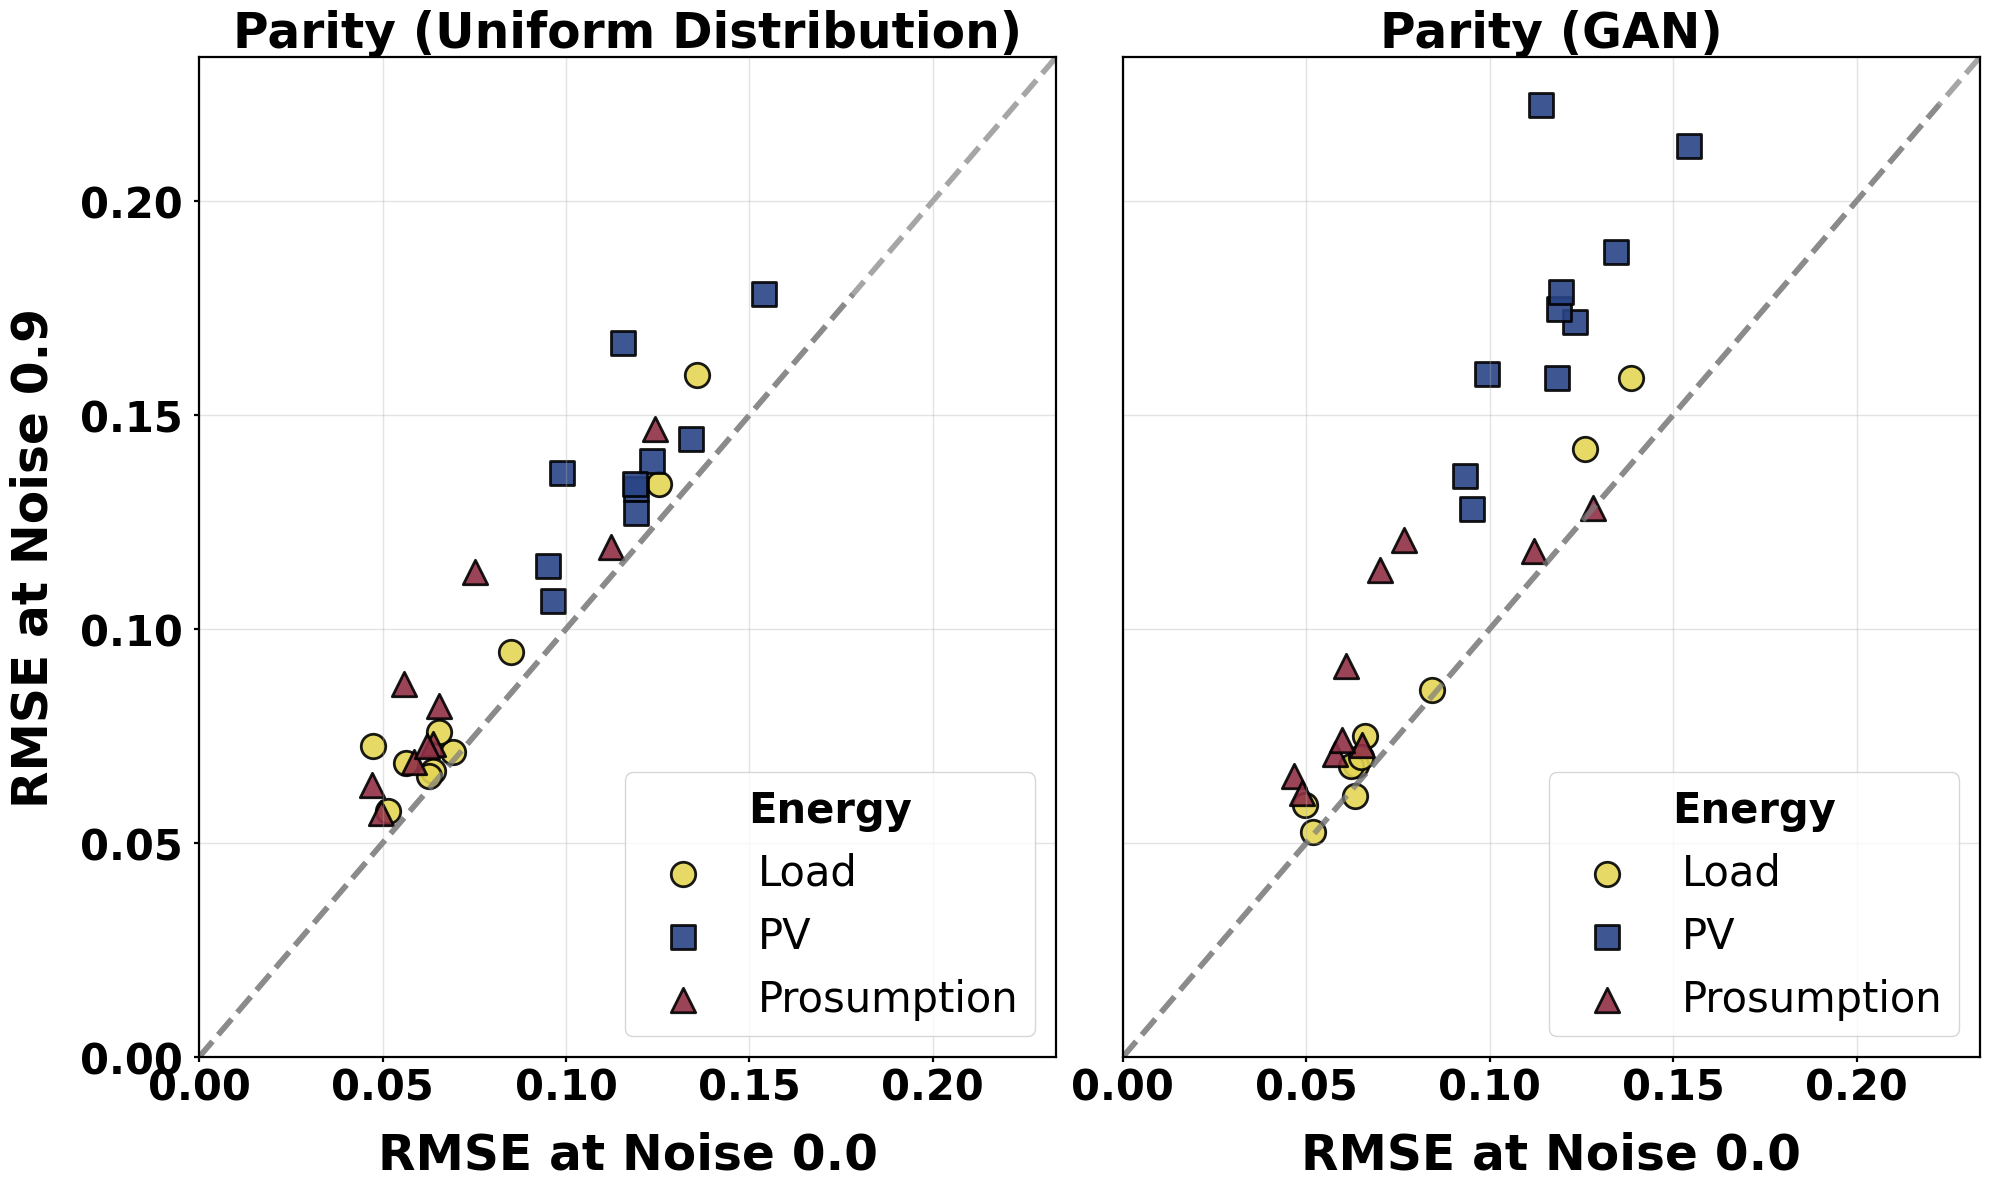

,source,energy,metric,cohort,n_ids,mean_0,mean_9,mean_abs_change,mean_rel_change_pct,median_rel_change_pct,fraction_degraded,pearson_r,lin_slope,lin_intercept,r_squared
0,Uniform Distribution,Load,RMSE,unaffected,10,0.076249,0.086653,0.010404,15.071326,11.594862,1.0,0.971916,1.071346,0.004964,0.944620
1,Uniform Distribution,PV,RMSE,unaffected,10,0.117449,0.137999,0.020550,18.049366,12.752873,1.0,0.771761,0.918182,0.030160,0.595615
2,Uniform Distribution,Prosumption,RMSE,unaffected,10,0.071424,0.088389,0.016966,25.550856,17.780008,1.0,0.929264,1.028706,0.014916,0.863532
3,GAN,Load,RMSE,unaffected,10,0.077012,0.084028,0.007017,8.378720,8.787128,0.9,0.992799,1.176517,-0.006577,0.985649
4,GAN,PV,RMSE,unaffected,10,0.117011,0.173087,0.056075,48.437840,42.831044,1.0,0.736888,1.189258,0.033930,0.543004
5,GAN,Prosumption,RMSE,unaffected,10,0.072571,0.091753,0.019182,30.127337,25.220153,1.0,0.832052,0.806060,0.033256,0.692311


In [330]:
def plot_bd_parity_poisoned_hours(
    results_dir="results3",
    energy_map=ENERGY_MAP_DEFAULT,   # {"Load":91,"PV":92,"Prosumption":93}
    metric="rmse",                   # {"mse","rmse","mae"}
    scales=(0.0, 0.9),               # parity: low vs high
    backdoor_start_time="10:30",     # attacked window start (HH:MM)
    backdoor_num_steps=3,            # attacked window length in hours (e.g., 10:30–12:30 -> 3)
    figsize=(20, 12),
    save_path="figures2/Parity_Backdoor_PoisonedHours.pdf",
    cohort="unaffected",             # <-- "unaffected" or "poisoned"
    poisoned_user_name="user1",      # <-- fallback when only `user` is present
):
    import os, re
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    # fallback colors/markers if not defined globally
    globals_ = globals()
    ENERGY_COLORS = globals_.get("ENERGY_COLORS", {"Load":"#E4D554","PV":"#294586","Prosumption":"#903045"})
    ENERGY_MARKERS = globals_.get("ENERGY_MARKERS", {"Load":"o","PV":"s","Prosumption":"^"})

    # ---- validate
    metric = str(metric).lower().strip()
    if metric not in {"mse", "rmse", "mae"}:
        raise ValueError("metric must be 'mse', 'rmse', or 'mae'")
    if cohort not in {"unaffected", "poisoned"}:
        raise ValueError("cohort must be 'unaffected' or 'poisoned'")
    s_low, s_high = float(scales[0]), float(scales[1])

    # ---- helpers
    def _apply_journal_style(ax):
        ax.grid(True, axis="y", linewidth=1.0, alpha=0.35)
        for s in ax.spines.values():
            s.set_linewidth(1.6)
        ax.tick_params(axis='both', which='both', labelsize=30, width=1.6)  # ← was 26
        for lbl in ax.get_xticklabels() + ax.get_yticklabels():
            lbl.set_fontweight('bold')

    def _scale_token(x: float) -> str:
        return f"{x:.1f}".replace(".", "p")

    def _mid_for(source: str) -> str:
        return "NoiseScale" if source == "noise" else "GanScale"

    def _bd_path(eid: int, energy: str, source: str, scale: float) -> str:
        return os.path.join(
            results_dir,
            f"{eid}{energy}_Backdoor_{_mid_for(source)}_{_scale_token(scale)}_Attack_per_hour_results.csv"
        )

    def _normalize_arch(col: pd.Series) -> pd.Series:
        s = col.astype(str).str.strip().str.lower()
        return np.where(s.str.contains("soft"), "SoftDenseMoE", "MLP")

    def _parse_hhmm_to_hour_start(hhmm: str) -> int:
        m = re.match(r"^\s*(\d{1,2})", str(hhmm))
        return max(0, min(23, int(m.group(1)))) if m else 10

    def _poisoned_hours(start_time="10:30", steps=3) -> set[int]:
        h0 = _parse_hhmm_to_hour_start(start_time)
        return {(h0 + k) % 24 for k in range(int(steps))}
    POISONED = _poisoned_hours(backdoor_start_time, backdoor_num_steps)

    def _normalize_hour_col(s: pd.Series) -> pd.Series:
        st = s.astype(str)
        h = st.str.extract(r"(\d{1,2})", expand=False)
        return pd.to_numeric(h, errors="coerce").clip(0, 23).astype("Int64")

    def _attach_unique_id(df: pd.DataFrame) -> pd.DataFrame:
        # Priority: building -> user_key -> cluster_id+user -> user -> cluster_id
        if "building" in df.columns:
            uid = df["building"].astype(str).str.strip()
        elif "user_key" in df.columns:
            uid = df["user_key"].astype(str).str.strip()
        elif "cluster_id" in df.columns and "user" in df.columns:
            uid = df["cluster_id"].astype(str).str.strip() + "||" + df["user"].astype(str).str.strip()
        elif "user" in df.columns:
            uid = df["user"].astype(str).str.strip()
        elif "cluster_id" in df.columns:
            uid = df["cluster_id"].astype(str).str.strip()
        else:
            uid = pd.Series("UNK", index=df.index)
        df["_id_unq"] = uid
        return df

    def _compute_is_poisoned(df: pd.DataFrame) -> pd.Series:
        if "poisoned_user_key" in df.columns and "user_key" in df.columns:
            return df["user_key"].astype(str).str.strip() == df["poisoned_user_key"].astype(str).str.strip()
        if "poisoned_user" in df.columns and "user" in df.columns:
            return df["user"].astype(str).str.strip() == df["poisoned_user"].astype(str).str.strip()
        if "user" in df.columns:
            return df["user"].astype(str).str.strip().eq(str(poisoned_user_name))
        if "building" in df.columns and "poisoned_building" in df.columns:
            return df["building"].astype(str).str.strip() == df["poisoned_building"].astype(str).str.strip()
        return pd.Series(False, index=df.index)

    def _read_bd(eid: int, energy: str, source: str, scale: float):
        p = _bd_path(eid, energy, source, scale)
        if not os.path.exists(p):
            return None
        df = pd.read_csv(p)
        if "hour" not in df.columns or metric not in df.columns:
            return None
        df["hour"] = _normalize_hour_col(df["hour"])
        df = df[df["hour"].isin(list(POISONED))]       # attacked hours only
        if df.empty:
            return None
        df["arch_norm"] = _normalize_arch(df.get("architecture", pd.Series("MLP", index=df.index)))
        df = _attach_unique_id(df)
        df["is_poisoned"] = _compute_is_poisoned(df)
        mask = ~df["is_poisoned"] if cohort == "unaffected" else df["is_poisoned"]
        df = df.loc[mask].copy()
        return df if not df.empty else None

    def _per_id_value_over_poisoned(df: pd.DataFrame) -> pd.DataFrame:
        """Equal weight across (ID, arch, hour) within attacked hours → one value per unique ID."""
        if df is None or df.empty:
            return pd.DataFrame(columns=["id_val", "m_id"])
        step1 = (df.groupby(["_id_unq", "arch_norm", "hour"], as_index=False)[metric]
                   .mean()
                   .rename(columns={metric: "m_hour"}))
        step2 = (step1.groupby(["_id_unq", "arch_norm"], as_index=False)["m_hour"]
                      .mean()
                      .rename(columns={"m_hour": "m_id_arch"}))
        step3 = (step2.groupby("_id_unq", as_index=False)["m_id_arch"]
                      .mean()
                      .rename(columns={"_id_unq": "id_val", "m_id_arch": "m_id"}))
        step3 = step3[np.isfinite(step3["m_id"].to_numpy(float))]
        return step3

    def _summary_from_pairs(x: np.ndarray, y: np.ndarray) -> dict:
        n = x.size
        abs_change = y - x
        with np.errstate(divide="ignore", invalid="ignore"):
            rel_change = (abs_change / x) * 100.0
        out = dict(
            n_ids=int(n),
            mean_0=float(np.nanmean(x)) if n else np.nan,
            mean_9=float(np.nanmean(y)) if n else np.nan,
            mean_abs_change=float(np.nanmean(abs_change)) if n else np.nan,
            mean_rel_change_pct=float(np.nanmean(rel_change)) if n else np.nan,
            median_rel_change_pct=float(np.nanmedian(rel_change)) if n else np.nan,
            fraction_degraded=float(np.mean(y > x)) if n else np.nan
        )
        if n >= 2 and np.all(np.isfinite(x)) and np.all(np.isfinite(y)):
            r = np.corrcoef(x, y)[0, 1]
            slope, intercept = np.polyfit(x, y, 1)
            r2 = float(r ** 2)
        else:
            r, slope, intercept, r2 = np.nan, np.nan, np.nan, np.nan
        out.update(dict(pearson_r=float(r), lin_slope=float(slope),
                        lin_intercept=float(intercept), r_squared=float(r2)))
        return out

    # ---- collect pairs & plot
    sources = [("noise", "Uniform Distribution"), ("gan", "GAN")]
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)
    global_max = 0.0
    summary_rows, pairs_rows = [], []

    for j, (ax, (src_key, src_label)) in enumerate(zip(axes, sources)):
        local_max_panel, plotted_any = 0.0, False

        for energy, eid in energy_map.items():
            d0 = _read_bd(eid, energy, src_key, s_low)
            d9 = _read_bd(eid, energy, src_key, s_high)
            if d0 is None or d9 is None:
                continue

            v0 = _per_id_value_over_poisoned(d0).rename(columns={"m_id": "m0"})
            v9 = _per_id_value_over_poisoned(d9).rename(columns={"m_id": "m9"})
            mrg = pd.merge(v0, v9, on="id_val", how="inner")
            if mrg.empty:
                continue

            # raw pairs
            pairs_rows.extend([
                {"source": src_label, "energy": energy, "id": r["id_val"],
                 "metric": metric.upper(), "m0": float(r["m0"]), "m9": float(r["m9"]), "cohort": cohort}
                for _, r in mrg.iterrows()
            ])

            ax.scatter(
                mrg["m0"].values, mrg["m9"].values,
                s=310, marker=ENERGY_MARKERS[energy], color=ENERGY_COLORS[energy],
                edgecolor="black", linewidths=2, alpha=0.9, label=energy
            )
            local_max = float(np.nanmax(np.r_[mrg["m0"].values, mrg["m9"].values]))
            local_max_panel = max(local_max_panel, local_max)
            plotted_any = True

            stats = _summary_from_pairs(mrg["m0"].to_numpy(float), mrg["m9"].to_numpy(float))
            summary_rows.append({
                "source": src_label, "energy": energy, "metric": metric.upper(), "cohort": cohort,
                **stats
            })

        if plotted_any:
            global_max = max(global_max, local_max_panel)
            ax.plot([0, local_max_panel], [0, local_max_panel],
                    linestyle="--", linewidth=4.0, color="gray", alpha=0.7)

        ax.set_title(f"Parity ({src_label})", fontsize=35, fontweight="bold")
        ax.set_xlabel(f"{metric.upper()} at Noise {s_low:.1f}", fontsize=35, fontweight="bold", labelpad=16)
        if j == 0:
            ax.set_ylabel(f"{metric.upper()} at Noise {s_high:.1f}", fontsize=35, fontweight="bold", labelpad=16)
            ax.tick_params(axis="y", which="major", pad=8)
        else:
            ax.set_ylabel("")
            ax.tick_params(left=False, labelleft=False)

        _apply_journal_style(ax)
        ax.tick_params(axis='both', which='both', labelsize=30)  # force 30 here


        # light styling
        ax.grid(True, axis="both", linewidth=1.0, alpha=0.35)
        for sp in ax.spines.values():
            sp.set_linewidth(1.6)

        leg = ax.legend(title="Energy", loc="lower right", fontsize=30, frameon=True)
        if leg and leg.get_title():
            leg.get_title().set_fontsize(30); leg.get_title().set_fontweight("bold")

    if global_max > 0:
        lim = global_max * 1.05
        for ax in axes:
            ax.set_xlim(0, lim)
            ax.set_ylim(0, lim)
            ax.plot([0, lim], [0, lim], linestyle="--", linewidth=4.0,
                    color="gray", alpha=0.7, zorder=0)

    plt.tight_layout()
    os.makedirs("figures2", exist_ok=True)
    if save_path:
        plt.savefig(save_path, format=os.path.splitext(save_path)[1][1:] or "pdf",
                    bbox_inches="tight")
    plt.show()

    summary_df = pd.DataFrame(summary_rows, columns=[
        "source", "energy", "metric", "cohort", "n_ids", "mean_0", "mean_9",
        "mean_abs_change", "mean_rel_change_pct", "median_rel_change_pct",
        "fraction_degraded", "pearson_r", "lin_slope", "lin_intercept", "r_squared"
    ])
    pairs_df = pd.DataFrame(pairs_rows, columns=["source", "energy", "id", "metric", "m0", "m9", "cohort"])
    return {"summary": summary_df, "pairs": pairs_df}

res = plot_bd_parity_poisoned_hours(
    metric="rmse",
    backdoor_start_time="10:30",
    backdoor_num_steps=3,
    cohort="unaffected",          # <-- important
    poisoned_user_name="user1"    # <-- fallback rule matches your files
)
display(res["summary"])


# Security Measures

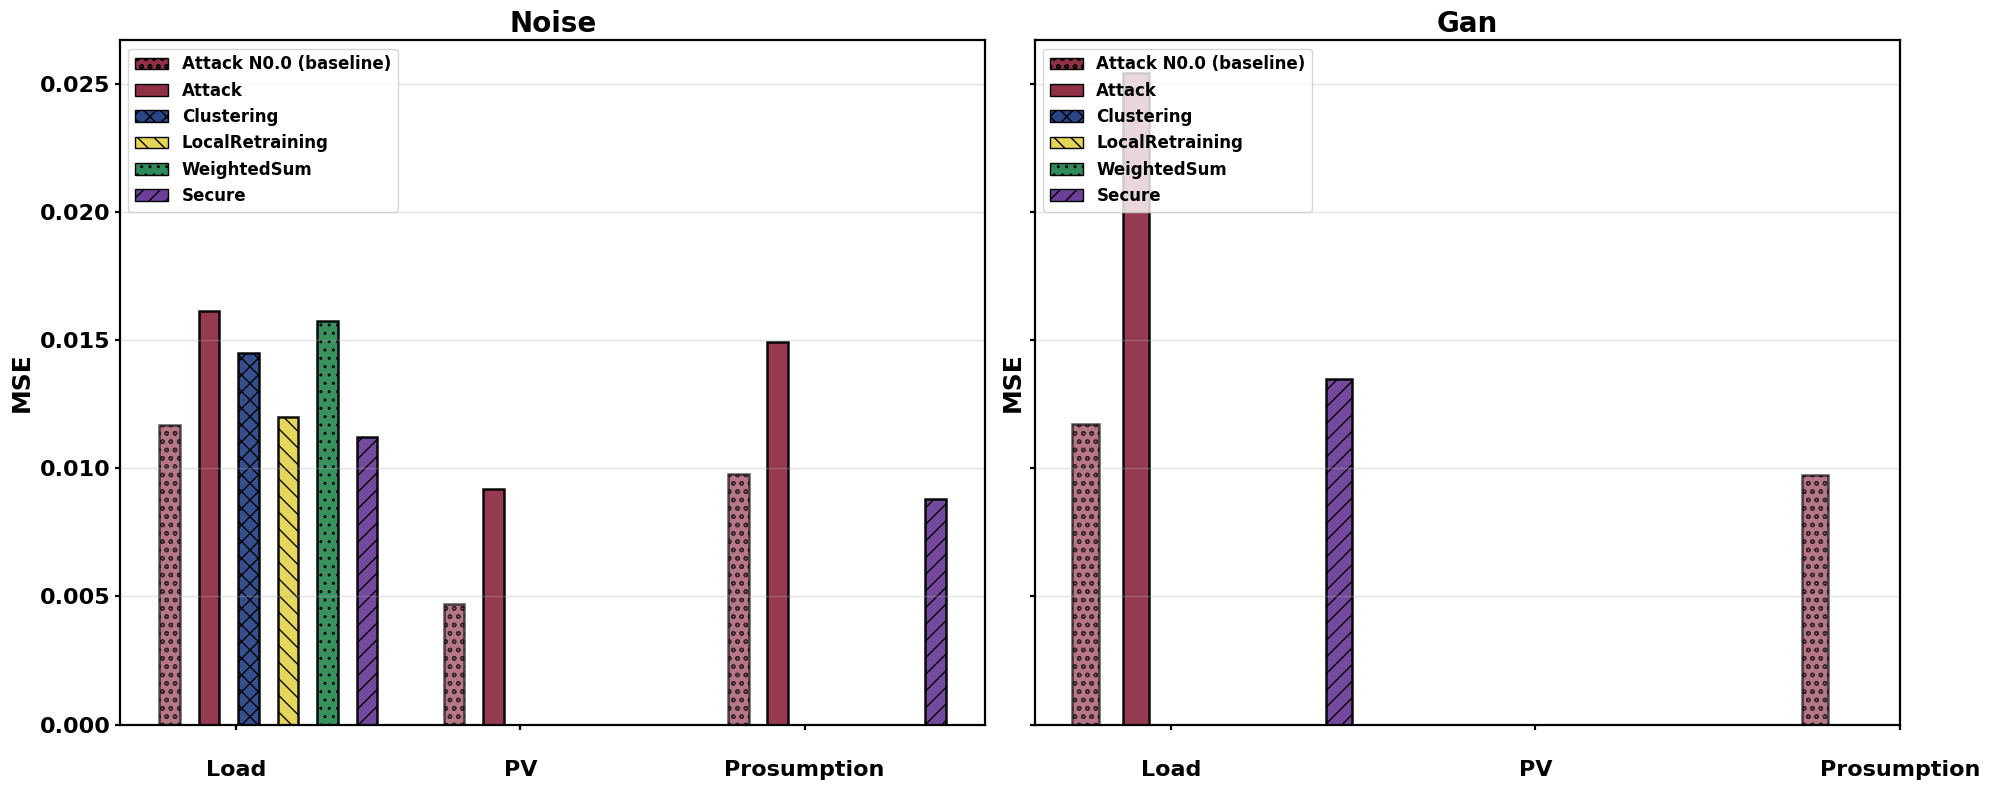

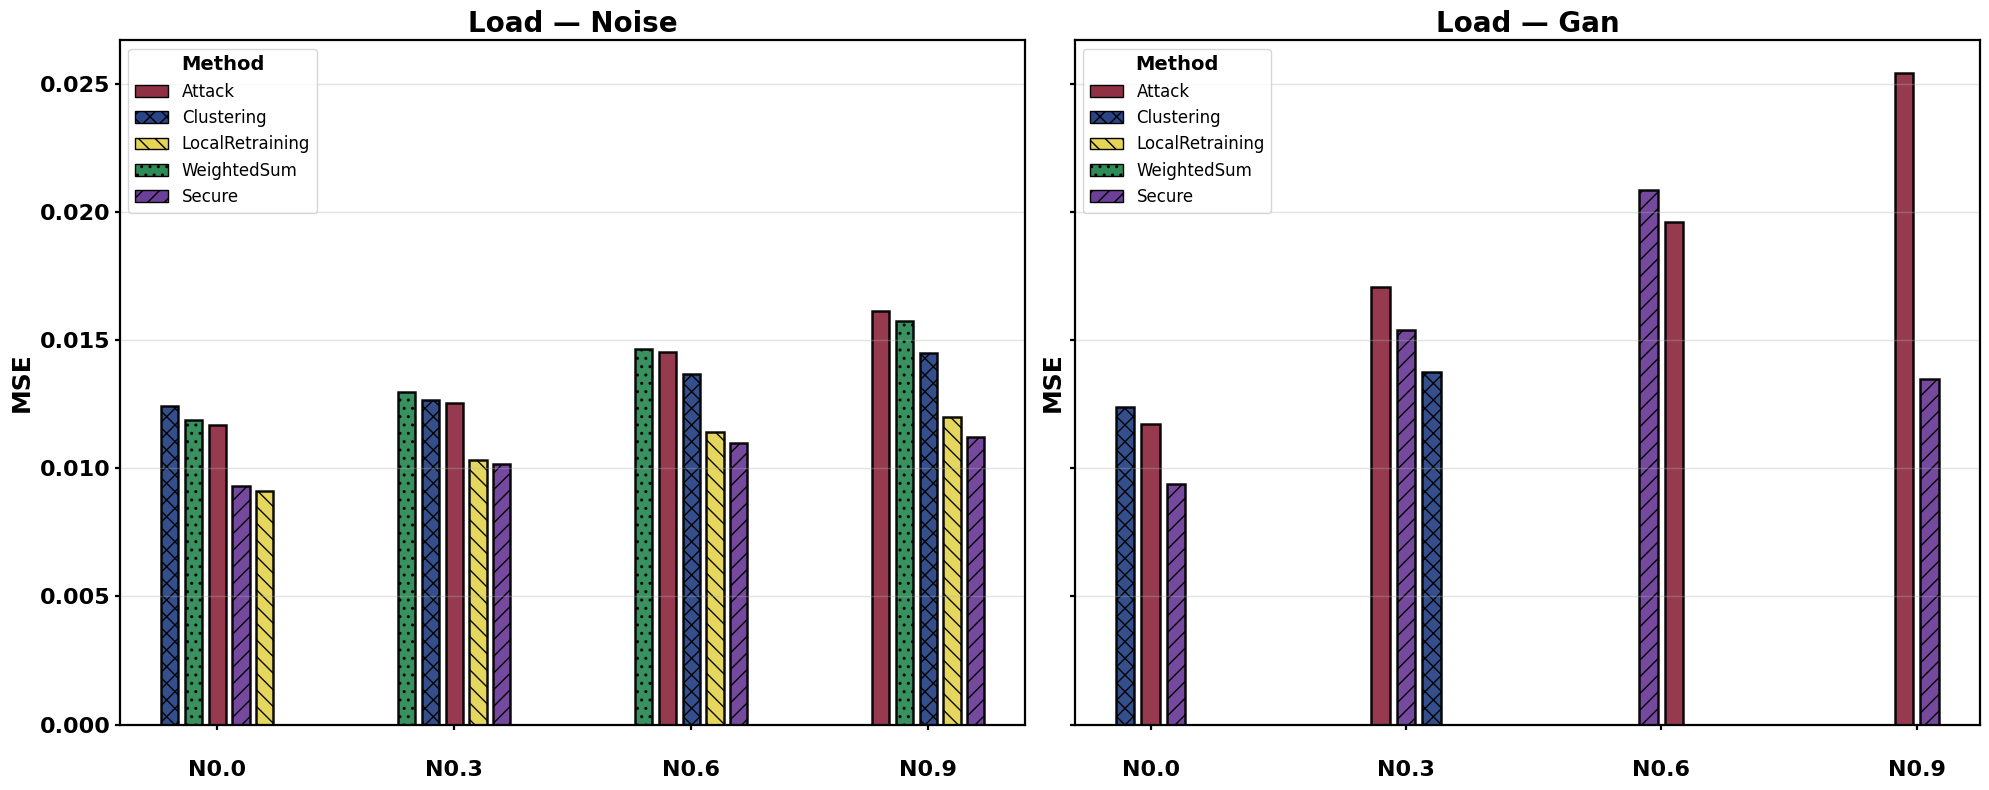

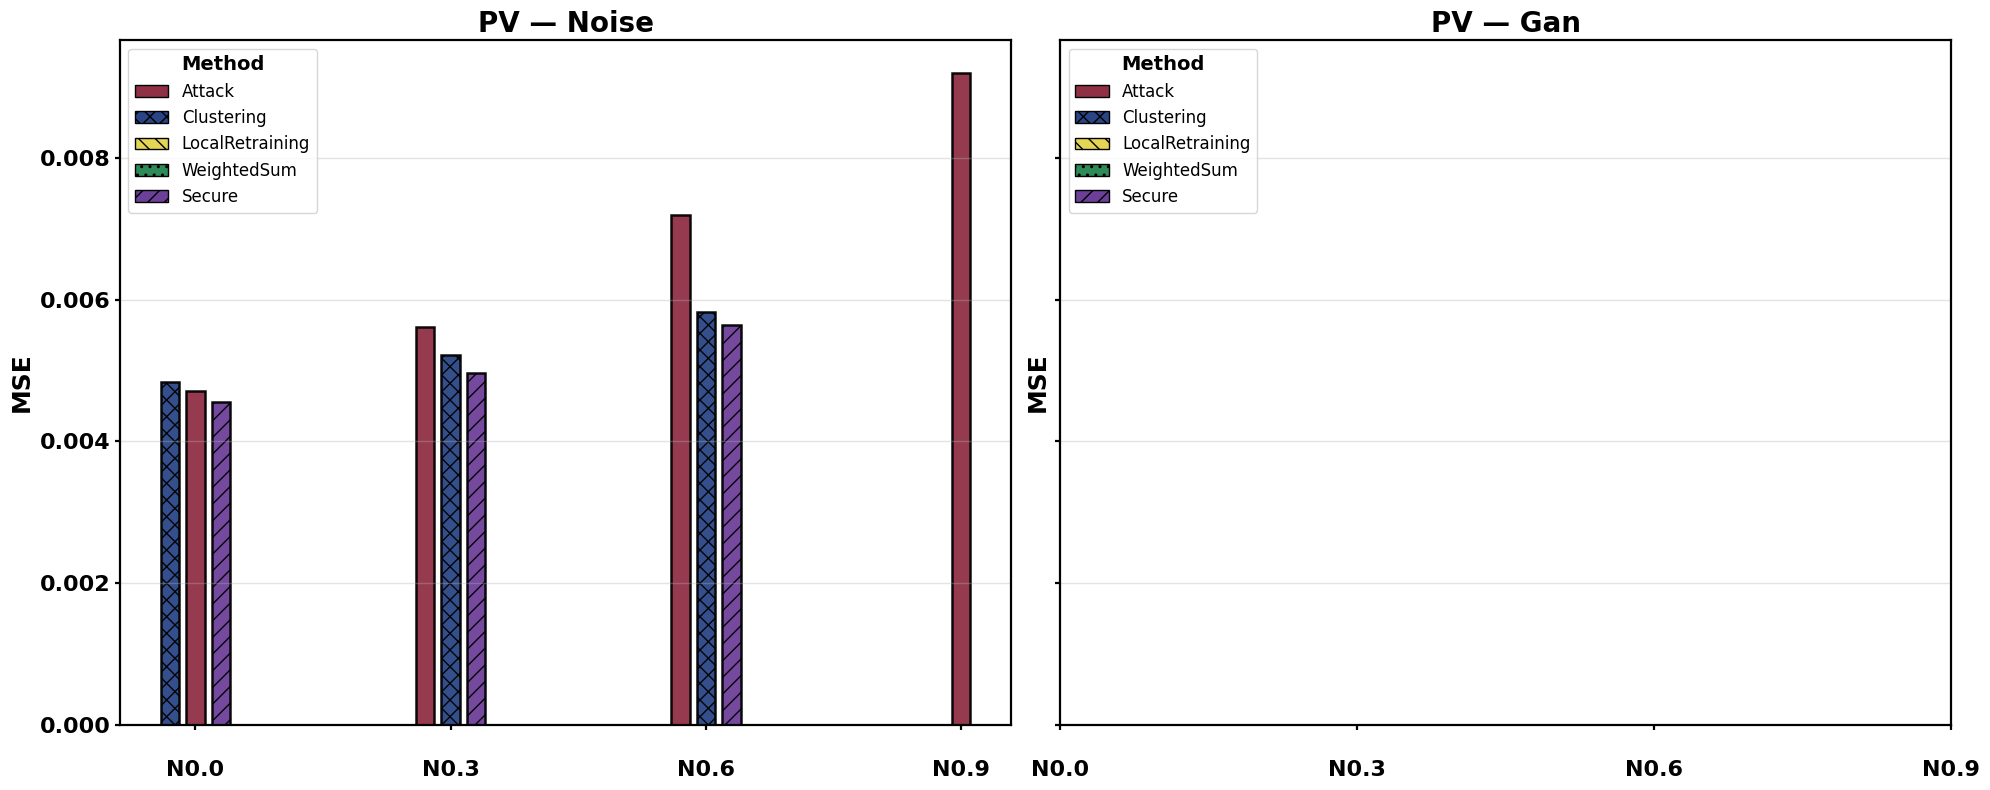

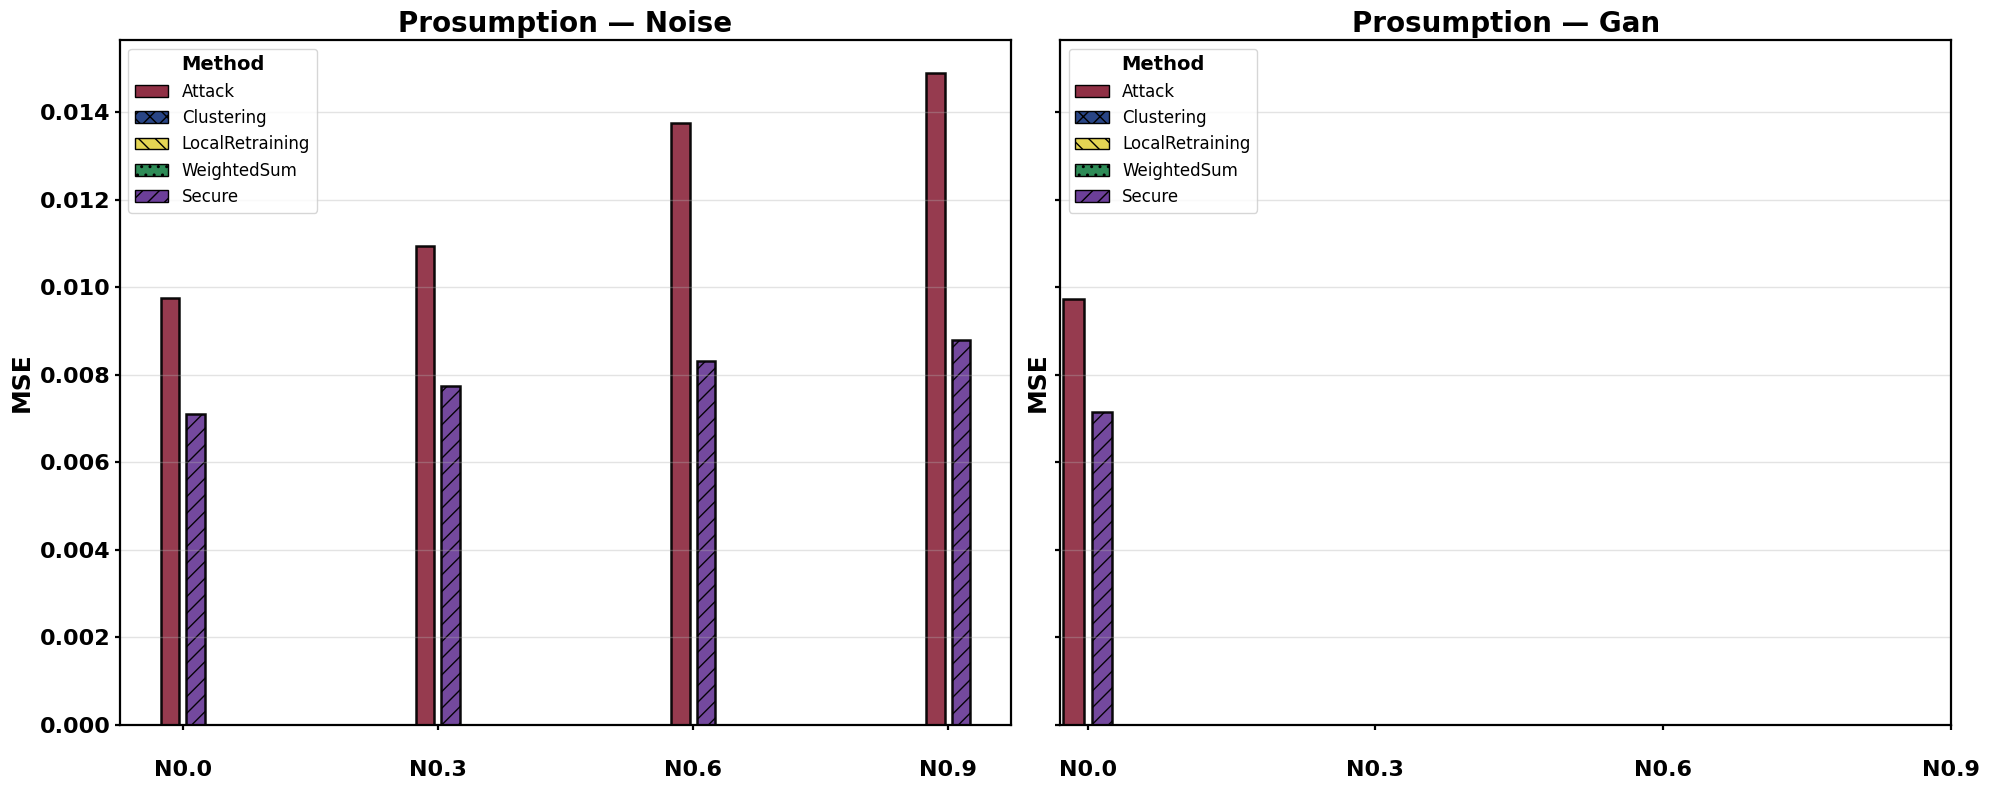

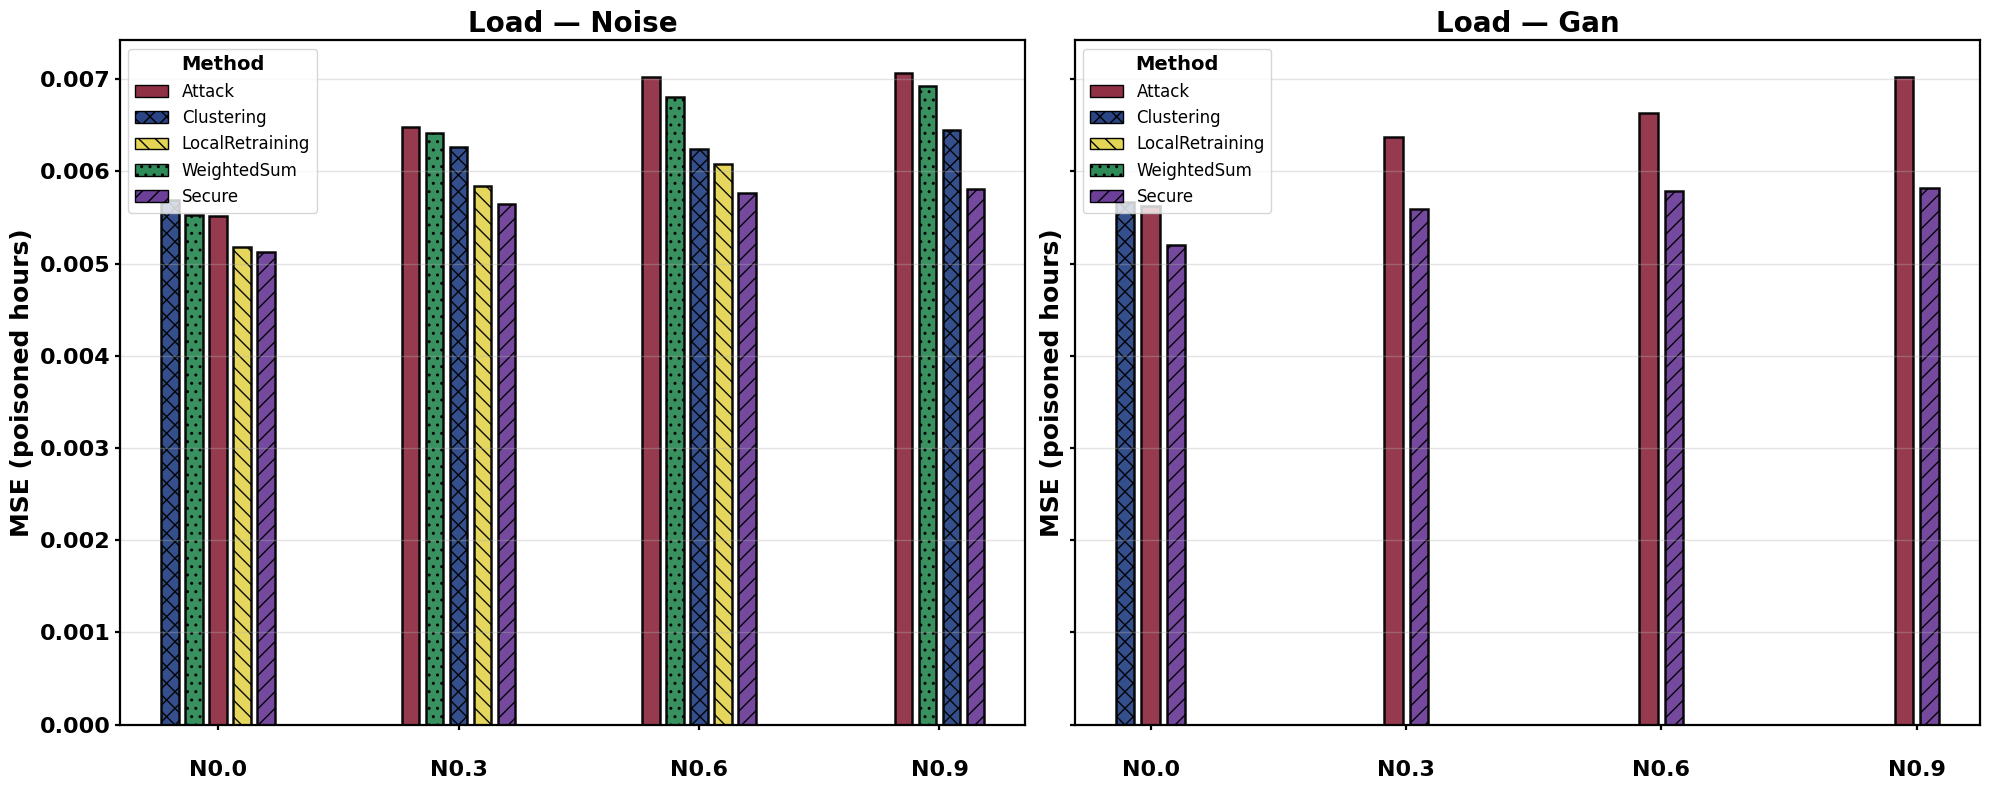

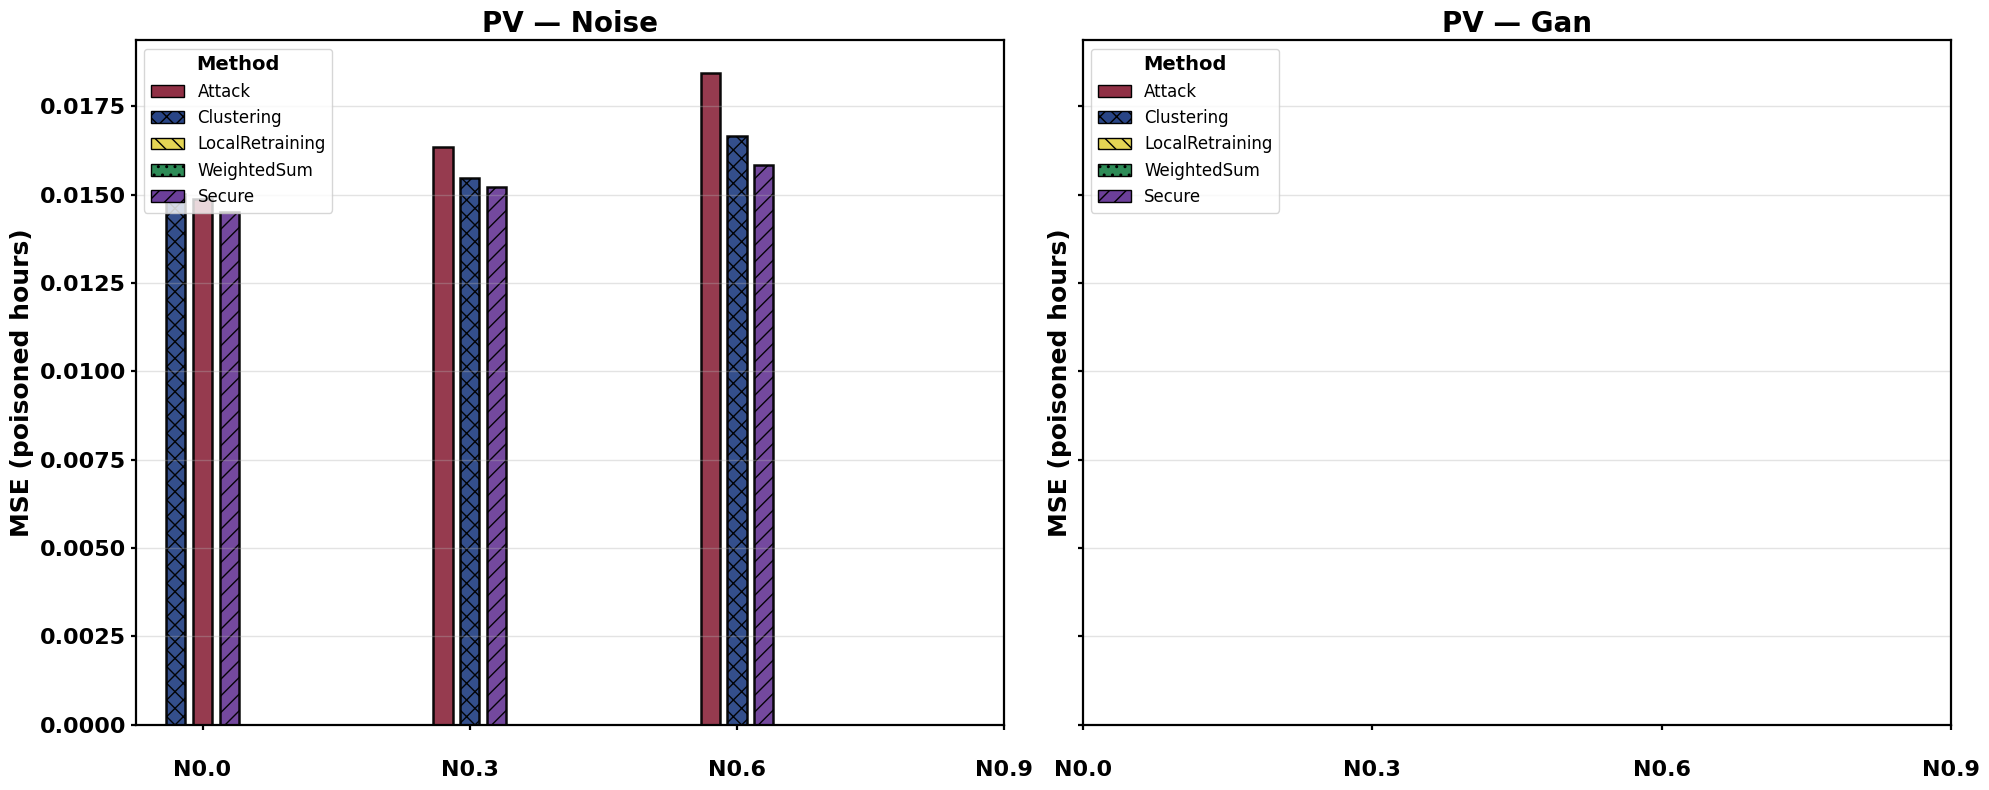

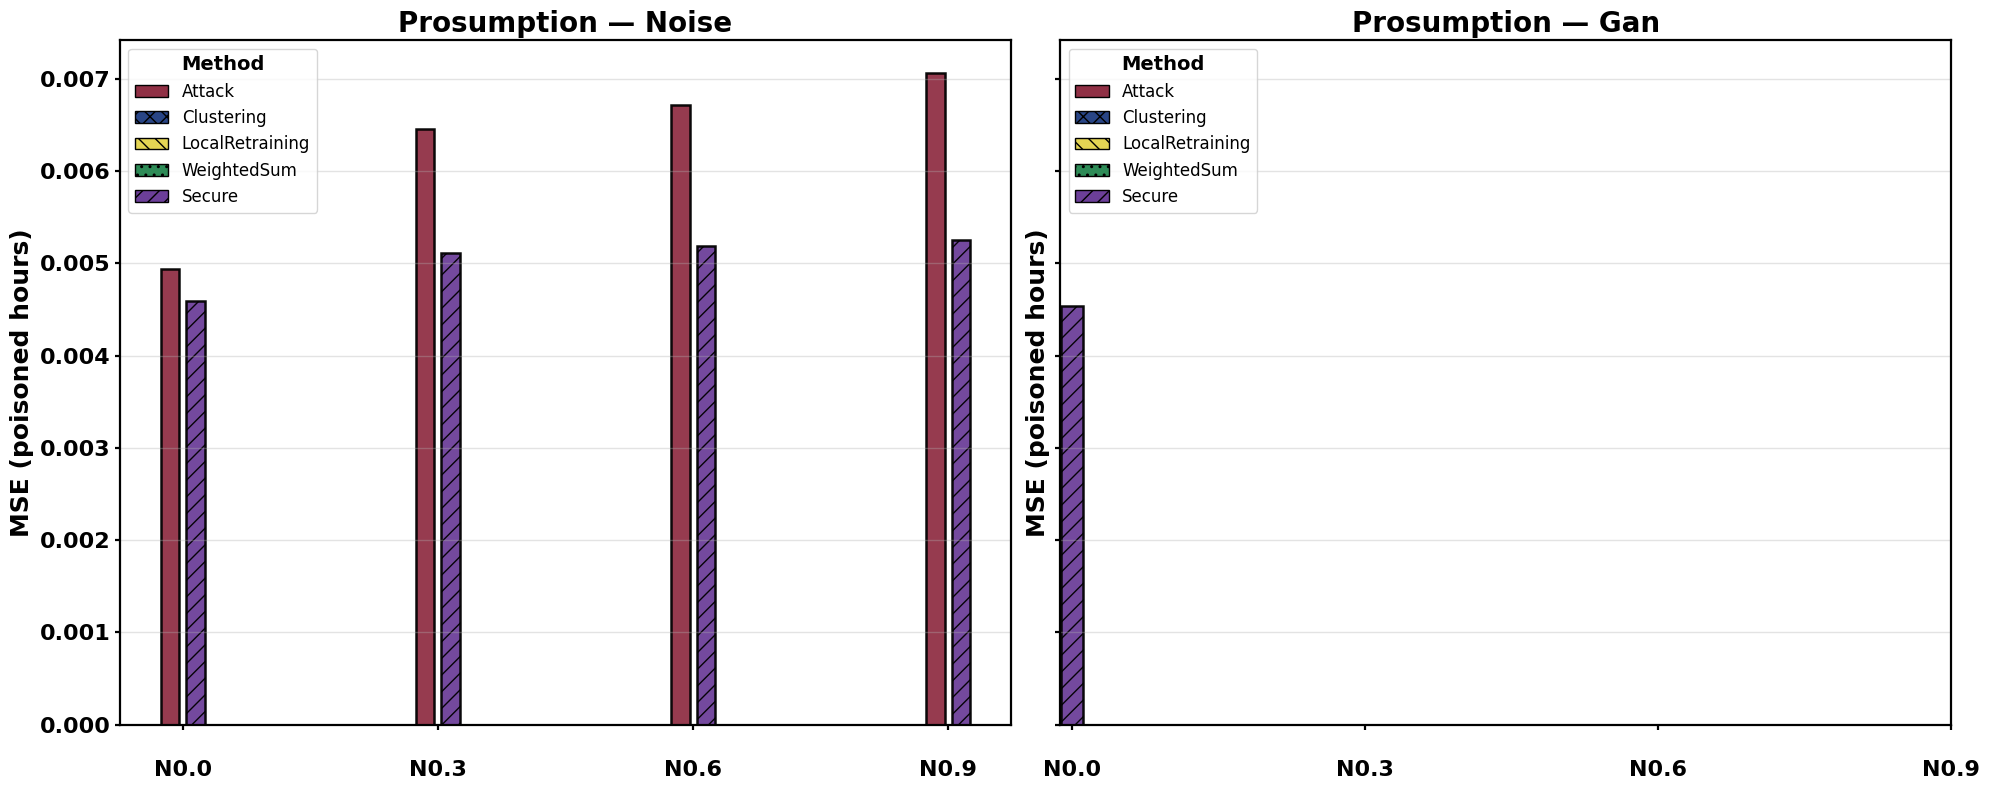

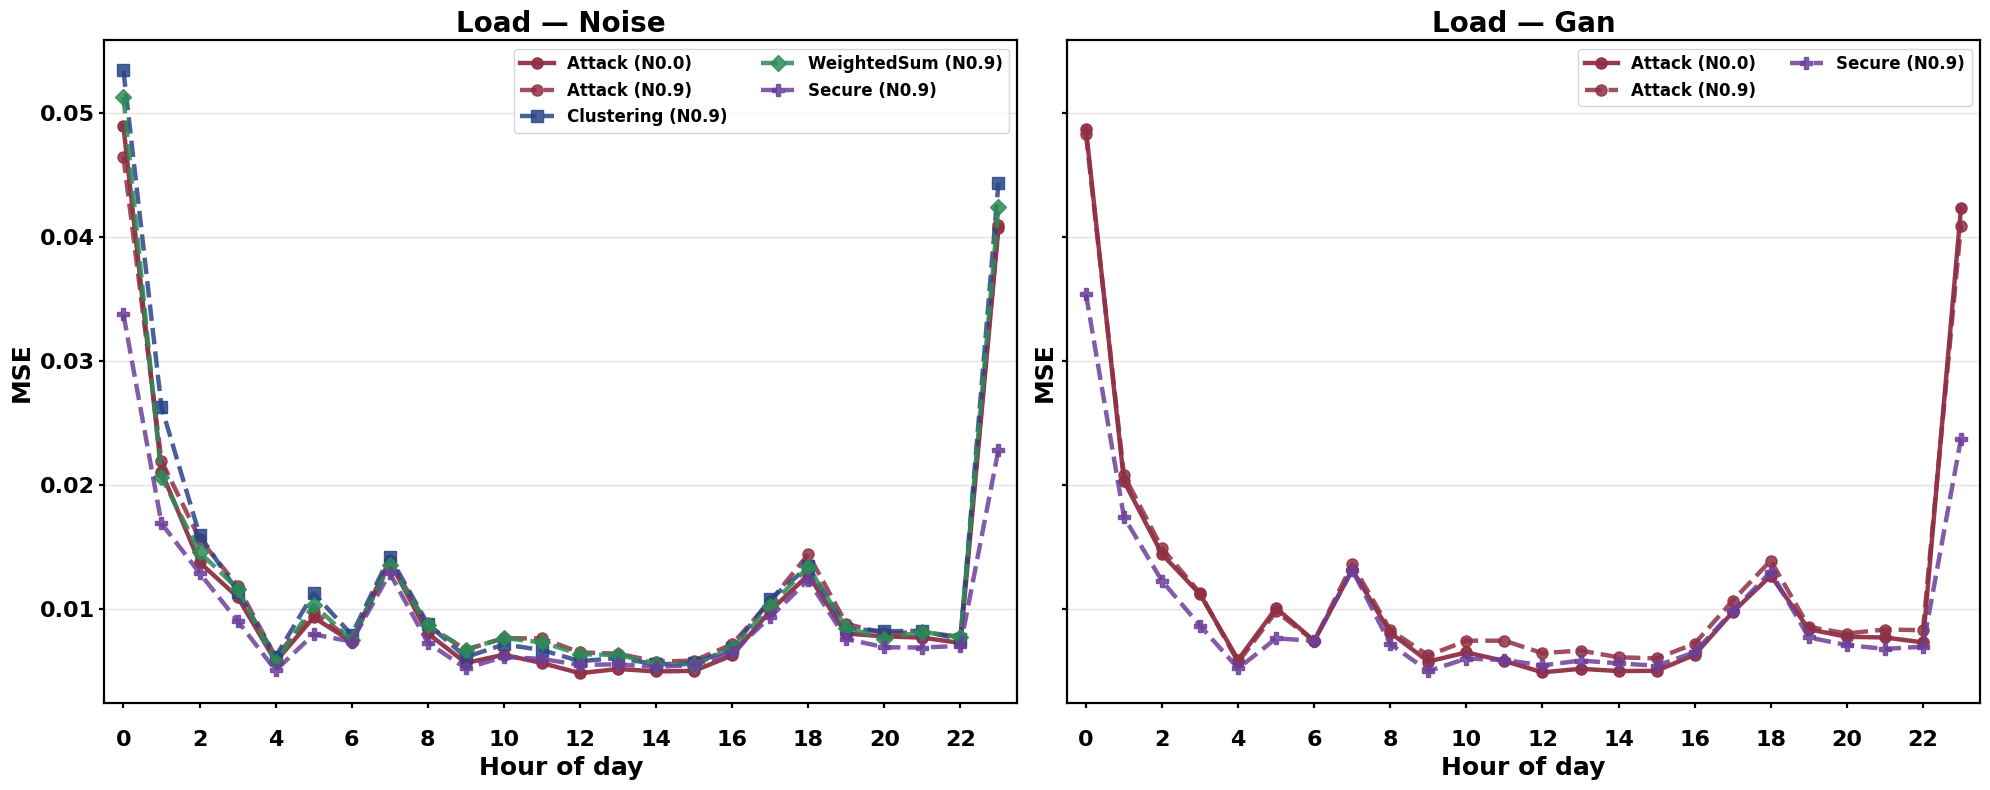

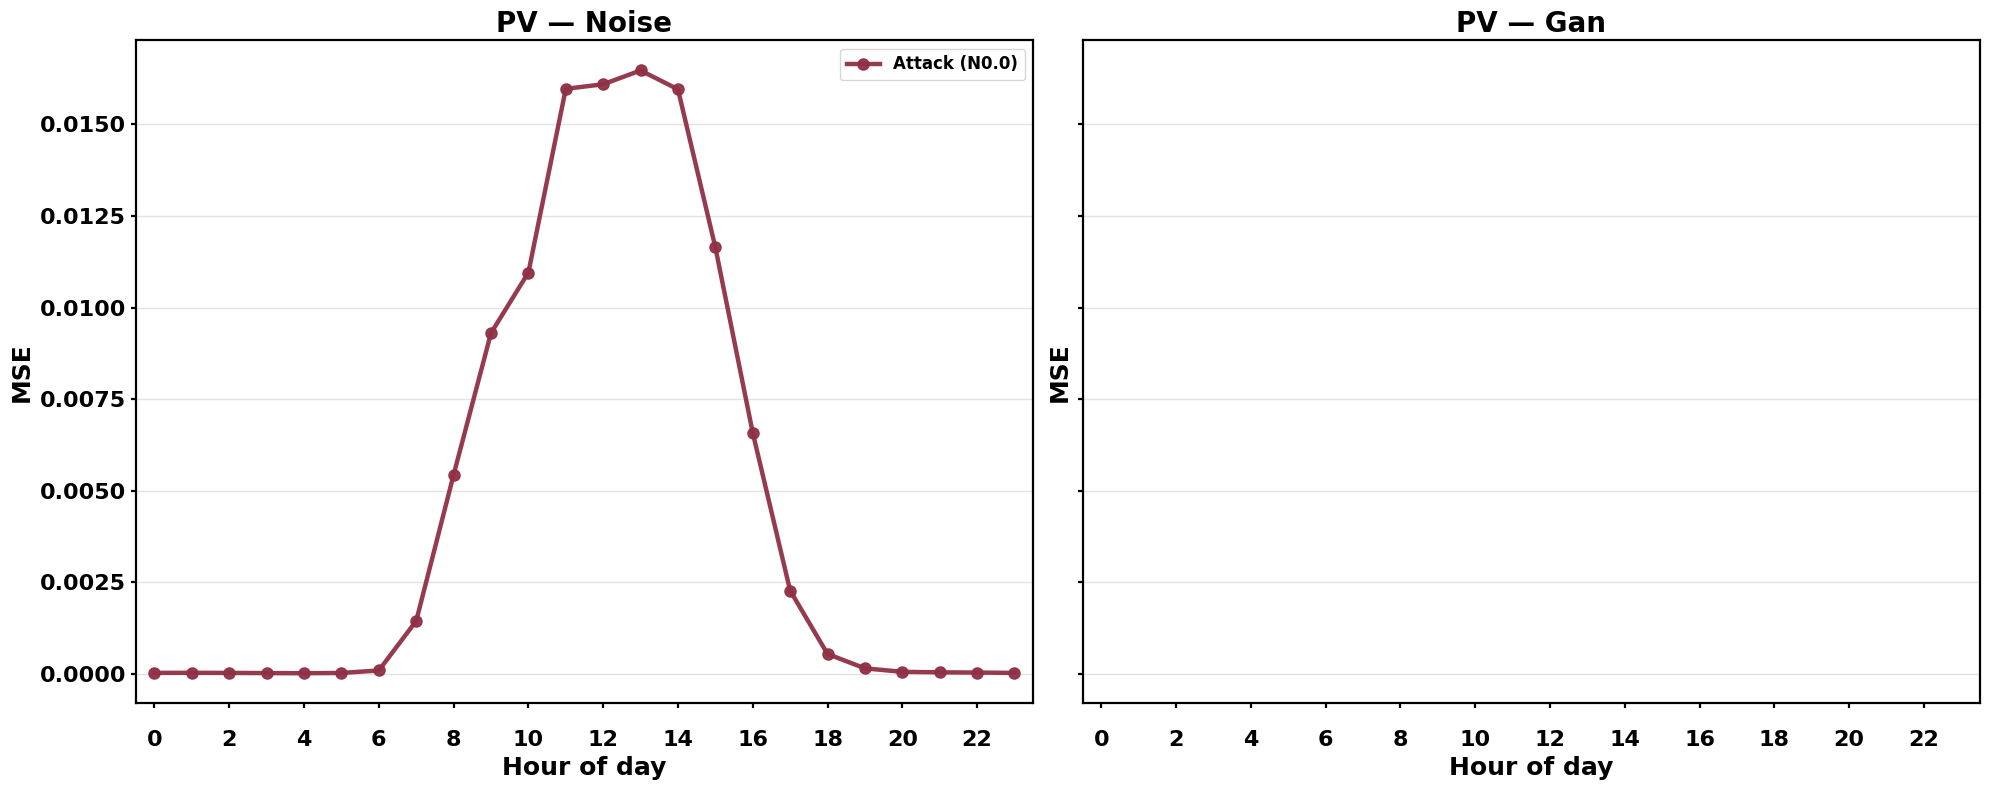

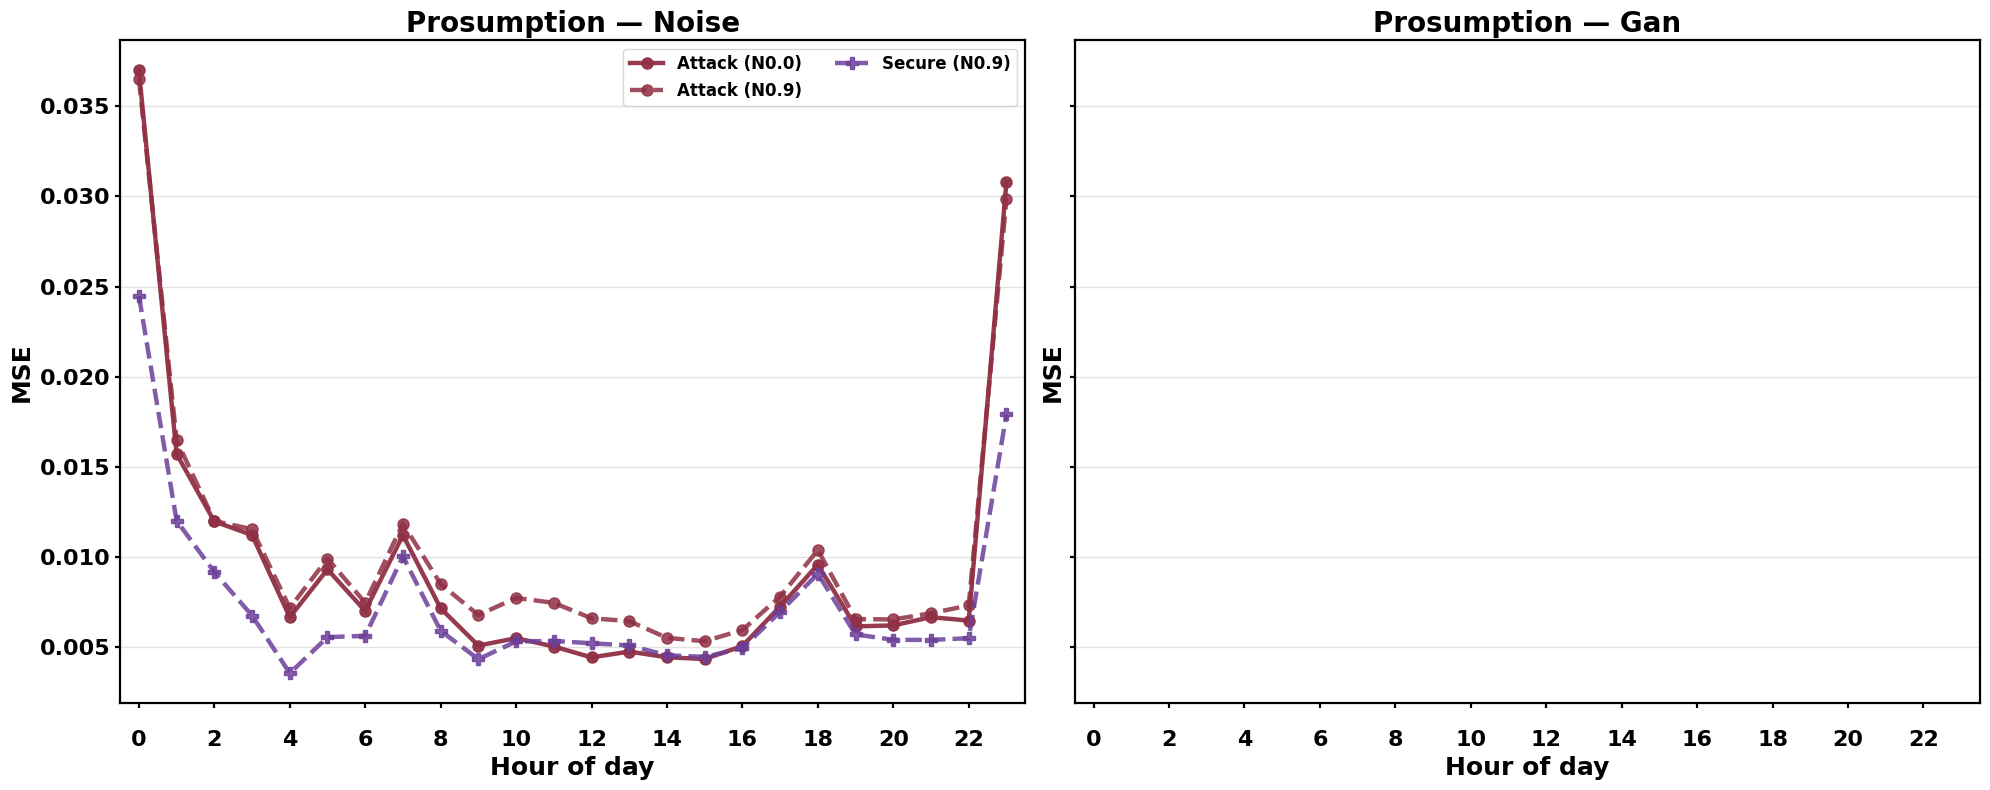

In [62]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# =========================
# Shared config & helpers
# =========================

ENERGY_MAP_DEFAULT = {"Load": 91, "PV": 92, "Prosumption": 93}

# Your signature colors (used elsewhere if needed)
ENERGY_COLORS = {"Load": "#E4D554", "PV": "#294586", "Prosumption": "#903045"}

# --- Method color palette (distinct within each plot) ---
METHODS = ["Attack", "Clustering", "LocalRetraining", "WeightedSum", "Secure"]
METHOD_COLORS = {
    "Attack":          "#903045",  # your maroon
    "Clustering":      "#294586",  # your navy
    "LocalRetraining": "#E4D554",  # your gold
    "WeightedSum":     "#2E8B57",  # matching sea green
    "Secure":          "#6C3F99",  # matching plum
}
METHOD_HATCH = {
    "Attack": "",
    "Clustering": "xx",
    "LocalRetraining": "\\\\",
    "WeightedSum": "..",
    "Secure": "//",
}

# Scales
SCALES = (0.0, 0.3, 0.6, 0.9)
SCALE_LABEL = lambda s: f"N{s:.1f}"

def _scale_token(x: float) -> str:
    return f"{x:.1f}".replace(".", "p")

def _mid_for(source: str) -> str:
    return "NoiseScale" if source == "noise" else "GanScale"

def _normalize_arch(col: pd.Series) -> pd.Series:
    s = col.astype(str).str.strip().str.lower()
    return np.where(s.str.contains("soft"), "SoftDenseMoE", "MLP")

def _apply_journal_style(ax):
    ax.grid(True, axis="y", linewidth=1.0, alpha=0.35)
    for spine in ax.spines.values():
        spine.set_linewidth(1.6)
    ax.tick_params(axis='both', which='both', labelsize=16, width=1.6)
    for lbl in ax.get_xticklabels() + ax.get_yticklabels():
        lbl.set_fontweight('bold')

def _pick_id_col(df: pd.DataFrame) -> str:
    for cand in ["building", "user_key", "user", "cluster_id"]:
        if cand in df.columns:
            return cand
    df["_single_id"] = "ALL"
    return "_single_id"

# ---------- Poisoning file IO + aggregation ----------
def _poison_path_variant(results_dir: str, eid: int, energy: str, source: str, scale: float, variant: str) -> str:
    return os.path.join(
        results_dir,
        f"{eid}{energy}_Poison_{_mid_for(source)}_{_scale_token(scale)}_{variant}_all_results.csv"
    )

def _read_poison_df_variant(results_dir: str, energy: str, eid: int, source: str, scale: float, variant: str, metric: str):
    p = _poison_path_variant(results_dir, eid, energy, source, scale, variant)
    if not os.path.exists(p):
        return None
    df = pd.read_csv(p)
    if metric not in df.columns:
        return None
    df["arch_norm"] = _normalize_arch(df["architecture"]) if "architecture" in df.columns else "MLP"
    df["building"] = df["building"].astype(str).str.strip()
    return df

def _per_building_arch_mean(df: pd.DataFrame, metric: str) -> pd.DataFrame:
    if df is None or df.empty:
        return pd.DataFrame(columns=["building", "arch_norm", "m"])
    g = (df.groupby(["building", "arch_norm"], as_index=False)[metric]
           .mean()
           .rename(columns={metric: "m"}))
    return g

def _overall_mean_equal_building_arch(df: pd.DataFrame, metric: str) -> float:
    """Equal weight per (building, arch) across the whole dataframe."""
    if df is None or df.empty:
        return np.nan
    g = _per_building_arch_mean(df, metric)
    return float(g["m"].mean()) if not g.empty else np.nan

# ---------- Backdoor file IO + aggregation ----------
def _backdoor_path_variant(results_dir: str, eid: int, energy: str, source: str, scale: float, variant: str) -> str:
    return os.path.join(
        results_dir,
        f"{eid}{energy}_Backdoor_{_mid_for(source)}_{_scale_token(scale)}_{variant}_per_hour_results.csv"
    )

def _read_backdoor_df_variant(results_dir: str, energy: str, eid: int, source: str, scale: float, variant: str, metric: str):
    p = _backdoor_path_variant(results_dir, eid, energy, source, scale, variant)
    if not os.path.exists(p):
        return None
    df = pd.read_csv(p)
    if "hour" not in df.columns or metric not in df.columns:
        return None
    df["hour"] = pd.to_numeric(df["hour"], errors="coerce")
    df["arch_norm"] = _normalize_arch(df["architecture"]) if "architecture" in df.columns else "MLP"
    id_col = _pick_id_col(df)
    df[id_col] = df[id_col].astype(str).str.strip()
    df["_id_col"] = id_col
    return df

def _per_hour_equal_weight(df: pd.DataFrame, metric: str) -> pd.DataFrame:
    """Per-hour mean with equal weight per (ID, architecture)."""
    if df is None or df.empty:
        return pd.DataFrame(columns=["hour", "mean_metric"])
    id_col = df["_id_col"].iloc[0]
    step1 = (df.groupby([id_col, "arch_norm", "hour"], as_index=False)[metric]
               .mean()
               .rename(columns={metric: "m_hour"}))
    step2 = (step1.groupby("hour", as_index=False)["m_hour"]
                   .mean()
                   .rename(columns={"m_hour": "mean_metric"}))
    return step2.sort_values("hour")

def _poisoned_hours(start_time="10:30", steps=4) -> set[int]:
    # 10:30 -> 10
    m = re.match(r"^\s*(\d{1,2})", start_time)
    h0 = int(m.group(1)) if m else 10
    return { (h0 + k) % 24 for k in range(int(steps)) }

def _per_building_poisoned_only(df: pd.DataFrame, metric: str, poisoned_hours: set[int]) -> pd.DataFrame:
    """One value per building/user over poisoned hours only (equal weight per arch & hour)."""
    if df is None or df.empty:
        return pd.DataFrame(columns=["_id_val", "m_id"])
    id_col = df["_id_col"].iloc[0]
    step1 = (df.groupby([id_col, "arch_norm", "hour"], as_index=False)[metric]
               .mean()
               .rename(columns={metric: "m_hour"}))
    sub = step1[step1["hour"].isin(list(poisoned_hours))]
    if sub.empty:
        return pd.DataFrame(columns=["_id_val", "m_id"])
    step2 = (sub.groupby([id_col, "arch_norm"], as_index=False)["m_hour"]
               .mean()
               .rename(columns={"m_hour": "m_id_arch"}))
    step3 = (step2.groupby(id_col, as_index=False)["m_id_arch"]
               .mean()
               .rename(columns={id_col: "_id_val", "m_id_arch": "m_id"}))
    return step3

def _overall_mean_poisoned_only(df: pd.DataFrame, metric: str, poisoned_hours: set[int]) -> float:
    per_id = _per_building_poisoned_only(df, metric, poisoned_hours)
    return float(per_id["m_id"].mean()) if not per_id.empty else np.nan

# ============================================================
# 0) Poisoning — Overview bars per energy:
#     N0.0 baseline (Attack) + N0.9 {Attack, Clustering, LocalRetraining, WeightedSum, Secure}
#     2 subplots: Noise (left), GAN (right) — colors by METHOD (distinct)
# ============================================================
def plot_sec_poisoning_overview_bars(
    results_dir="results3",
    energy_map=ENERGY_MAP_DEFAULT,
    metric="mse"
):
    metric = metric.lower().strip()
    if metric not in {"mse", "rmse", "mae"}:
        raise ValueError("metric must be 'mse', 'rmse', or 'mae'")

    fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
    energies = list(energy_map.keys())

    group_spacing = 1.8
    group_centers = np.arange(len(energies)) * group_spacing
    bar_width = 0.13
    offsets = np.array([-0.42, -0.17, 0.08, 0.33, 0.58, 0.83])  # baseline + 5 variants

    for ax, source in zip(axes, ["noise", "gan"]):
        for gi, energy in enumerate(energies):
            eid = energy_map[energy]
            # Baseline N0.0 Attack
            d00 = _read_poison_df_variant(results_dir, energy, eid, source, 0.0, "Attack", metric)
            y00 = _overall_mean_equal_building_arch(d00, metric)
            x0 = group_centers[gi] + offsets[0]
            ax.bar(x0, y00, width=bar_width, color=METHOD_COLORS["Attack"], edgecolor="black",
                   linewidth=1.8, hatch="oo", alpha=0.65, label=None)  # distinct hatch for baseline

            # N0.9 for all methods
            for vi, method in enumerate(METHODS):
                d = _read_poison_df_variant(results_dir, energy, eid, source, 0.9, method, metric)
                y = _overall_mean_equal_building_arch(d, metric)
                xv = group_centers[gi] + offsets[vi+1]
                ax.bar(xv, y, width=bar_width, color=METHOD_COLORS[method], edgecolor="black",
                       linewidth=1.8, hatch=METHOD_HATCH[method], alpha=0.95, label=None)

        ax.set_xticks(group_centers)
        ax.set_xticklabels(energies, fontsize=16, fontweight="bold")
        ax.tick_params(axis='x', which='major', pad=22)
        ax.set_ylabel(metric.upper(), fontsize=18, fontweight="bold")
        ax.set_title(f"{source.capitalize()}", fontsize=20, fontweight="bold")
        _apply_journal_style(ax)

        # Legend = methods + baseline note
        handles = [Patch(facecolor=METHOD_COLORS[m], edgecolor="black", hatch=METHOD_HATCH[m], label=m) for m in METHODS]
        handles.insert(0, Patch(facecolor=METHOD_COLORS["Attack"], edgecolor="black", hatch="oo",
                                label="Attack N0.0 (baseline)"))
        leg = ax.legend(handles=handles, loc="upper left", fontsize=12, frameon=True, ncols=1)
        if leg:
            for txt in leg.get_texts(): txt.set_fontweight("bold")

    plt.tight_layout()
    plt.show()

# ========================================================================
# 1) Poisoning — Bars per noise scale (groups) with methods inside groups
#     Sort each group by value (desc)
#     2 subplots (Noise | GAN) — one figure per energy (3 figures total)
#     Colors by METHOD (distinct)
# ========================================================================
def plot_sec_poisoning_by_scale_bars(
    results_dir="results3",
    energy_map=ENERGY_MAP_DEFAULT,
    metric="mse",
    scales=SCALES
):
    metric = metric.lower().strip()
    if metric not in {"mse", "rmse", "mae"}:
        raise ValueError("metric must be 'mse', 'rmse', or 'mae'")

    for energy, eid in energy_map.items():
        fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
        for ax, source in zip(axes, ["noise", "gan"]):
            group_vals = {}
            for s in scales:
                entries = []
                for method in METHODS:
                    df = _read_poison_df_variant(results_dir, energy, eid, source, s, method, metric)
                    val = _overall_mean_equal_building_arch(df, metric)
                    if np.isfinite(val):
                        entries.append((method, val))
                # sort by value (desc)
                entries.sort(key=lambda t: t[1], reverse=True)
                group_vals[s] = entries

            # layout: groups for each scale
            group_centers = np.arange(len(scales)) * 1.8
            bar_width = 0.13
            for gi, s in enumerate(scales):
                entries = group_vals.get(s, [])
                if not entries: 
                    continue
                n = len(entries)
                offsets = (np.arange(n) - (n-1)/2) * (bar_width + 0.05)
                for off, (method, val) in zip(offsets, entries):
                    x = group_centers[gi] + off
                    ax.bar(x, val, width=bar_width, color=METHOD_COLORS[method],
                           edgecolor="black", linewidth=1.8, hatch=METHOD_HATCH[method], alpha=0.95)

            ax.set_xticks(group_centers)
            ax.set_xticklabels([SCALE_LABEL(s) for s in scales], fontsize=16, fontweight="bold")
            ax.tick_params(axis='x', which='major', pad=22)
            ax.set_ylabel(metric.upper(), fontsize=18, fontweight="bold")
            ax.set_title(f"{energy} — {source.capitalize()}", fontsize=20, fontweight="bold")
            _apply_journal_style(ax)

            handles = [Patch(facecolor=METHOD_COLORS[m], edgecolor="black", hatch=METHOD_HATCH[m], label=m) for m in METHODS]
            leg = ax.legend(handles=handles, title="Method", loc="upper left", fontsize=12, frameon=True, ncols=1)
            if leg and leg.get_title():
                leg.get_title().set_fontsize(14); leg.get_title().set_fontweight("bold")

        plt.tight_layout()
        plt.show()

# ========================================================================
# 2) Backdoor — Bars per noise scale, methods inside (poisoned hours ONLY)
#     Sort each group by value (desc)
#     2 subplots (Noise | GAN) — one figure per energy (3 figures total)
#     Colors by METHOD (distinct)
# ========================================================================
def plot_sec_backdoor_by_scale_bars(
    results_dir="results3",
    energy_map=ENERGY_MAP_DEFAULT,
    metric="mse",
    scales=SCALES,
    backdoor_start_time="10:30",
    backdoor_num_steps=4,
):
    metric = metric.lower().strip()
    if metric not in {"mse", "rmse", "mae"}:
        raise ValueError("metric must be 'mse', 'rmse', or 'mae'")
    POISONED = _poisoned_hours(backdoor_start_time, backdoor_num_steps)

    for energy, eid in energy_map.items():
        fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
        for ax, source in zip(axes, ["noise", "gan"]):
            group_vals = {}
            for s in scales:
                entries = []
                for method in METHODS:
                    df = _read_backdoor_df_variant(results_dir, energy, eid, source, s, method, metric)
                    val = _overall_mean_poisoned_only(df, metric, POISONED)
                    if np.isfinite(val):
                        entries.append((method, val))
                entries.sort(key=lambda t: t[1], reverse=True)
                group_vals[s] = entries

            group_centers = np.arange(len(scales)) * 1.8
            bar_width = 0.13
            for gi, s in enumerate(scales):
                entries = group_vals.get(s, [])
                if not entries:
                    continue
                n = len(entries)
                offsets = (np.arange(n) - (n-1)/2) * (bar_width + 0.05)
                for off, (method, val) in zip(offsets, entries):
                    x = group_centers[gi] + off
                    ax.bar(x, val, width=bar_width, color=METHOD_COLORS[method],
                           edgecolor="black", linewidth=1.8, hatch=METHOD_HATCH[method], alpha=0.95)

            ax.set_xticks(group_centers)
            ax.set_xticklabels([SCALE_LABEL(s) for s in scales], fontsize=16, fontweight="bold")
            ax.tick_params(axis='x', which='major', pad=22)
            ax.set_ylabel(f"{metric.upper()} (poisoned hours)", fontsize=18, fontweight="bold")
            ax.set_title(f"{energy} — {source.capitalize()}", fontsize=20, fontweight="bold")
            _apply_journal_style(ax)

            handles = [Patch(facecolor=METHOD_COLORS[m], edgecolor="black", hatch=METHOD_HATCH[m], label=m) for m in METHODS]
            leg = ax.legend(handles=handles, title="Method", loc="upper left", fontsize=12, frameon=True, ncols=1)
            if leg and leg.get_title():
                leg.get_title().set_fontsize(14); leg.get_title().set_fontweight("bold")

        plt.tight_layout()
        plt.show()

# ===============================================================================
# 3) Backdoor — Lines per hour for methods, comparing N0.0 (solid) vs N0.9 (dashed)
#     2 subplots (Noise | GAN) — one figure per energy (3 figures total)
#     Colors by METHOD (distinct); markers by method for extra clarity
# ===============================================================================
def plot_sec_backdoor_hourly_lines_variants(
    results_dir="results3",
    energy_map={"Load": 91, "PV": 92, "Prosumption": 93},
    metric="mse",
):
    """
    For each energy: two subplots [Noise | GAN].
    Plot a single baseline line: Attack at N0.0 (solid).
    Then plot only N0.9 lines (dashed) for ALL methods (including Attack).
    Colors are by METHOD; markers differentiate methods.
    """
    metric = metric.lower().strip()
    if metric not in {"mse", "rmse", "mae"}:
        raise ValueError("metric must be 'mse', 'rmse', or 'mae'")

    # Uses the METHOD_COLORS, METHODS, _read_backdoor_df_variant, _per_hour_equal_weight,
    # _apply_journal_style helpers defined earlier in your notebook.
    method_markers = {
        "Attack": "o",
        "Clustering": "s",
        "LocalRetraining": "^",
        "WeightedSum": "D",
        "Secure": "P",
    }

    for energy, eid in energy_map.items():
        fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
        for ax, source in zip(axes, ["noise", "gan"]):
            drew_any = False

            # --- Baseline: Attack at N0.0 (solid) ---
            d0 = _read_backdoor_df_variant(results_dir, energy, eid, source, 0.0, "Attack", metric)
            s0 = _per_hour_equal_weight(d0, metric)
            if not s0.empty:
                ax.plot(
                    s0["hour"], s0["mean_metric"],
                    color=METHOD_COLORS["Attack"],
                    linestyle="-", linewidth=3.2,
                    marker=method_markers["Attack"], markersize=8,
                    alpha=0.95,
                    label="Attack (N0.0)"
                )
                drew_any = True

            # --- Only N0.9 for ALL methods (including Attack) ---
            for method in METHODS:
                d9 = _read_backdoor_df_variant(results_dir, energy, eid, source, 0.9, method, metric)
                s9 = _per_hour_equal_weight(d9, metric)
                if not s9.empty:
                    ax.plot(
                        s9["hour"], s9["mean_metric"],
                        color=METHOD_COLORS[method],
                        linestyle="--", linewidth=3.2,
                        marker=method_markers[method], markersize=8,
                        alpha=0.85,
                        label=f"{method} (N0.9)"
                    )
                    drew_any = True

            ax.set_xlim(-0.5, 23.5)
            ax.set_xticks(range(0, 24, 2))
            ax.set_xlabel("Hour of day", fontsize=18, fontweight="bold")
            ax.set_ylabel(metric.upper(), fontsize=18, fontweight="bold")
            ax.set_title(f"{energy} — {source.capitalize()}", fontsize=20, fontweight="bold")
            _apply_journal_style(ax)
            ax.tick_params(axis='x', which='major', pad=16)

            if drew_any:
                leg = ax.legend(loc="best", fontsize=12, frameon=True, ncols=2)
                if leg:
                    for txt in leg.get_texts():
                        txt.set_fontweight("bold")

        plt.tight_layout()
        plt.show()


# 0) Poisoning overview (N0.0 baseline + N0.9 across methods) — Noise | GAN
plot_sec_poisoning_overview_bars(metric="mse")

# 1) Poisoning by scale — groups=N0.0..N0.9, bars=methods; 3 figures (one per energy)
plot_sec_poisoning_by_scale_bars(metric="mse")

# 2) Backdoor by scale (poisoned hours only) — groups=N0.0..N0.9, bars=methods; 3 figures
plot_sec_backdoor_by_scale_bars(metric="mse")

# 3) Backdoor hourly lines — methods in color, N0.0 solid vs N0.9 dashed; 3 figures
plot_sec_backdoor_hourly_lines_variants(metric="mse")
